In [41]:
from json import load
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from scipy.ndimage import label

DIRPATH = './maps/example_maps_odom_v5_waffle_counter_clockwise'
MAP_001 = 'map_20250330_222348_568341.json'

VAL_UNKNOWN = -1
VAL_FREE = 0
VAL_OCCUPIED = 100
VAL_INACCESSIBLE = 101

VAL_CURR_POSITION = 200
VAL_NEXT_GOAL = 201

VAL_ESTIMATED_WALL = 250

colormap = {
    VAL_UNKNOWN: [0.5, 0.5, 0.5],  # Gray (unknown terrain)
    VAL_FREE: [1.0, 1.0, 1.0],  # White (blank space)
    VAL_OCCUPIED: [0.0, 0.0, 0.0],  # Black (walls)
    VAL_INACCESSIBLE: [0.0, 1.0, 0.0],  # Green (estimated walls)
    
    VAL_CURR_POSITION: [1.0, 0.0, 0.0],  # Red (current position)
}

RESOLUTION = 0.05  # meters per pixel


## Input and output

In [42]:
def read_data_map(_dir_path: str=DIRPATH, _map_path: str=MAP_001) -> tuple[np.ndarray[tuple[()], np.dtype], float, float]:
    """Reads map data from a JSON file and returns the grid, origin x, and origin y.
    Args:
        _dir_path (str, optional): Directory path to the map file. Defaults to DIRPATH.
        _map_path (str, optional): Map file name. Defaults to MAP_001.

    Returns:
        _type_: _description_
    """
    
    _data = dict()
    with open(_dir_path + '/' + _map_path, 'r+') as json_data:
        _data = load(json_data)
        json_data.close()
    
    try:
        _data = _data['map']
        print(_data)

        width = _data['info']['width']
        height = _data['info']['height']
        origin_x = _data['info']['origin']['position']['x']
        origin_y = _data['info']['origin']['position']['y']
        _data = _data['data']

        grid = np.array(_data).reshape((height, width))

        return grid, origin_x, origin_y

    except:
        print('No data found in the map file')
    
    return None, None, None

def read_data_odom(_dir_path: str=DIRPATH, _odom_path: str=MAP_001) -> tuple[int, int]:
    _data = dict()
    with open(_dir_path + '/' + _odom_path, 'r+') as json_data:
        _data = load(json_data)
        json_data.close()
    
    try:
        _data = _data['odom']
        print(_data)

        x = _data['pose']['pose']['position']['x']
        y = _data['pose']['pose']['position']['y']

        return x, y

    except:
        print('No data found in the odom file')
    
    return None, None
    

def print_plot_v2(
    grid: np.ndarray[tuple[()], np.dtype],
    title: str="Original map",
    filename: str="Not provided",
    occupied: int=-1,
    free: int=-1,
    inaccessible: int=-1,
    unknown: int=-1,
    explored_percent: float=-1.0,
    position_x: float=-1,
    position_y: float=-1) -> None:
    height, width = grid.shape
    colored_map = np.zeros((height, width, 3))

    for y in range(height):
        for x in range(width):
            color_code = grid[y, x]
            colored_map[y, x] = colormap[color_code]
            
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(colored_map, origin='upper')
    plt.title(title)
    plt.axis('off')
    
    legend_text = (f"Filename: {filename}\n"
                   f"Occupied: {occupied}\n"
                   f"Free: {free}\n"
                   f"Inaccessible: {inaccessible}\n"
                   f"Unknown: {unknown}\n"
                   f"Explored: {100*explored_percent:.8f}\n"
                   f"Position: {position_x:.4f}, {position_y:.4f}"
                   )
    
    plt.subplot(1, 2, 2)
    plt.axis('off')
    plt.text(0.1, 0.5, legend_text, fontsize=12, verticalalignment='center')
    
    plt.show()
    
    return

## Space estimation

In [43]:
def fill_boundary_gaps(grid: np.ndarray) -> np.ndarray:
    filled_grid = grid.copy()
    height, width = grid.shape
    
    for i in range(1, height - 1):
        for j in range(1, width - 1):
            if grid[i, j] == -1:
                # Check horizontal filling condition
                if grid[i, j - 1] == 100 and grid[i, j + 1] == 100:
                    filled_grid[i, j] = 100
                # Check vertical filling condition
                elif grid[i - 1, j] == 100 and grid[i + 1, j] == 100:
                    filled_grid[i, j] = 100
    
    return filled_grid


def fill_boundary_unknowns(grid: np.ndarray, max_range: int = 5) -> np.ndarray:
    filled_grid = grid.copy()
    height, width = grid.shape
    
    for i in range(height):
        for j in range(width):
            if grid[i, j] == -1:
                # Check if within max_range from an occupied boundary
                for dx in range(-max_range, max_range + 1):
                    for dy in range(-max_range, max_range + 1):
                        ni, nj = i + dx, j + dy
                        if 0 <= ni < height and 0 <= nj < width and grid[ni, nj] == 100:
                            filled_grid[i, j] = 100
                            break
                    if filled_grid[i, j] == 100:
                        break
    return filled_grid

def fill_enclosed_unknowns_v2(grid: np.ndarray) -> np.ndarray:
    filled_grid = grid.copy()
    height, width = grid.shape
    
    # Identify all -1 regions using connected components
    labeled_grid, num_features = label(grid == -1)
    
    # Find which regions are connected to 1 or touch the boundary
    invalid_regions = set()
    for i in range(height):
        for j in range(width):
            if labeled_grid[i, j] > 0:
                # If the region is adjacent to 1, mark it as invalid
                for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                    nx, ny = i + dx, j + dy
                    if 0 <= nx < height and 0 <= ny < width and grid[nx, ny] == VAL_FREE:
                        invalid_regions.add(labeled_grid[i, j])
                # If the region touches the boundary, also mark it as invalid
                if i == 0 or i == height - 1 or j == 0 or j == width - 1:
                    invalid_regions.add(labeled_grid[i, j])
    
    # Convert enclosed unknown regions (only surrounded by 100) to 100
    for region_id in range(1, num_features + 1):
        if region_id not in invalid_regions:
            filled_grid[labeled_grid == region_id] = VAL_INACCESSIBLE
    
    return filled_grid

def is_fully_enclosed(grid: np.ndarray) -> bool:
    height, width = grid.shape
    visited = np.zeros_like(grid, dtype=bool)
    queue = []
    
    # Start flood fill from the borders where 0 or -1 exists
    for i in range(height):
        if grid[i, 0] in (0, -1):
            queue.append((i, 0))
        if grid[i, width - 1] in (0, -1):
            queue.append((i, width - 1))
    for j in range(width):
        if grid[0, j] in (0, -1):
            queue.append((0, j))
        if grid[height - 1, j] in (0, -1):
            queue.append((height - 1, j))
    
    while queue:
        x, y = queue.pop()
        if visited[x, y] or grid[x, y] == VAL_OCCUPIED:
            continue
        visited[x, y] = True
        
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            nx, ny = x + dx, y + dy
            if 0 <= nx < height and 0 <= ny < width and not visited[nx, ny] and grid[nx, ny] in (0, -1):
                queue.append((nx, ny))
    
    # If any 0 is reachable from the boundary, it is not enclosed
    return not np.any((grid == VAL_FREE) & visited)

def fill_outside_with_100(grid: np.ndarray) -> np.ndarray:
    filled_grid = grid.copy()
    height, width = grid.shape
    
    # Identify all external areas using flood fill from edges
    visited = np.zeros_like(grid, dtype=bool)
    queue = []
    
    for i in range(height):
        if grid[i, 0] != VAL_OCCUPIED:
            queue.append((i, 0))
        if grid[i, width - 1] != VAL_OCCUPIED:
            queue.append((i, width - 1))
    for j in range(width):
        if grid[0, j] != VAL_OCCUPIED:
            queue.append((0, j))
        if grid[height - 1, j] != VAL_OCCUPIED:
            queue.append((height - 1, j))
    
    while queue:
        x, y = queue.pop()
        if visited[x, y] or grid[x, y] == VAL_OCCUPIED:
            continue
        visited[x, y] = True
        
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            nx, ny = x + dx, y + dy
            if 0 <= nx < height and 0 <= ny < width and not visited[nx, ny] and grid[nx, ny] != VAL_OCCUPIED:
                queue.append((nx, ny))
    
    # Any non-VAL_OCCUPIED space that is not visited is fully enclosed, so fill the outside with VAL_OCCUPIED
    filled_grid[visited] = VAL_INACCESSIBLE
    
    return filled_grid

In [44]:
def calculate_remaining_space(grid: np.ndarray[tuple[()], np.dtype]) -> tuple:

    _explored_num = np.count_nonzero(grid==VAL_OCCUPIED) + np.count_nonzero(grid==VAL_FREE) + np.count_nonzero(grid==VAL_INACCESSIBLE)
    _height, _width = grid.shape
    # print(_width, _height, _width*_height, _explored_num)
    _explored_percent = _explored_num / (_width * _height)
    print('explored %f not explored %f', _explored_percent, 1.0-_explored_percent)
    
    return np.count_nonzero(grid==VAL_OCCUPIED),\
        np.count_nonzero(grid==VAL_FREE),\
        np.count_nonzero(grid==VAL_INACCESSIBLE),\
        np.count_nonzero(VAL_UNKNOWN),\
        _explored_percent

## Exploration

In [45]:
def mark_position(grid: np.ndarray, x: float, y: float, origin_x: float = 0.0, origin_y: float = 0.0) -> np.ndarray:
    """
    Marks a position on the grid based on real-world coordinates and map origin.

    Args:
        grid: 2D numpy array representing the map.
        x, y: Real-world coordinates to mark.
        origin_x, origin_y: Real-world coordinates of the map's origin (bottom-left corner).

    Returns:
        Modified grid with the position marked.
    """
    height, width = grid.shape

    # Convert world coordinates to pixel indices
    x_pixel = int((x - origin_x) / RESOLUTION)
    y_pixel = int((y - origin_y) / RESOLUTION)

    print(f"Marking position at world coordinates: ({x}, {y})")
    print(f"Converted to pixel coordinates: ({x_pixel}, {y_pixel})")

    if 0 <= x_pixel < width and 0 <= y_pixel < height:
        grid[y_pixel, x_pixel] = VAL_CURR_POSITION
    else:
        print("Warning: Position out of grid bounds.")

    return grid


## Try to combine elements together

{'header': {'stamp': {'sec': 41, 'nanosec': 278000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 81, 'height': 102, 'origin': {'position': {'x': -2.9384485836973826, 'y': -2.558138259678426, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -

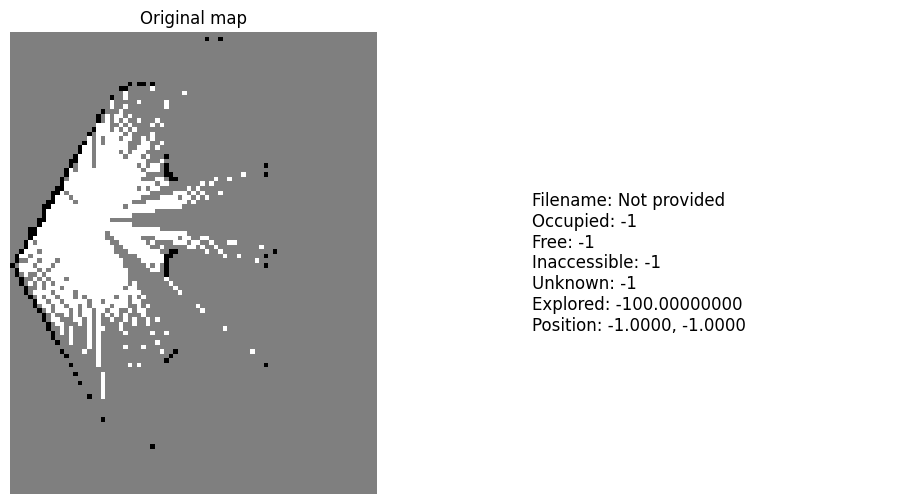

Marking position at world coordinates: (-1.998469234139253, -0.4999996085709637)
Converted to pixel coordinates: (18, 41)
explored %f not explored %f 0.12454611474219317 0.8754538852578069


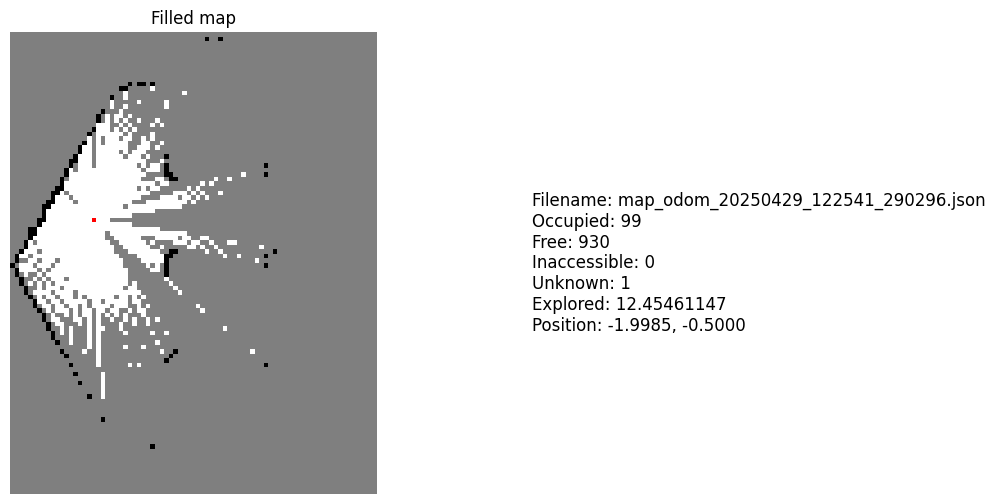

{'header': {'stamp': {'sec': 43, 'nanosec': 283000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 81, 'height': 102, 'origin': {'position': {'x': -2.9384485836973826, 'y': -2.558138259678426, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -

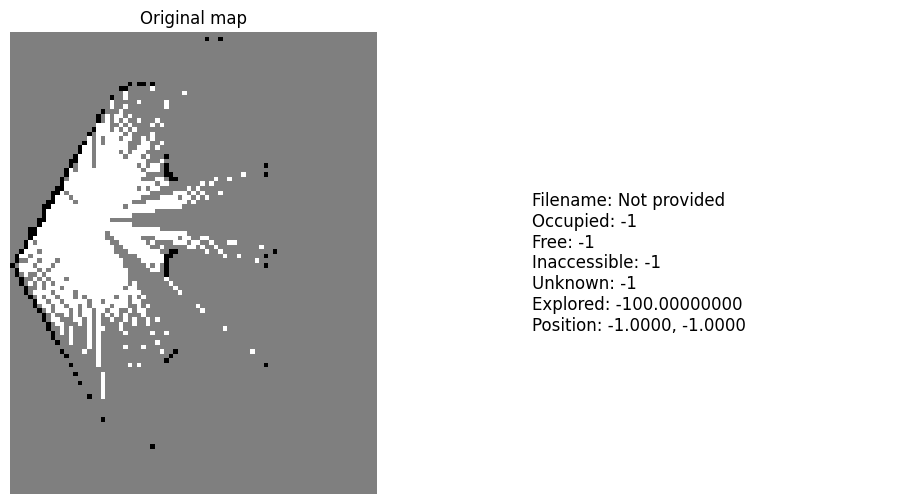

Marking position at world coordinates: (-1.9983977333130178, -0.49999937330369776)
Converted to pixel coordinates: (18, 41)
explored %f not explored %f 0.12454611474219317 0.8754538852578069


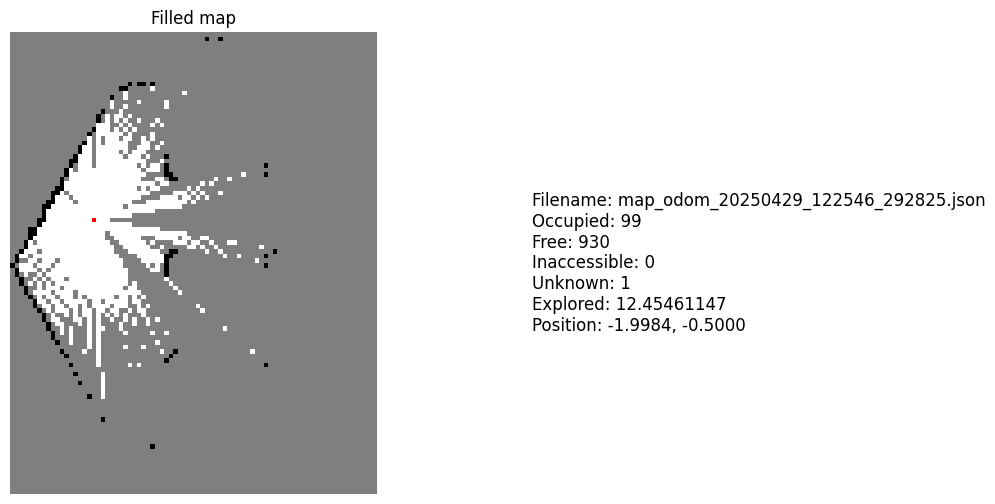

{'header': {'stamp': {'sec': 45, 'nanosec': 285000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 81, 'height': 102, 'origin': {'position': {'x': -2.9384485836973826, 'y': -2.558138259678426, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -

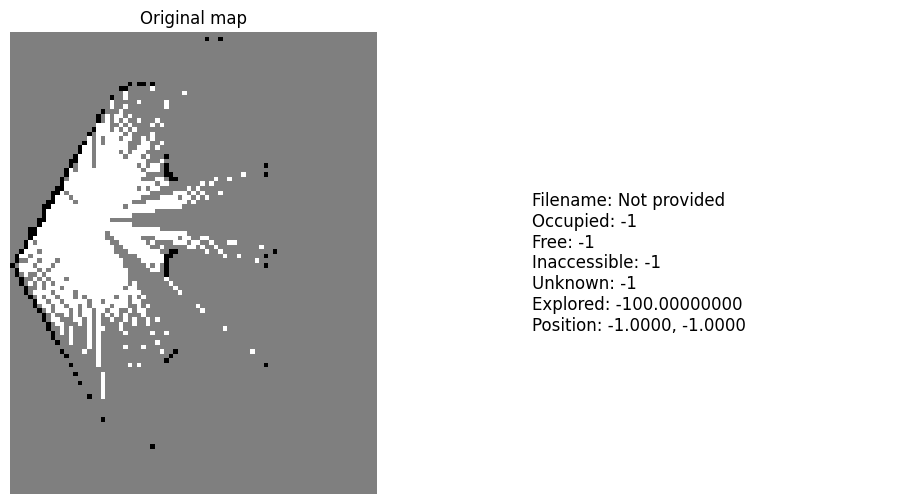

Marking position at world coordinates: (-1.9983275872865833, -0.4999995409632392)
Converted to pixel coordinates: (18, 41)
explored %f not explored %f 0.12454611474219317 0.8754538852578069


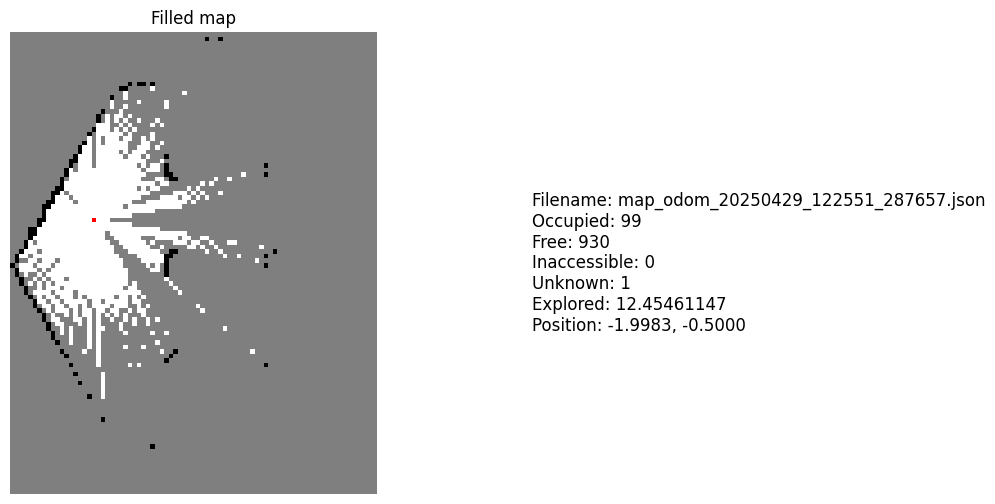

{'header': {'stamp': {'sec': 47, 'nanosec': 694000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 81, 'height': 102, 'origin': {'position': {'x': -2.9384485836973826, 'y': -2.558138259678426, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, 100, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 100, -1, 100, 100, 100, -1, -1, 100, 100, 100, 100, -1, 100, 100, 100, 100, -1, -1, 100, 100, -1, 100, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -

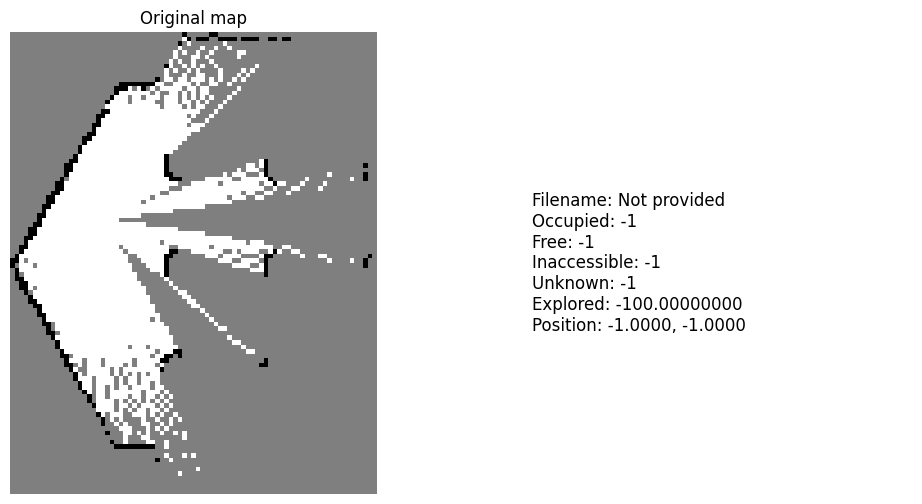

Marking position at world coordinates: (-1.864578958833772, -0.5458296380354734)
Converted to pixel coordinates: (21, 40)
explored %f not explored %f 0.2581699346405229 0.7418300653594772


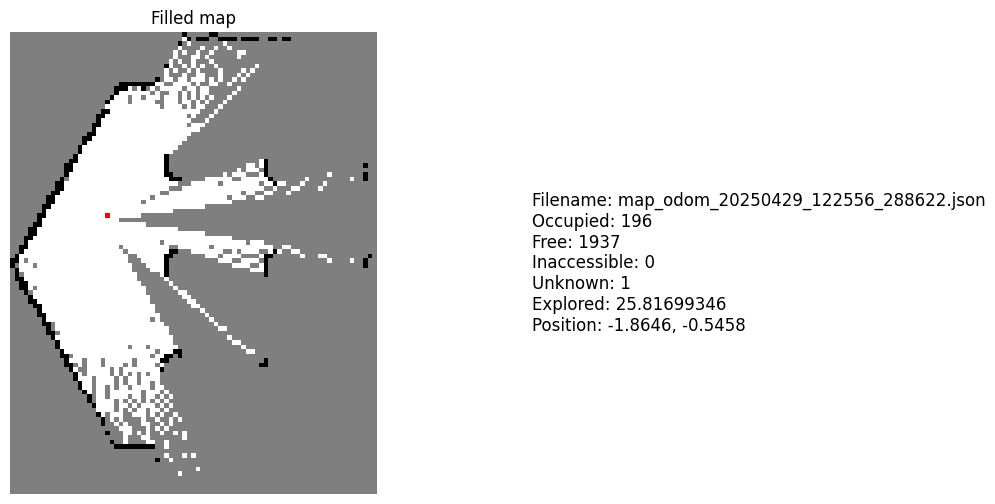

{'header': {'stamp': {'sec': 49, 'nanosec': 906000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 81, 'height': 102, 'origin': {'position': {'x': -2.9524055910814226, 'y': -2.558138259678426, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, -1, -1, -1, 100, 100, -1, -1, 100, -1, -1, 100, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 100, 100, 100, 100, 100, 0, -1, 100, 100, 100, 100, 100, -1, 100, 100, 100, -1, 100, 100, 100, 100, 100, -1, 100, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -

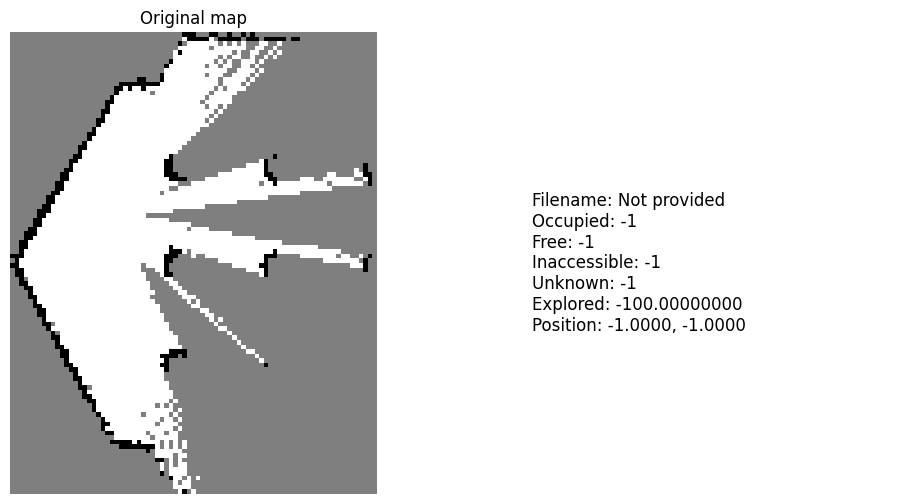

Marking position at world coordinates: (-1.7432890176377094, -0.7416850568646243)
Converted to pixel coordinates: (24, 36)
explored %f not explored %f 0.3286129266521423 0.6713870733478577


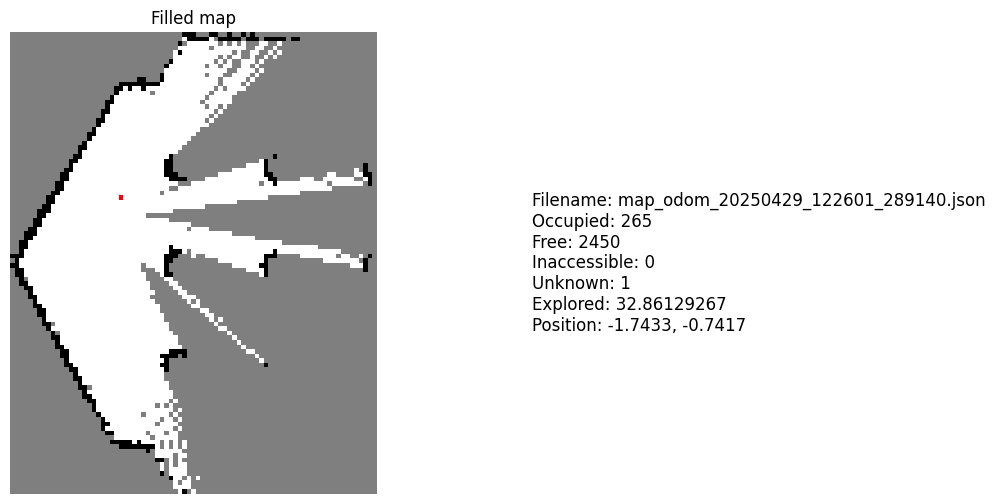

{'header': {'stamp': {'sec': 52, 'nanosec': 315000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 81, 'height': 102, 'origin': {'position': {'x': -2.9524055910814226, 'y': -2.558138259678426, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, -1, -1, -1, 100, 100, -1, -1, 100, -1, -1, 100, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 100, 100, 100, 100, 100, 0, -1, 100, 100, 100, 100, 100, -1, 100, 100, 100, -1, 100, 100, 100, 100, 100, -1, 100, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -

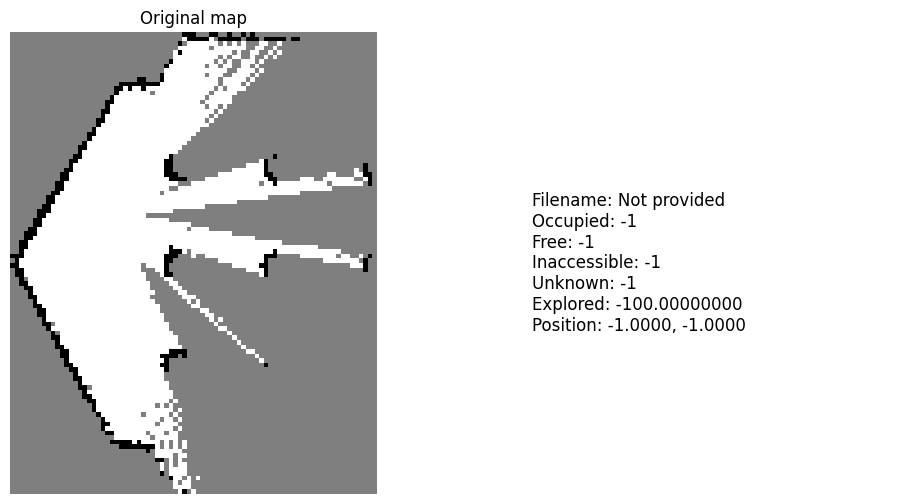

Marking position at world coordinates: (-1.6485602528490253, -0.9489717180330081)
Converted to pixel coordinates: (26, 32)
explored %f not explored %f 0.3286129266521423 0.6713870733478577


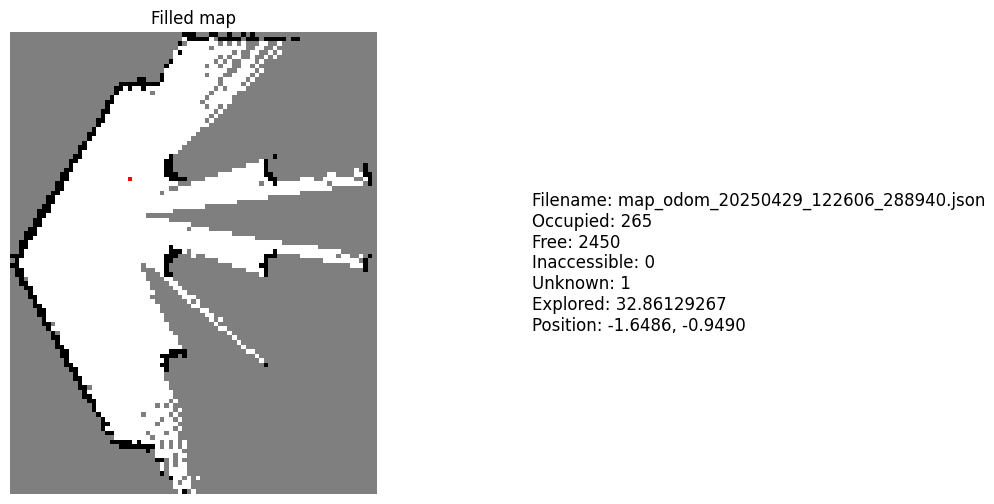

{'header': {'stamp': {'sec': 54, 'nanosec': 527000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 84, 'height': 102, 'origin': {'position': {'x': -2.9524055910814226, 'y': -2.558138259678426, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, -1, -1, -1, 100, 100, -1, 100, 100, -1, -1, 100, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, -1, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, -1, 100, 100, -1, 100, -1, -1, -1, -1, -1, -

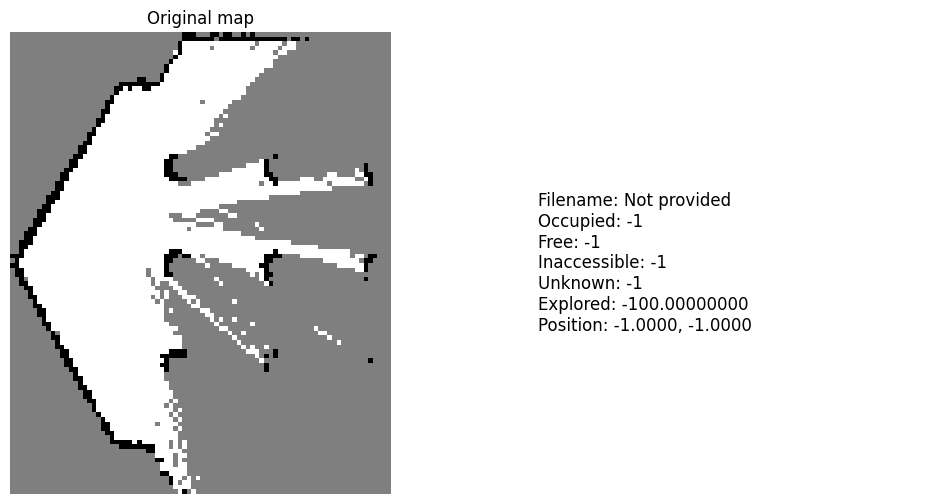

Marking position at world coordinates: (-1.548005486825117, -1.1608863037568689)
Converted to pixel coordinates: (28, 27)
explored %f not explored %f 0.34290382819794585 0.6570961718020542


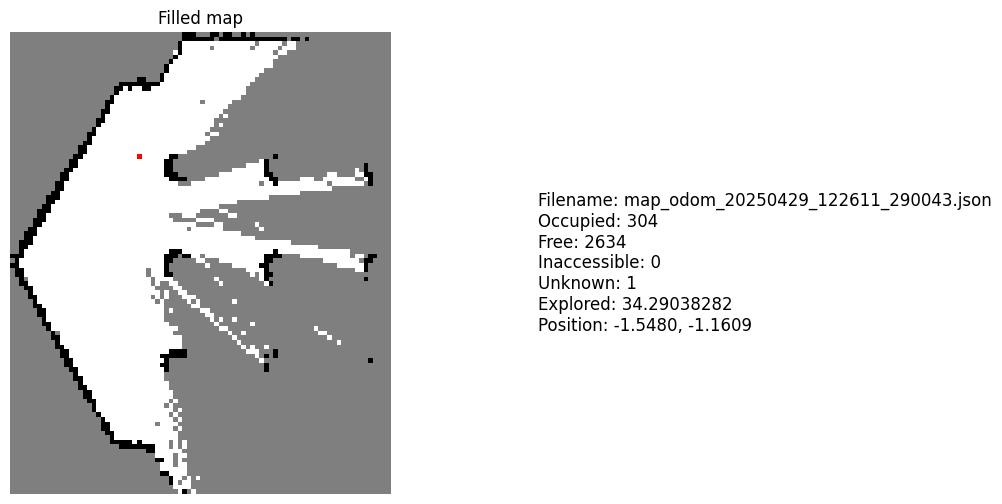

{'header': {'stamp': {'sec': 57, 'nanosec': 141000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 84, 'height': 102, 'origin': {'position': {'x': -2.9524055910814226, 'y': -2.558138259678426, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, -1, -1, -1, 100, 100, -1, 100, 100, -1, -1, 100, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, -1, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, -1, 100, 100, -1, 100, -1, -1, -1, -1, -1, -

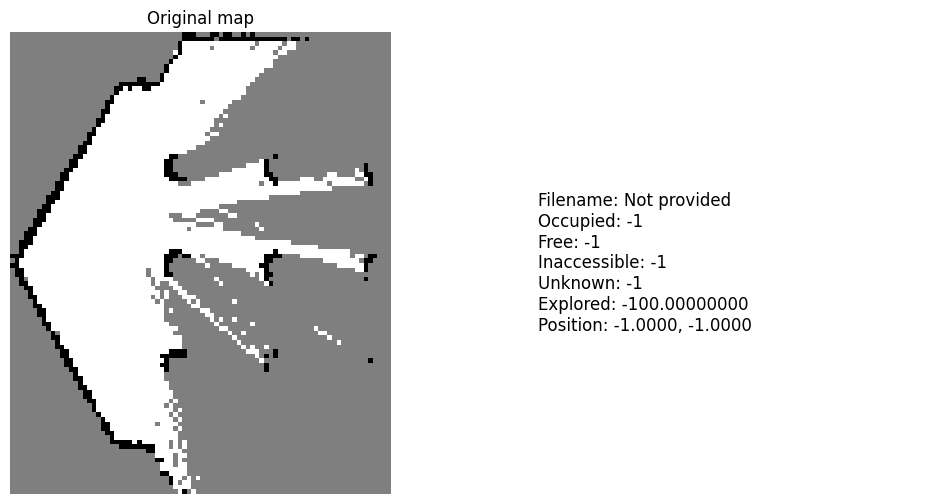

Marking position at world coordinates: (-1.4296959360820949, -1.3790712164671934)
Converted to pixel coordinates: (30, 23)
explored %f not explored %f 0.34290382819794585 0.6570961718020542


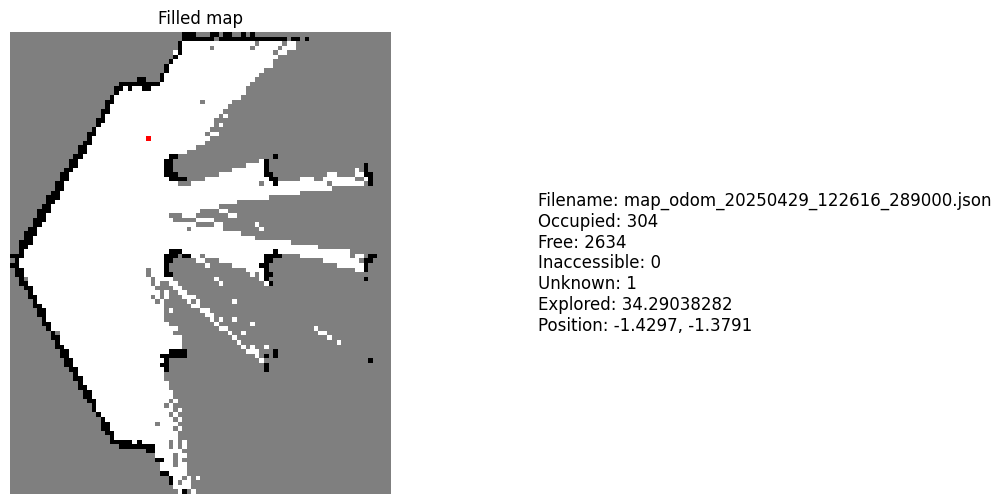

{'header': {'stamp': {'sec': 59, 'nanosec': 143000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 101, 'height': 102, 'origin': {'position': {'x': -2.9524055910814226, 'y': -2.558138259678426, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, -1, -1, 100, 100, -1, 100, 100, 100, -1, 100, -1, 100, 100, -1, -1, 100, -1, -1, 100, 100, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 1

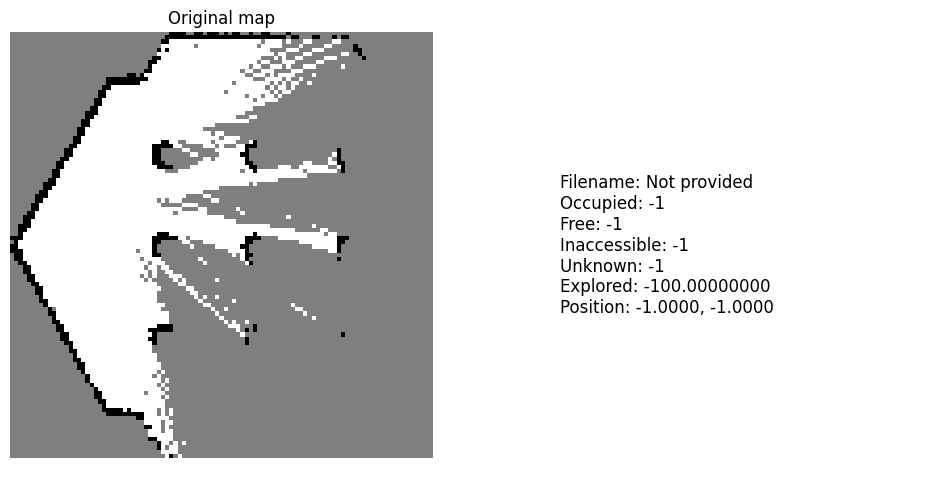

Marking position at world coordinates: (-1.3214448970636452, -1.5599320868423998)
Converted to pixel coordinates: (32, 19)
explored %f not explored %f 0.3197437390797903 0.6802562609202096


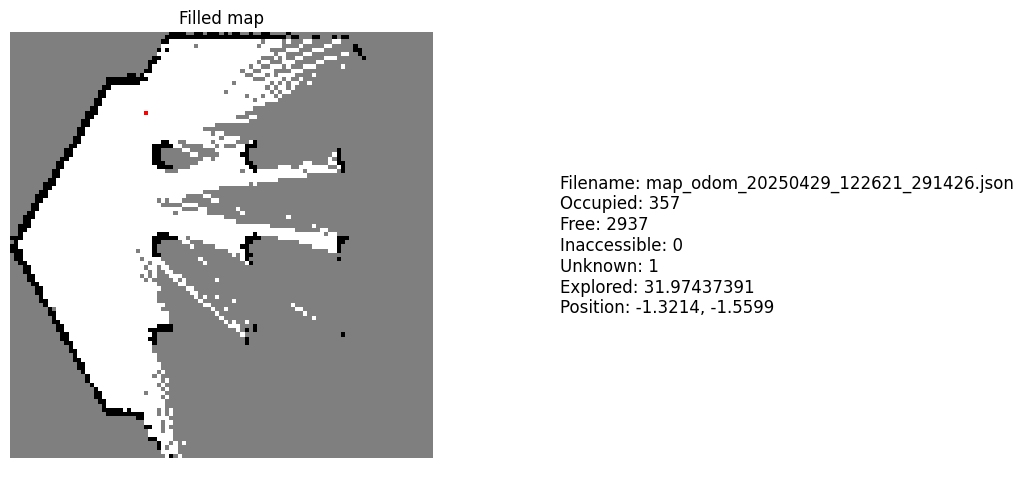

{'header': {'stamp': {'sec': 61, 'nanosec': 354000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 101, 'height': 102, 'origin': {'position': {'x': -2.9524055910814226, 'y': -2.558138259678426, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, -1, -1, 100, 100, -1, 100, 100, 100, -1, 100, -1, 100, 100, -1, -1, 100, -1, -1, 100, 100, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 1

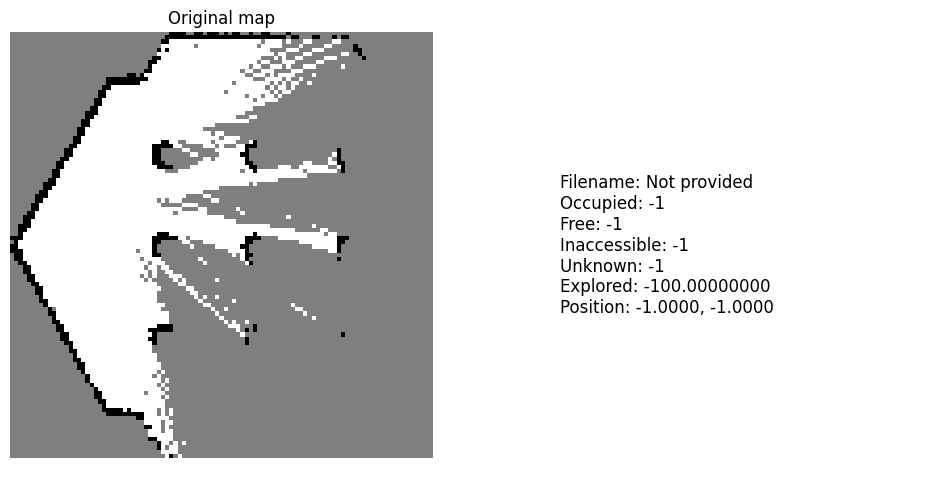

Marking position at world coordinates: (-1.189416881413687, -1.737011065598183)
Converted to pixel coordinates: (35, 16)
explored %f not explored %f 0.3197437390797903 0.6802562609202096


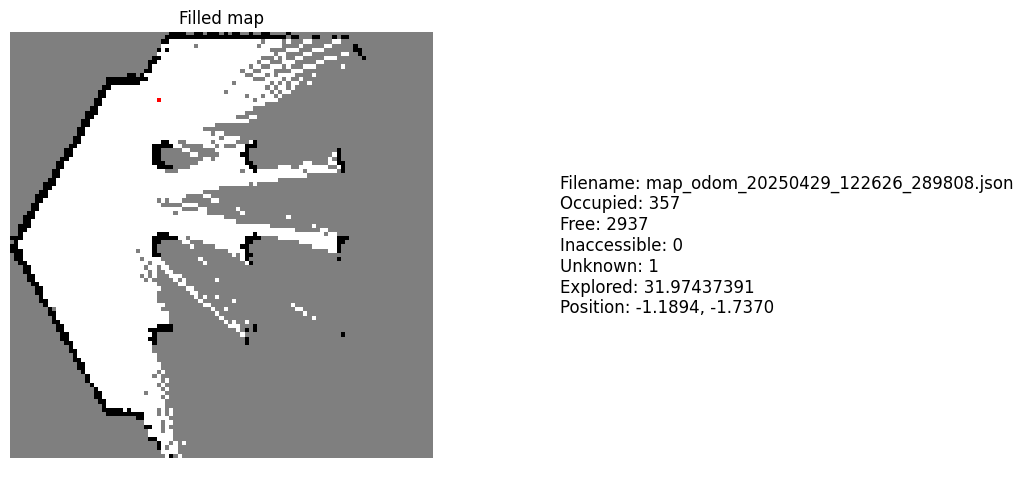

{'header': {'stamp': {'sec': 63, 'nanosec': 364000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 101, 'height': 102, 'origin': {'position': {'x': -2.9524055910814226, 'y': -2.558138259678426, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, -1, -1, 100, 100, -1, 100, 100, 100, -1, 100, -1, 100, 100, -1, -1, 100, -1, -1, 100, 100, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 1

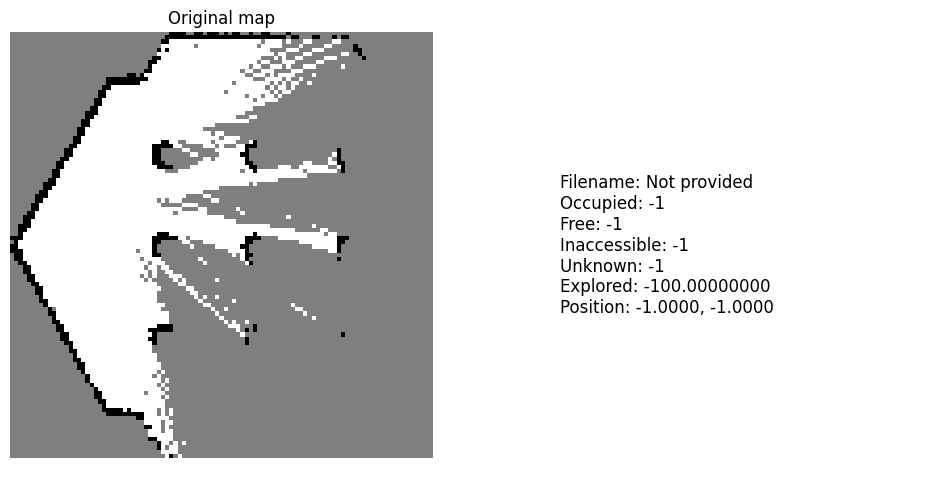

Marking position at world coordinates: (-1.0616846644904165, -1.900479401266769)
Converted to pixel coordinates: (37, 13)
explored %f not explored %f 0.3197437390797903 0.6802562609202096


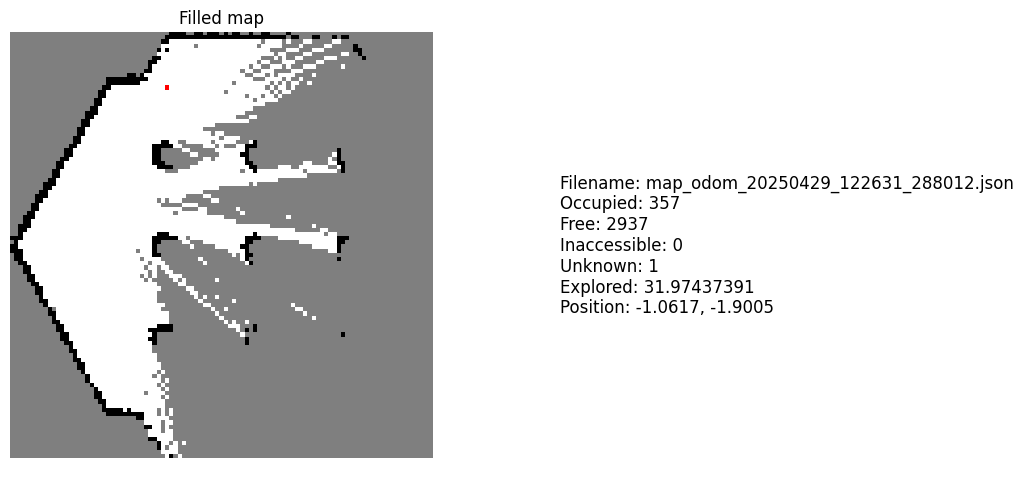

{'header': {'stamp': {'sec': 65, 'nanosec': 772000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 105, 'height': 103, 'origin': {'position': {'x': -2.9524055910814226, 'y': -2.5814668560064913, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, 100, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 1

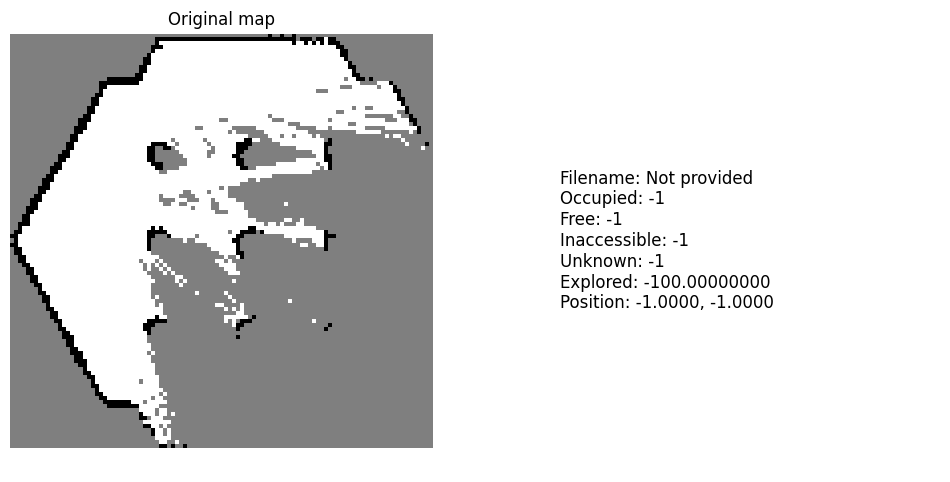

Marking position at world coordinates: (-0.9001296883307097, -2.0068863261746475)
Converted to pixel coordinates: (41, 11)
explored %f not explored %f 0.381044845122515 0.618955154877485


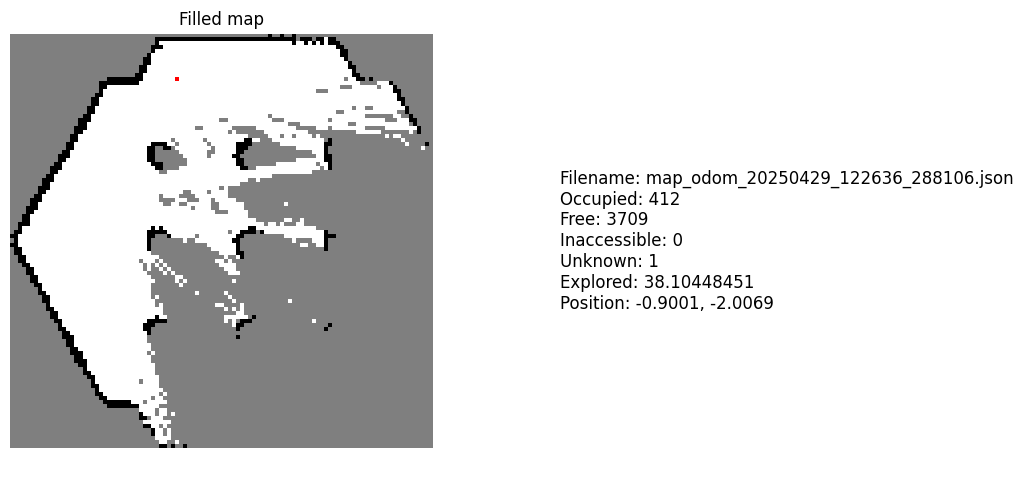

{'header': {'stamp': {'sec': 67, 'nanosec': 982000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 105, 'height': 103, 'origin': {'position': {'x': -2.9524055910814226, 'y': -2.5814668560064913, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, 100, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 1

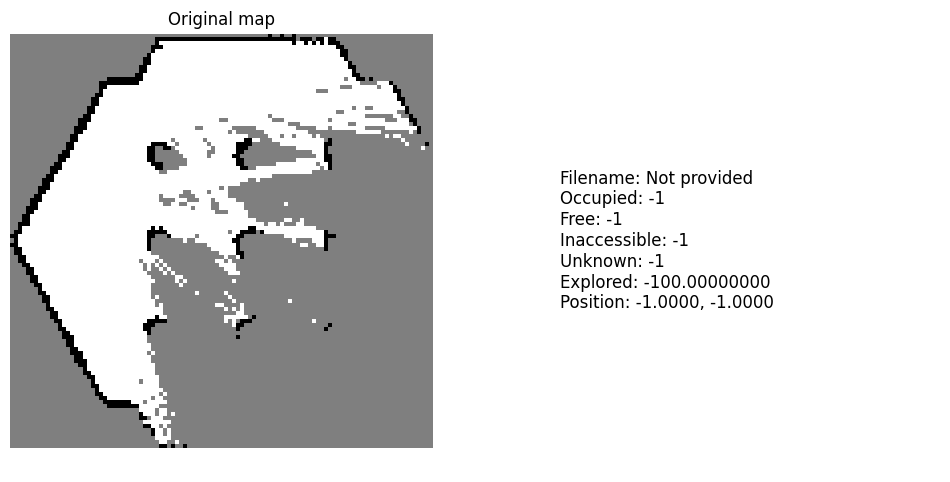

Marking position at world coordinates: (-0.6929546739576962, -2.0050674251580207)
Converted to pixel coordinates: (45, 11)
explored %f not explored %f 0.381044845122515 0.618955154877485


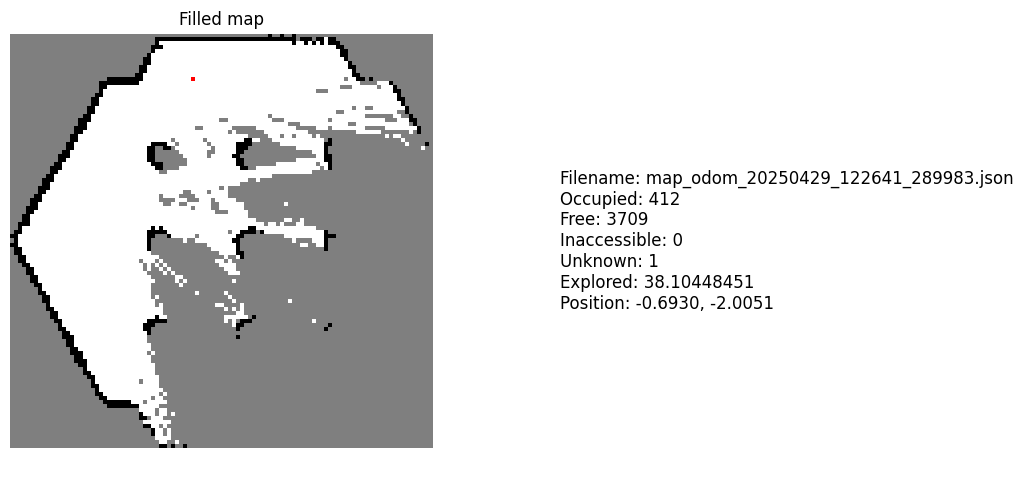

{'header': {'stamp': {'sec': 69, 'nanosec': 997000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 105, 'height': 103, 'origin': {'position': {'x': -2.9524055910814226, 'y': -2.5814668560064913, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, 100, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 1

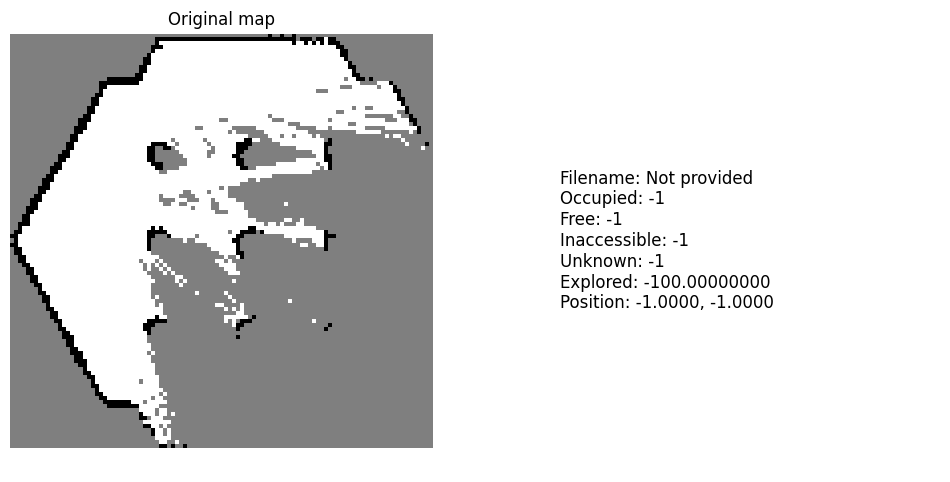

Marking position at world coordinates: (-0.48211722089045506, -2.0008605748652246)
Converted to pixel coordinates: (49, 11)
explored %f not explored %f 0.381044845122515 0.618955154877485


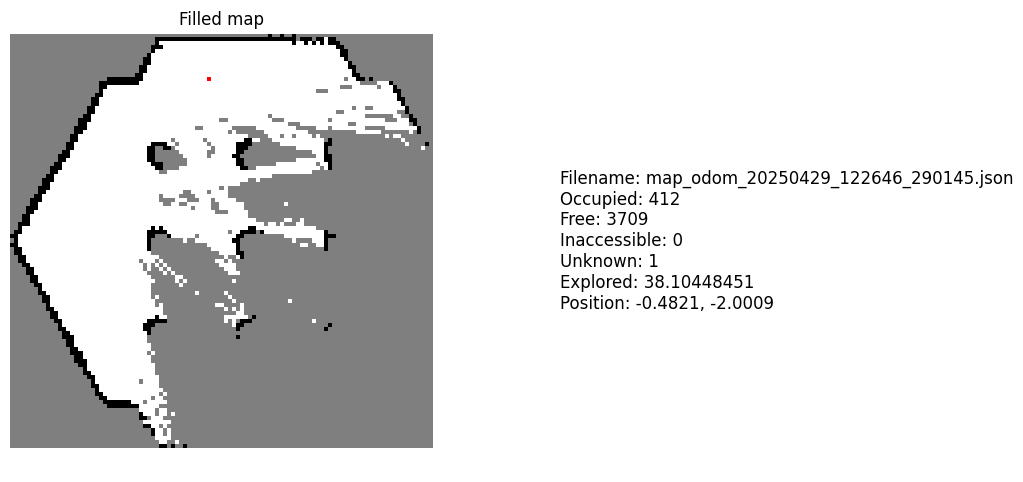

{'header': {'stamp': {'sec': 72, 'nanosec': 400000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 110, 'height': 103, 'origin': {'position': {'x': -2.969823197293329, 'y': -2.5814668560064913, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, 100, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100

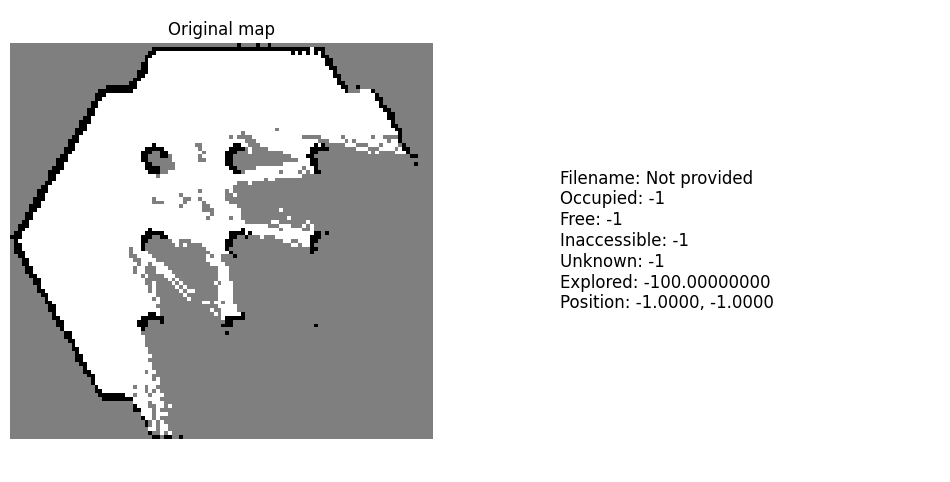

Marking position at world coordinates: (-0.2474639416620419, -1.9965375531895873)
Converted to pixel coordinates: (54, 11)
explored %f not explored %f 0.3848190644307149 0.6151809355692851


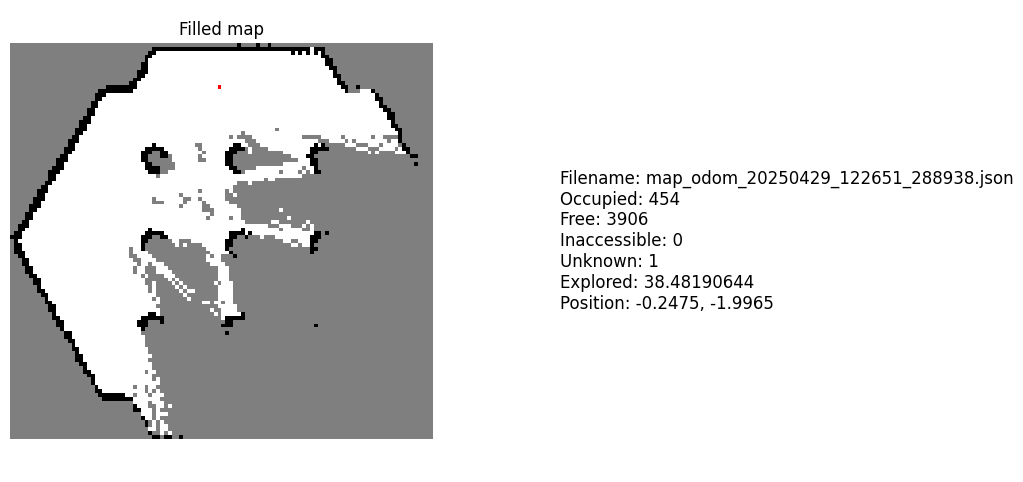

{'header': {'stamp': {'sec': 74, 'nanosec': 606000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 110, 'height': 103, 'origin': {'position': {'x': -2.969823197293329, 'y': -2.5814668560064913, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, 100, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100

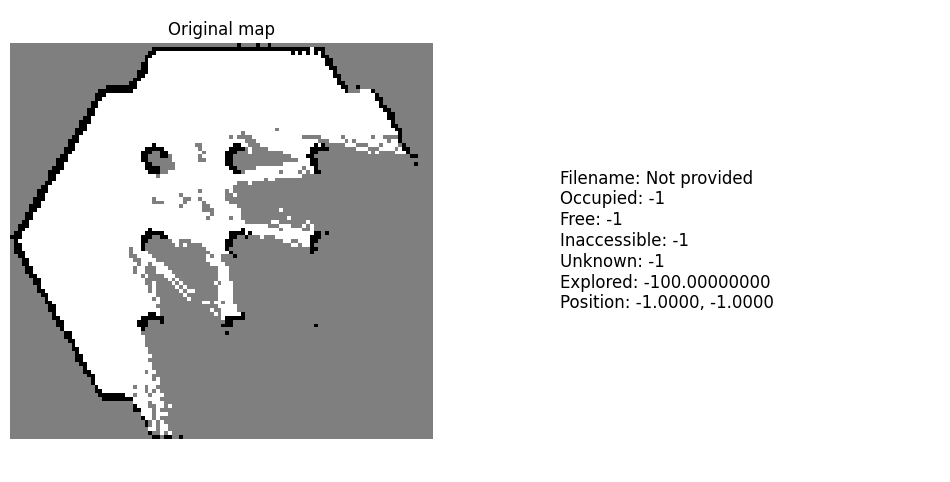

Marking position at world coordinates: (-0.022987710285805905, -1.9937677280624357)
Converted to pixel coordinates: (58, 11)
explored %f not explored %f 0.3848190644307149 0.6151809355692851


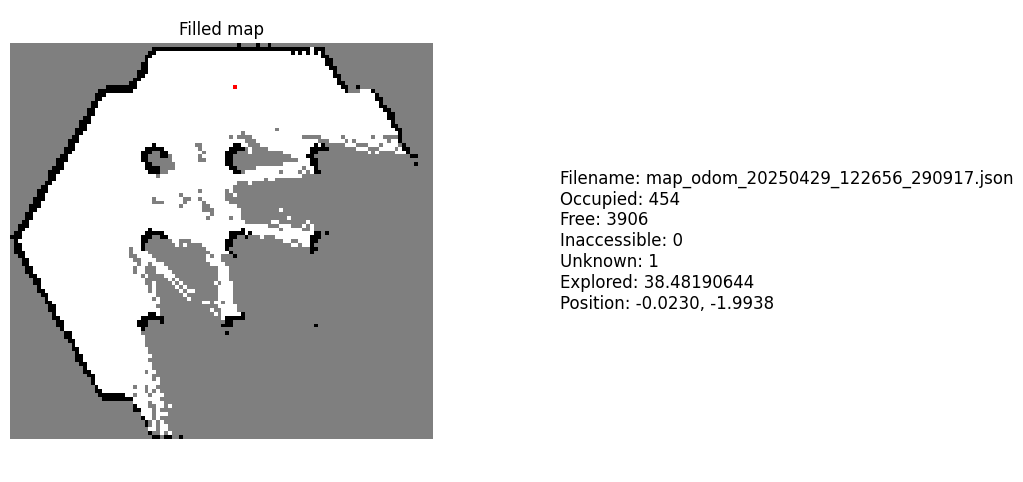

{'header': {'stamp': {'sec': 76, 'nanosec': 818000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 111, 'height': 103, 'origin': {'position': {'x': -2.969823197293329, 'y': -2.5814668560064913, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, 100, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,

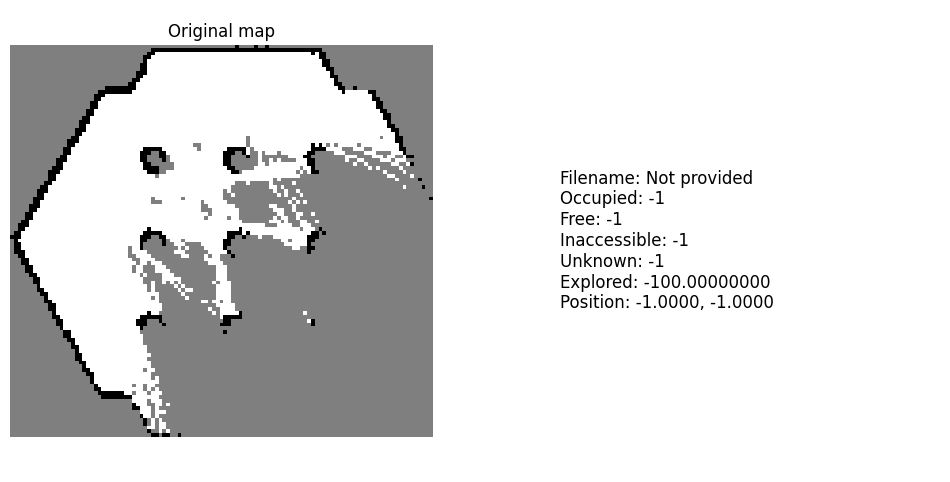

Marking position at world coordinates: (0.2048975412506561, -1.991904188802678)
Converted to pixel coordinates: (63, 11)
explored %f not explored %f 0.39779585410653373 0.6022041458934663


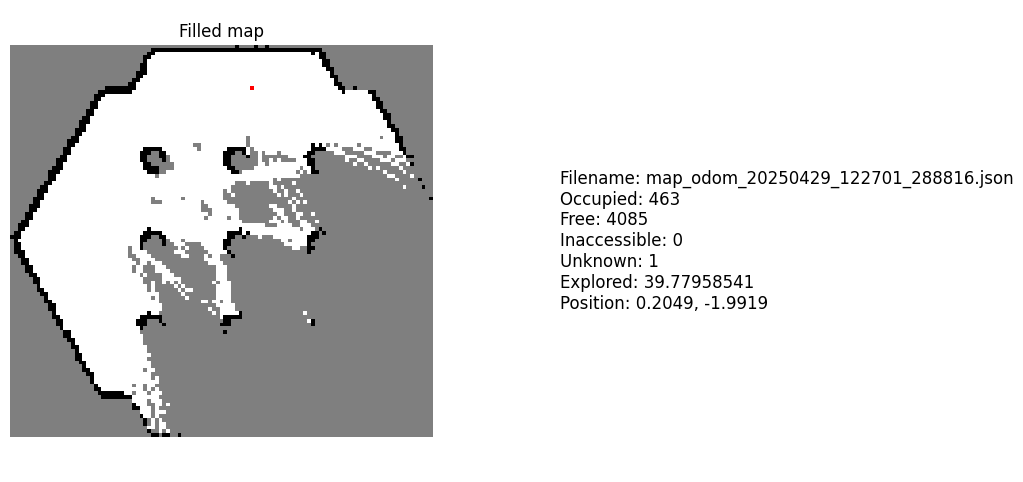

{'header': {'stamp': {'sec': 79, 'nanosec': 20000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 111, 'height': 103, 'origin': {'position': {'x': -2.969823197293329, 'y': -2.5814668560064913, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, 100, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 

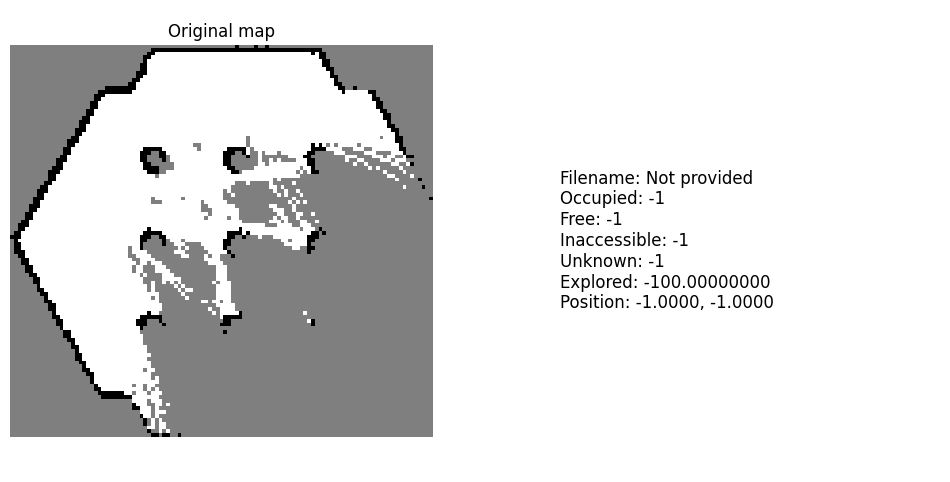

Marking position at world coordinates: (0.4146874084696136, -1.9784012715475672)
Converted to pixel coordinates: (67, 12)
explored %f not explored %f 0.39779585410653373 0.6022041458934663


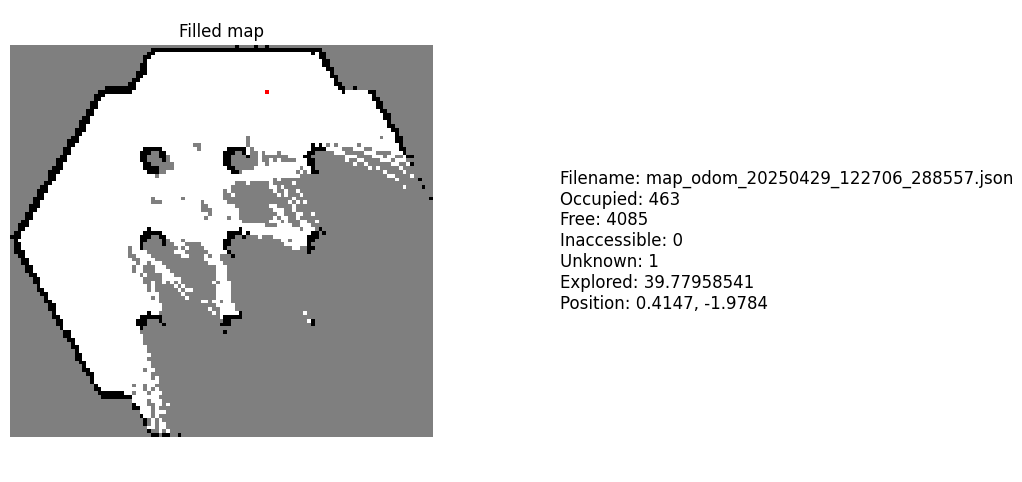

{'header': {'stamp': {'sec': 81, 'nanosec': 227000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 111, 'height': 103, 'origin': {'position': {'x': -2.969823197293329, 'y': -2.5814668560064913, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, 100, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,

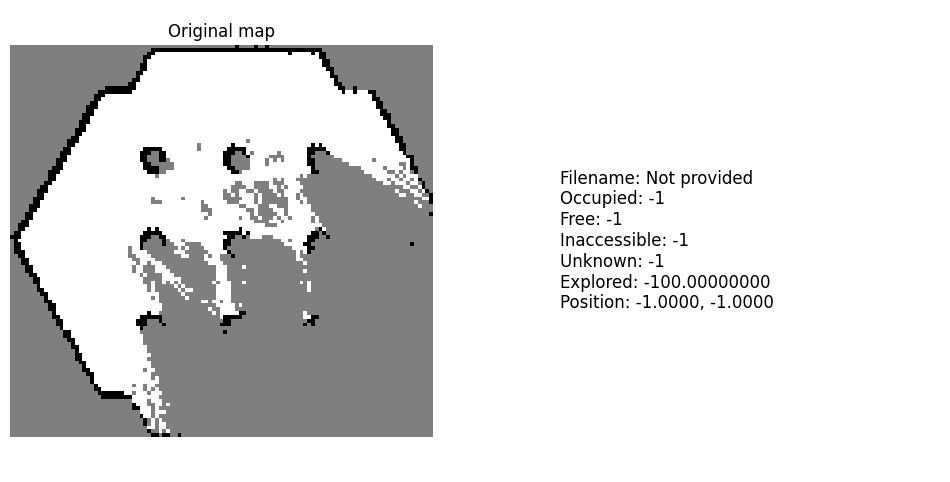

Marking position at world coordinates: (0.6361327799150968, -1.925434307744067)
Converted to pixel coordinates: (72, 13)
explored %f not explored %f 0.4195749147205458 0.5804250852794541


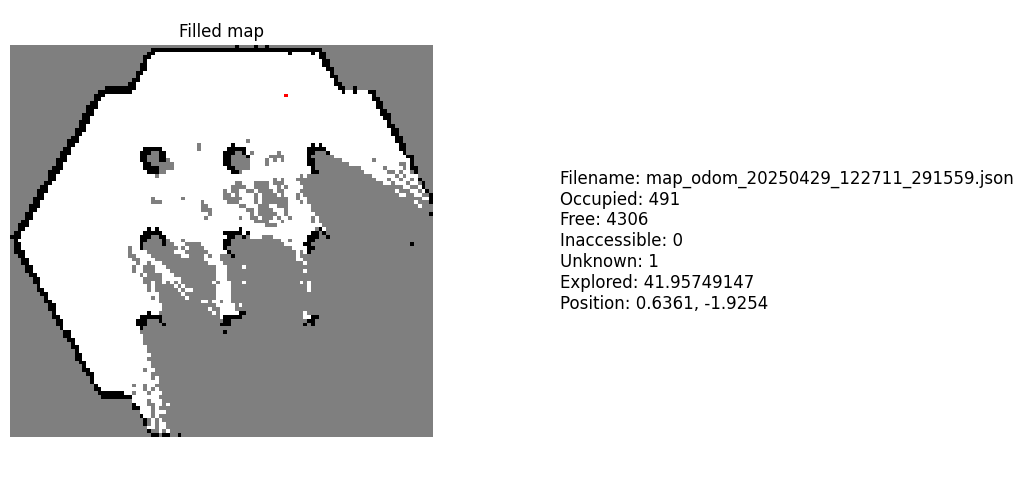

{'header': {'stamp': {'sec': 83, 'nanosec': 433000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 111, 'height': 103, 'origin': {'position': {'x': -2.969823197293329, 'y': -2.5814668560064913, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, 100, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,

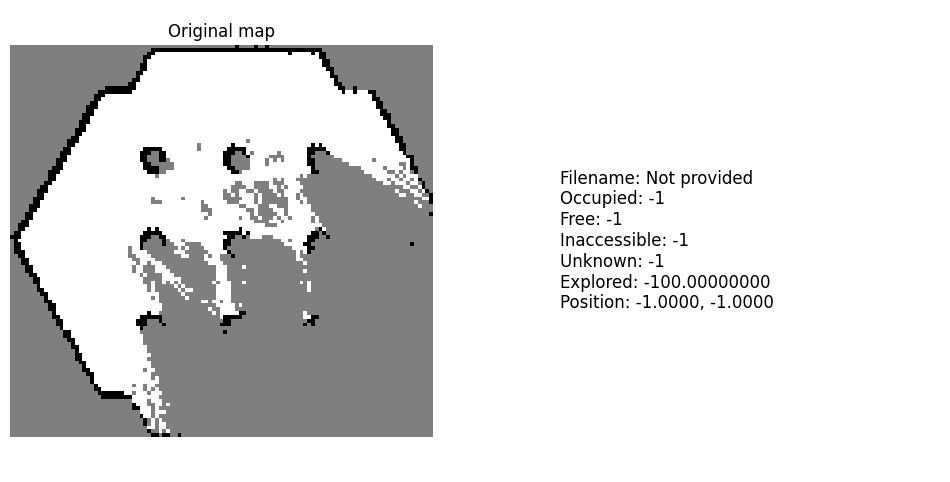

Marking position at world coordinates: (0.8506916858471326, -1.87235108855257)
Converted to pixel coordinates: (76, 14)
explored %f not explored %f 0.4195749147205458 0.5804250852794541


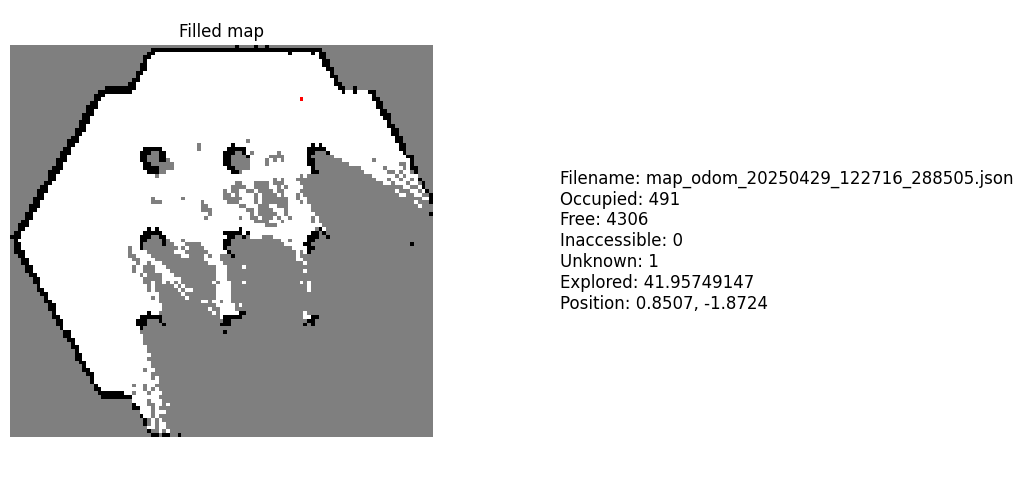

{'header': {'stamp': {'sec': 85, 'nanosec': 842000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 111, 'height': 103, 'origin': {'position': {'x': -2.969823197293329, 'y': -2.5834023324721773, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, 100, -1, -1, -1, -1, 100, -1, 100, -1, -1, -1, -1, -1, 100, -1, -1, -1, 100, -1, -1, 100, -1, 100, 100, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 10

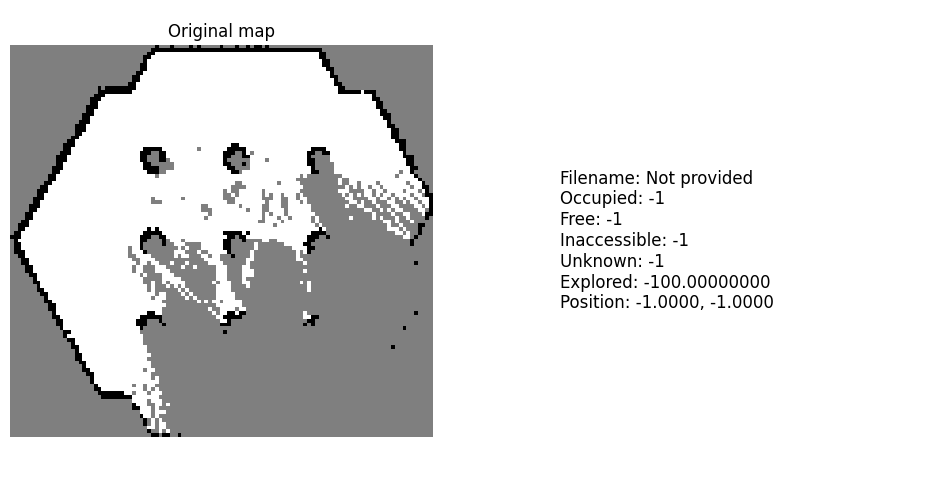

Marking position at world coordinates: (1.0827564483168632, -1.8057501328428893)
Converted to pixel coordinates: (81, 15)
explored %f not explored %f 0.44625207732003846 0.5537479226799615


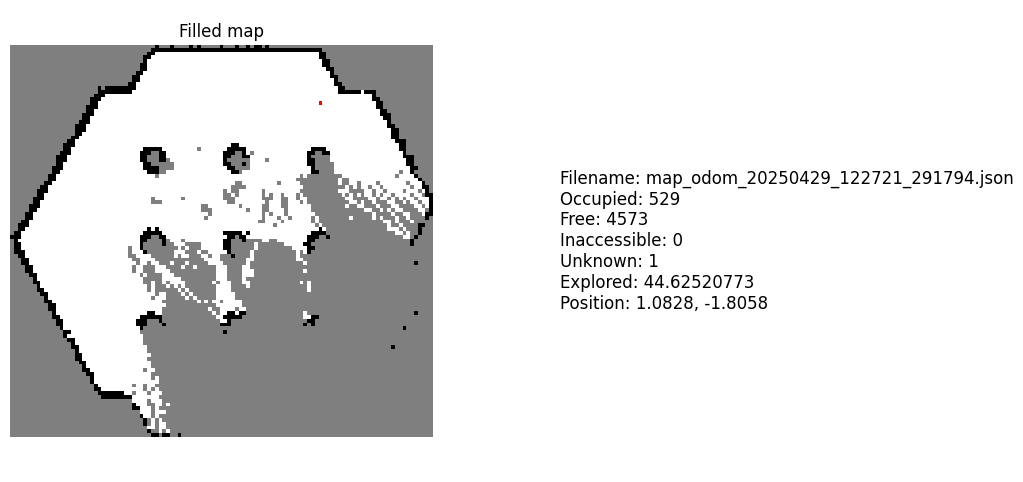

{'header': {'stamp': {'sec': 88, 'nanosec': 257000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 111, 'height': 103, 'origin': {'position': {'x': -2.969823197293329, 'y': -2.5834023324721773, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, 100, -1, -1, -1, -1, 100, -1, 100, -1, -1, -1, -1, -1, 100, -1, -1, -1, 100, -1, -1, 100, -1, 100, 100, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 10

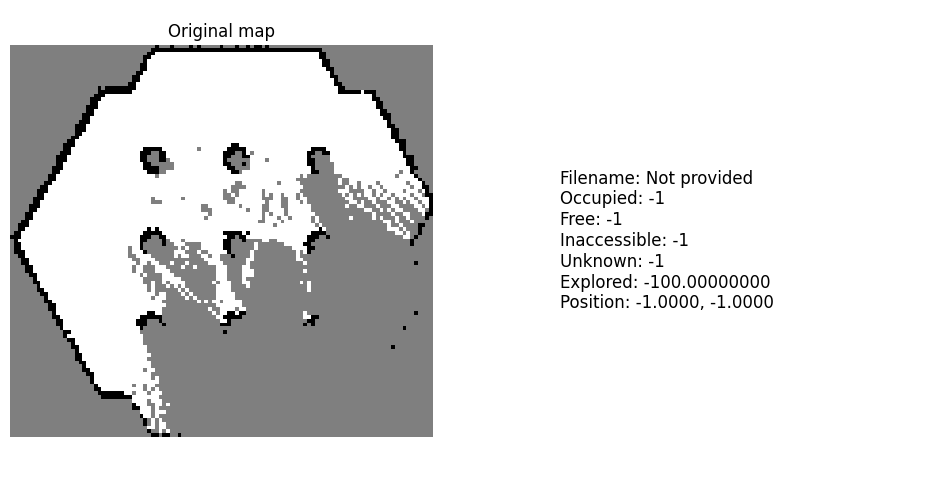

Marking position at world coordinates: (1.3026835397727934, -1.7462947269467122)
Converted to pixel coordinates: (85, 16)
explored %f not explored %f 0.44625207732003846 0.5537479226799615


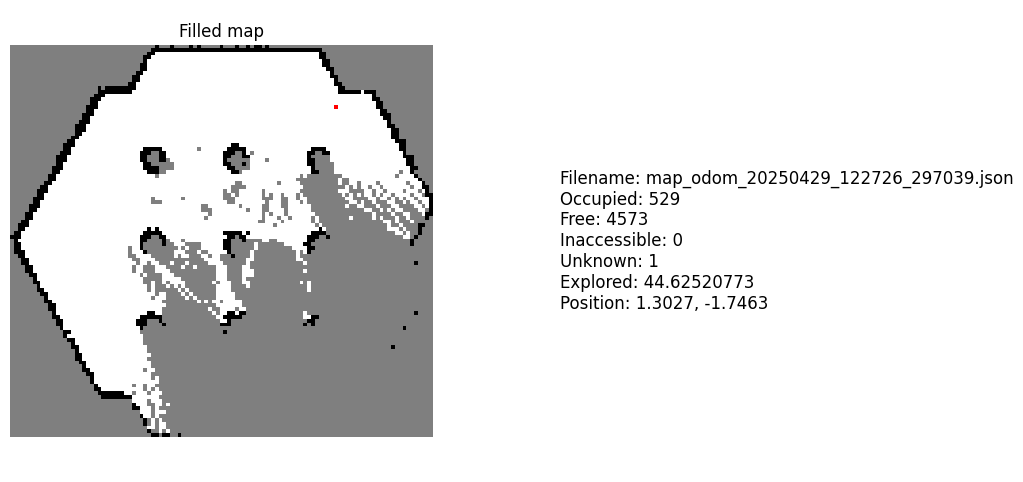

{'header': {'stamp': {'sec': 90, 'nanosec': 262000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 111, 'height': 103, 'origin': {'position': {'x': -2.969823197293329, 'y': -2.5834023324721773, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, 100, -1, -1, -1, -1, 100, -1, 100, -1, -1, -1, -1, -1, 100, -1, -1, -1, 100, -1, -1, 100, -1, 100, 100, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 10

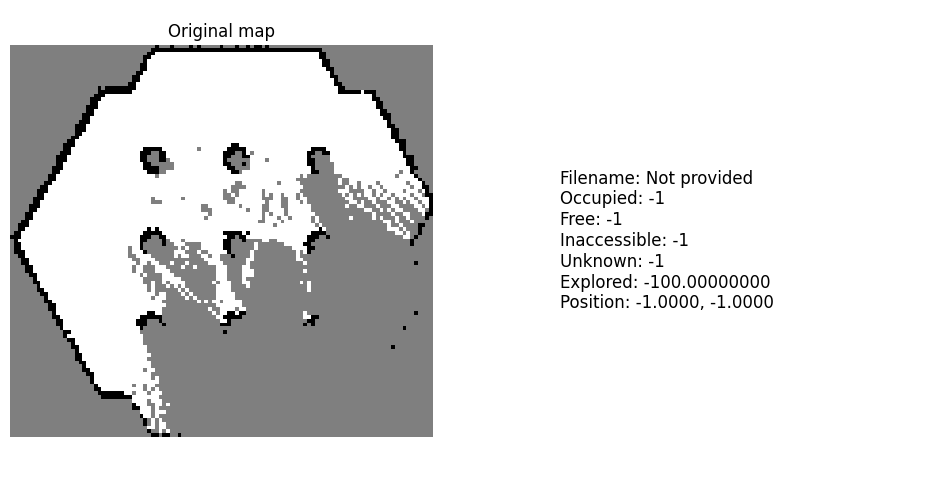

Marking position at world coordinates: (1.4257875668589919, -1.7058911912677397)
Converted to pixel coordinates: (87, 17)
explored %f not explored %f 0.44625207732003846 0.5537479226799615


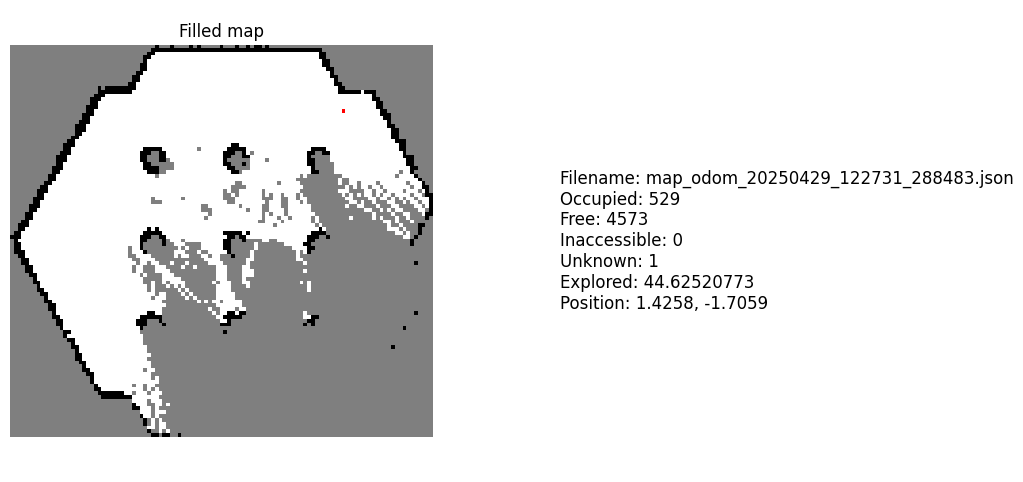

{'header': {'stamp': {'sec': 92, 'nanosec': 661000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 111, 'height': 103, 'origin': {'position': {'x': -2.969823197293329, 'y': -2.5834023324721773, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, 100, -1, -1, -1, -1, 100, -1, 100, -1, -1, -1, -1, -1, 100, -1, -1, -1, 100, -1, -1, 100, -1, 100, 100, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 10

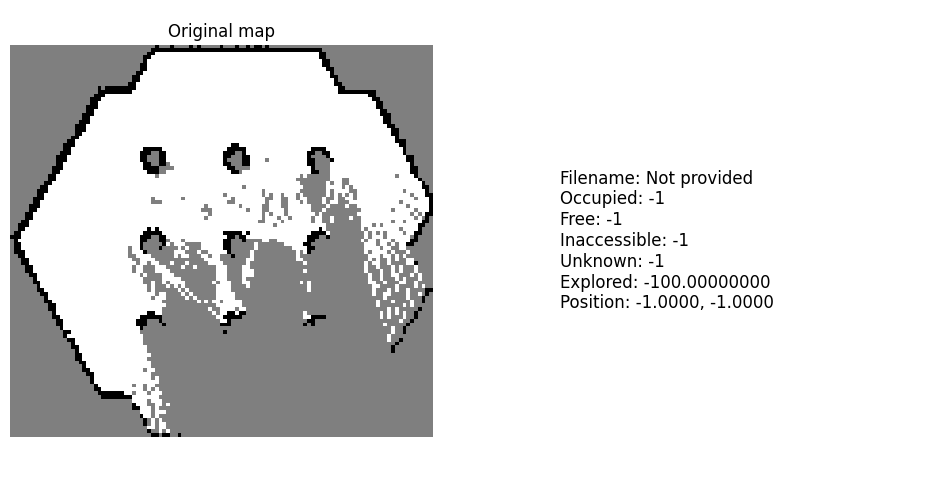

Marking position at world coordinates: (1.5351018698832606, -1.5823324116259554)
Converted to pixel coordinates: (90, 20)
explored %f not explored %f 0.4747660281640864 0.5252339718359136


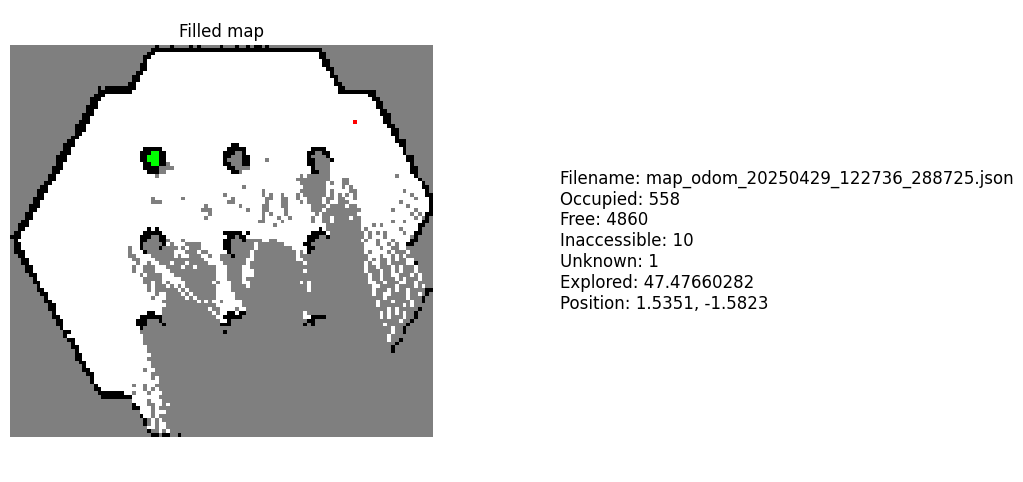

{'header': {'stamp': {'sec': 95, 'nanosec': 76000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 111, 'height': 103, 'origin': {'position': {'x': -2.969823197293329, 'y': -2.5834023324721773, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, 100, -1, -1, -1, -1, 100, -1, 100, -1, -1, -1, -1, -1, 100, -1, -1, -1, 100, -1, -1, 100, -1, 100, 100, -1, 100, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 10

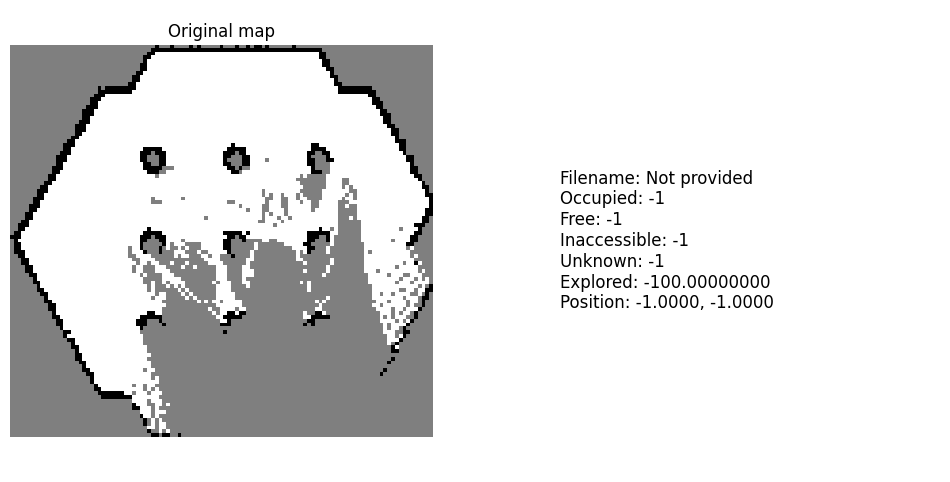

Marking position at world coordinates: (1.5651132589995347, -1.3298940679855522)
Converted to pixel coordinates: (90, 25)
explored %f not explored %f 0.4995189364121403 0.5004810635878597


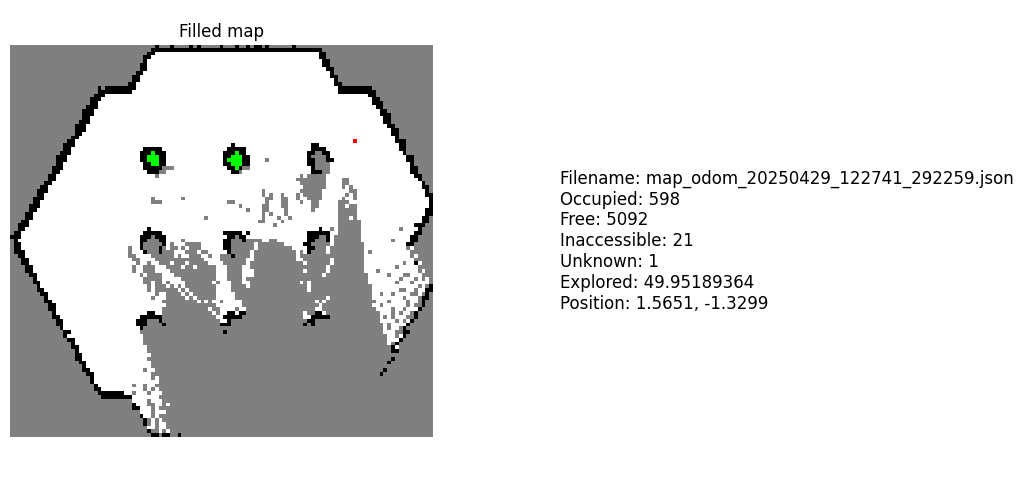

{'header': {'stamp': {'sec': 97, 'nanosec': 479000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 111, 'height': 103, 'origin': {'position': {'x': -2.969823197293329, 'y': -2.5834023324721773, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, 100, -1, -1, -1, -1, 100, -1, 100, -1, -1, -1, -1, -1, 100, -1, -1, -1, 100, -1, -1, 100, -1, 100, 100, -1, 100, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 1

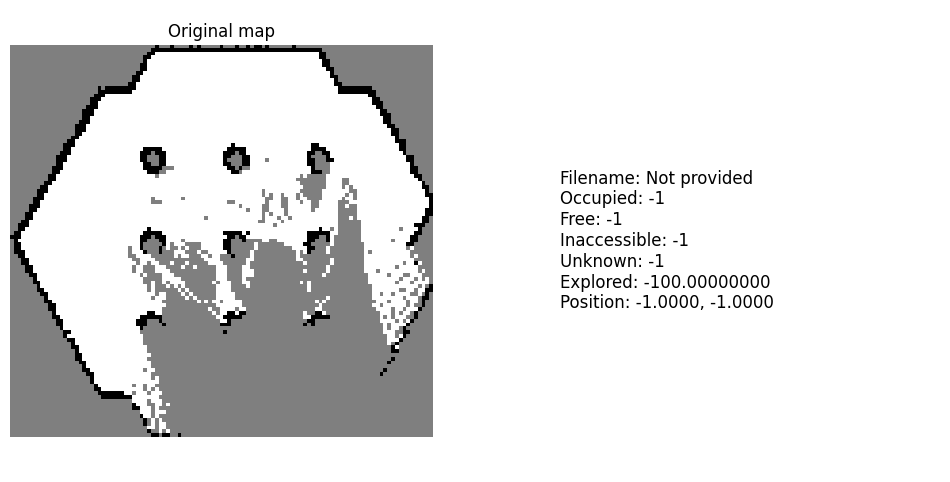

Marking position at world coordinates: (1.5772930714232538, -1.0989870731106368)
Converted to pixel coordinates: (90, 29)
explored %f not explored %f 0.4995189364121403 0.5004810635878597


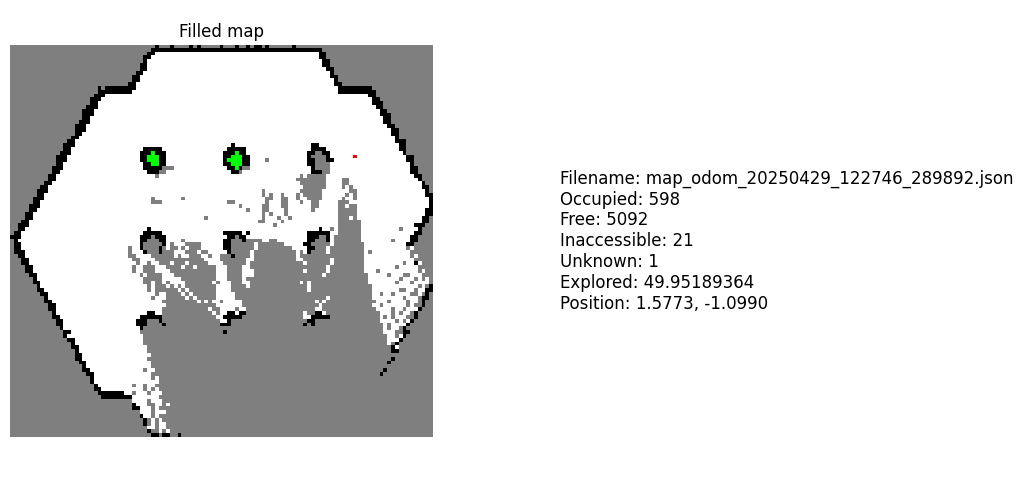

{'header': {'stamp': {'sec': 99, 'nanosec': 893000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 111, 'height': 103, 'origin': {'position': {'x': -2.969823197293329, 'y': -2.5834023324721773, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, 100, 100, -1, -1, -1, 100, -1, 100, 100, -1, 100, 100, -1, 100, -1, -1, -1, 100, -1, 100, 100, -1, 100, 100, 100, 100, 100, 100, -1, -1, 100, 100, 100, 100, -1, 100, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, 100, 10

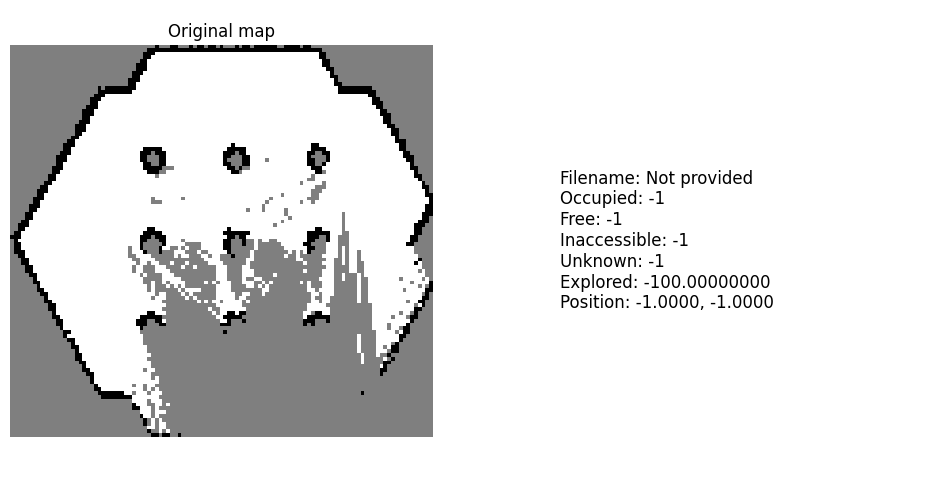

Marking position at world coordinates: (1.5875162056966952, -0.861078257366553)
Converted to pixel coordinates: (91, 34)
explored %f not explored %f 0.5323187264934838 0.4676812735065162


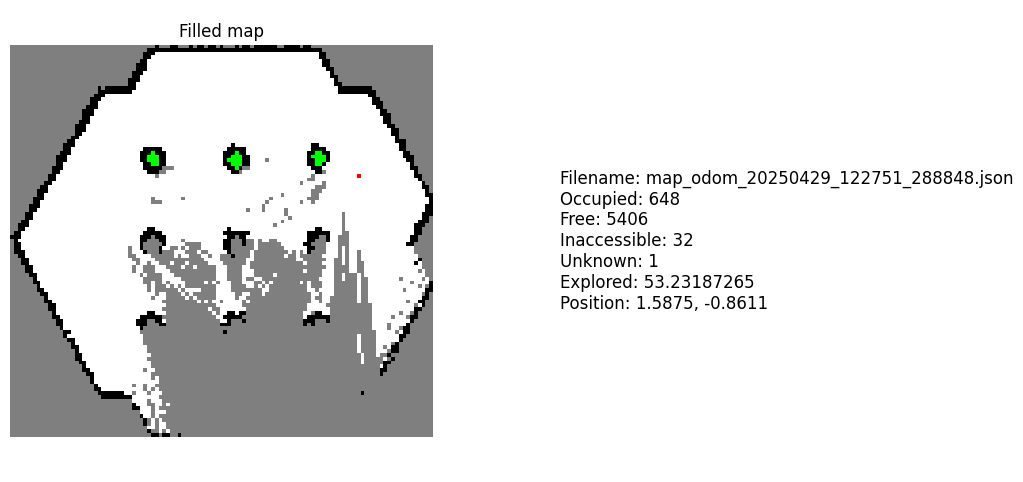

{'header': {'stamp': {'sec': 102, 'nanosec': 98000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 111, 'height': 103, 'origin': {'position': {'x': -2.969823197293329, 'y': -2.5834023324721773, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, 100, 100, -1, -1, -1, 100, -1, 100, 100, -1, 100, 100, -1, 100, -1, -1, -1, 100, -1, 100, 100, -1, 100, 100, 100, 100, 100, 100, -1, -1, 100, 100, 100, 100, -1, 100, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, 100, 10

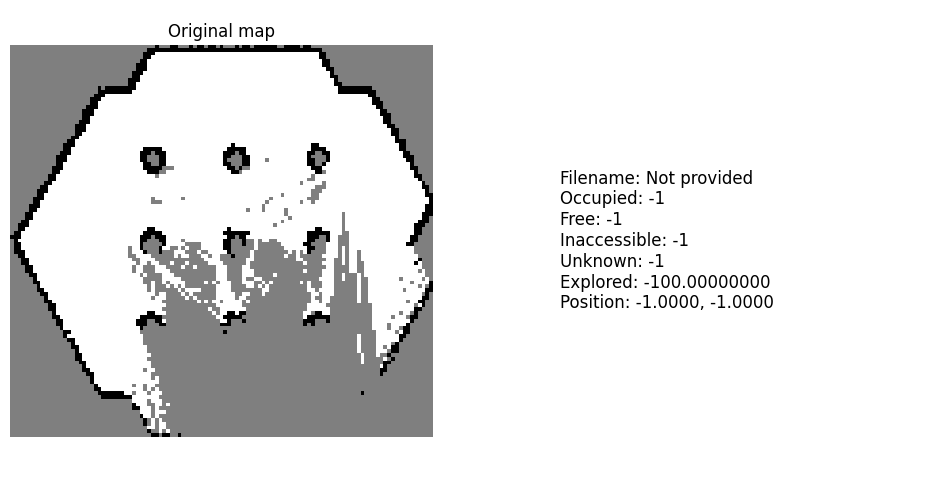

Marking position at world coordinates: (1.6063884254208334, -0.6407894956420844)
Converted to pixel coordinates: (91, 38)
explored %f not explored %f 0.5323187264934838 0.4676812735065162


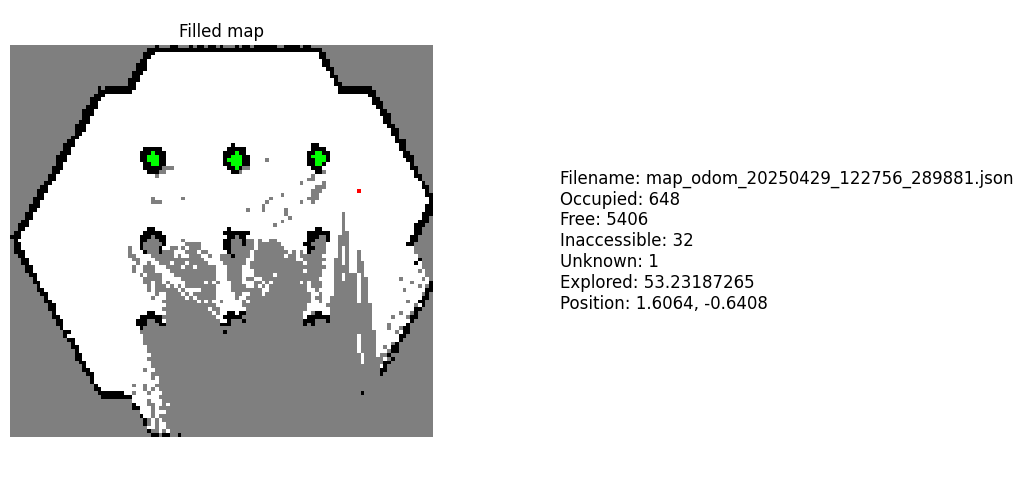

{'header': {'stamp': {'sec': 104, 'nanosec': 523000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 111, 'height': 103, 'origin': {'position': {'x': -2.969823197293329, 'y': -2.591611680906853, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, 100, 100, 100, 100, 100, 100, -1, 100, 100, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,

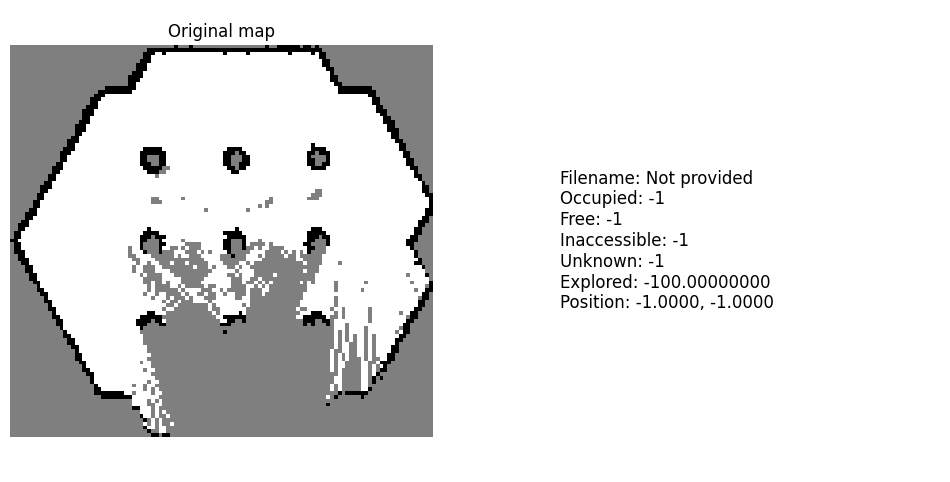

Marking position at world coordinates: (1.6229707988309767, -0.3863109708729793)
Converted to pixel coordinates: (91, 44)
explored %f not explored %f 0.5636315927578064 0.4363684072421936


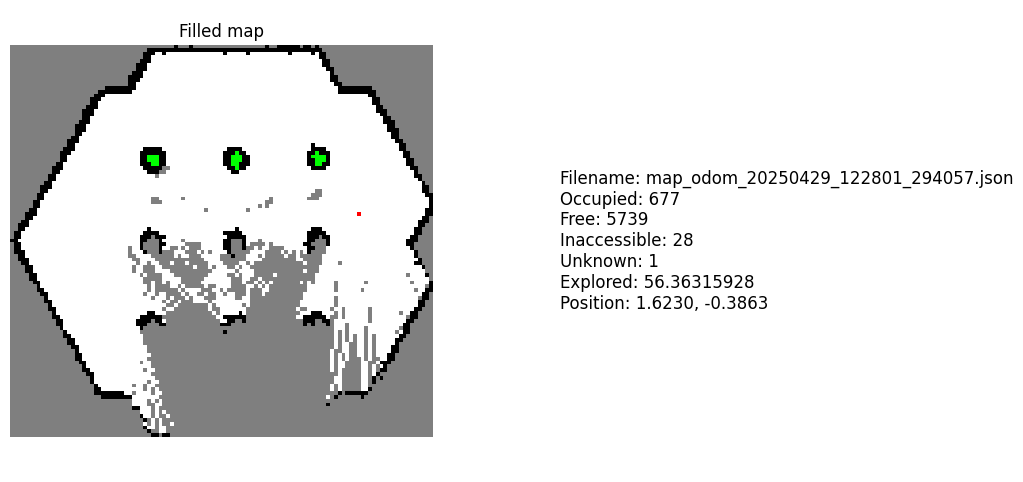

{'header': {'stamp': {'sec': 106, 'nanosec': 732000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 111, 'height': 103, 'origin': {'position': {'x': -2.969823197293329, 'y': -2.591611680906853, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, 100, 100, 100, 100, 100, 100, -1, 100, 100, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,

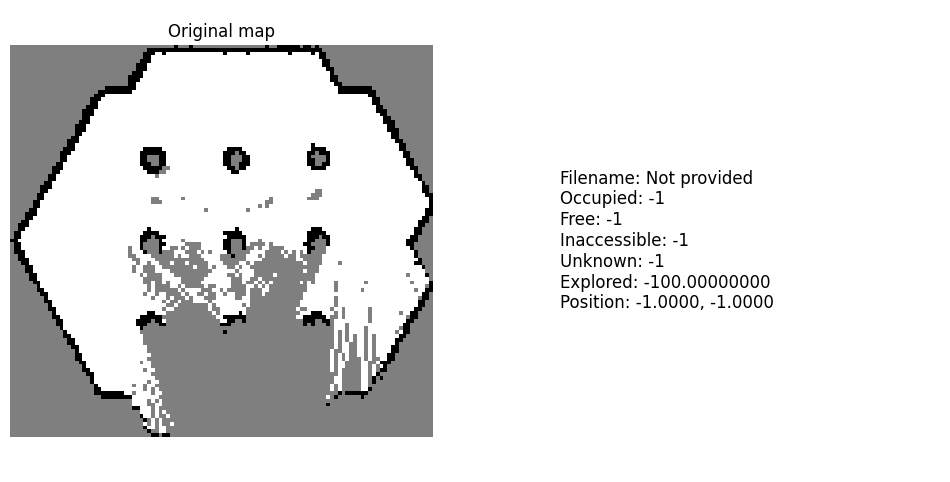

Marking position at world coordinates: (1.6321057742613867, -0.1756518217274478)
Converted to pixel coordinates: (92, 48)
explored %f not explored %f 0.5636315927578064 0.4363684072421936


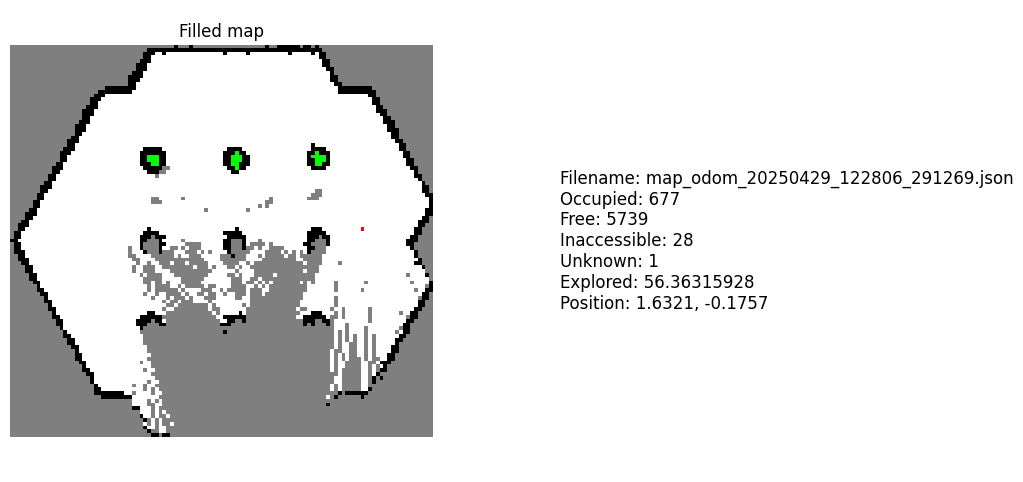

{'header': {'stamp': {'sec': 108, 'nanosec': 962000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 111, 'height': 103, 'origin': {'position': {'x': -2.969823197293329, 'y': -2.591611680906853, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, -1, 100, -1, -1, 100, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, 100, 100, 100, 100, 100, 100, -1, 100, 100, 100, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100

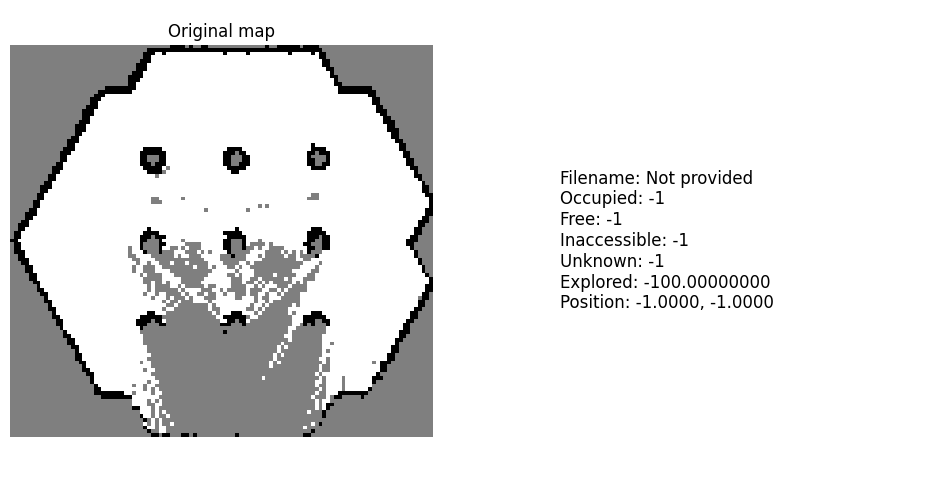

Marking position at world coordinates: (1.646880296481448, 0.05181236247198227)
Converted to pixel coordinates: (92, 52)
explored %f not explored %f 0.5899588909297647 0.4100411090702353


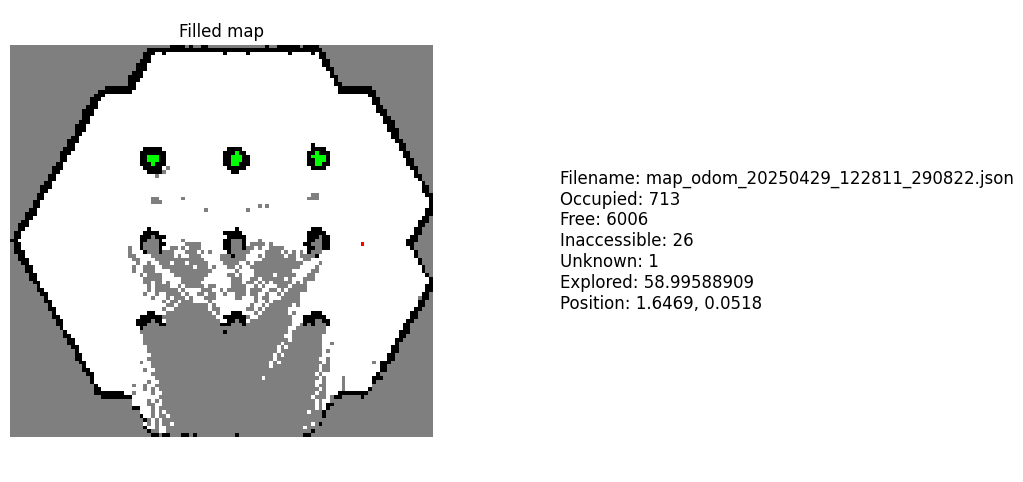

{'header': {'stamp': {'sec': 111, 'nanosec': 364000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 111, 'height': 103, 'origin': {'position': {'x': -2.969823197293329, 'y': -2.591611680906853, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, -1, 100, -1, -1, 100, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, 100, 100, 100, 100, 100, 100, -1, 100, 100, 100, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100

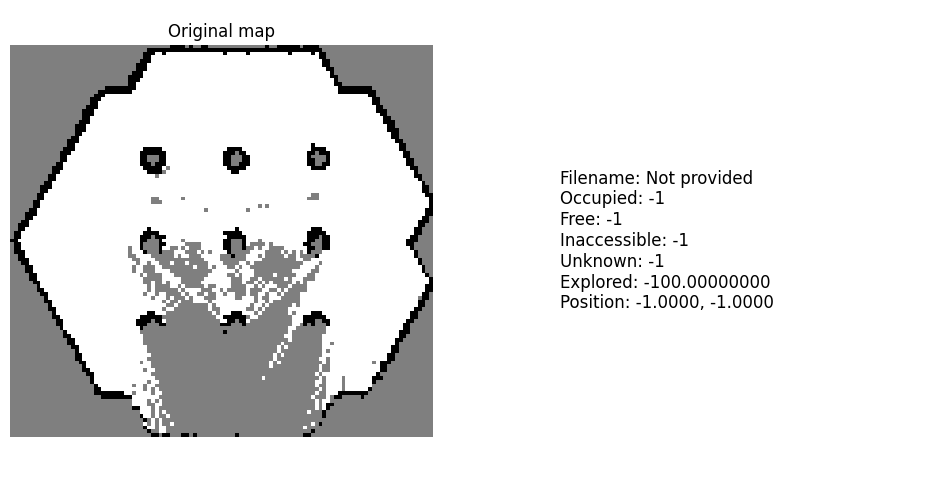

Marking position at world coordinates: (1.6677807906670885, 0.2821473638584512)
Converted to pixel coordinates: (92, 57)
explored %f not explored %f 0.5899588909297647 0.4100411090702353


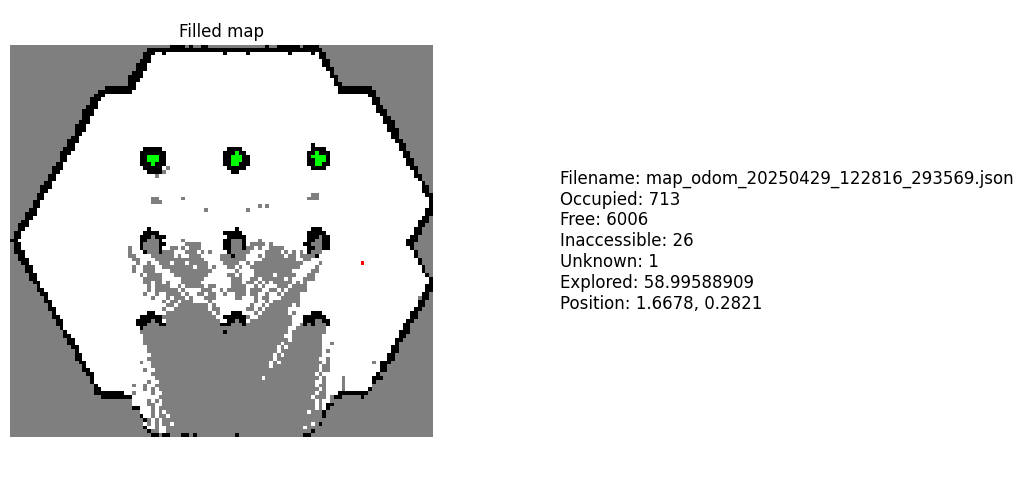

{'header': {'stamp': {'sec': 113, 'nanosec': 575000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 111, 'height': 103, 'origin': {'position': {'x': -2.969823197293329, 'y': -2.6001939281111426, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, 100, -1, 100, -1, 100, 100, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100

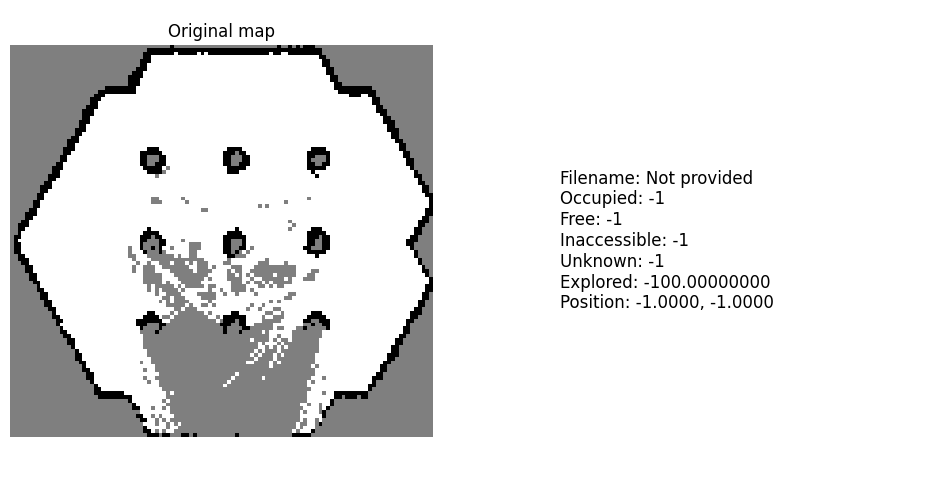

Marking position at world coordinates: (1.6928459291039712, 0.5189613014214983)
Converted to pixel coordinates: (93, 62)
explored %f not explored %f 0.6203970961252515 0.3796029038747485


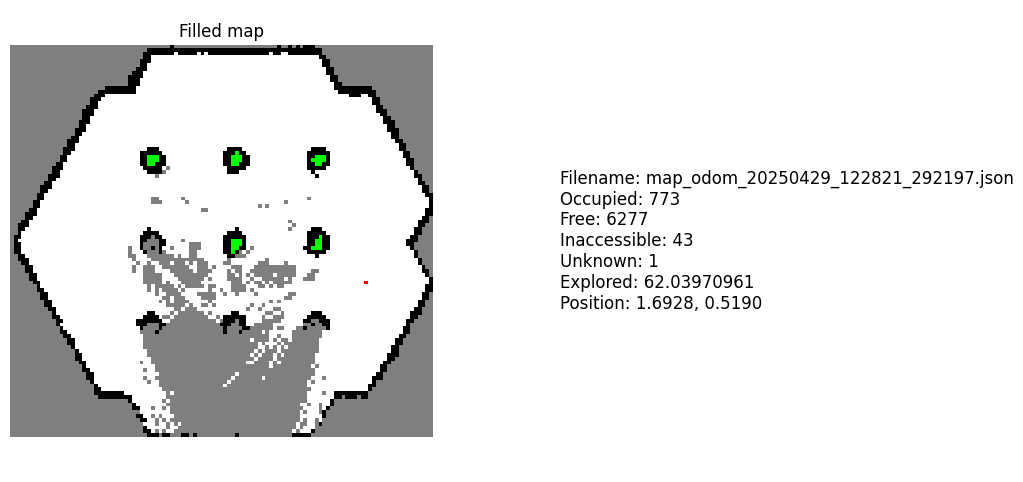

{'header': {'stamp': {'sec': 115, 'nanosec': 786000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 111, 'height': 103, 'origin': {'position': {'x': -2.969823197293329, 'y': -2.6001939281111426, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, 100, -1, 100, -1, 100, 100, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100

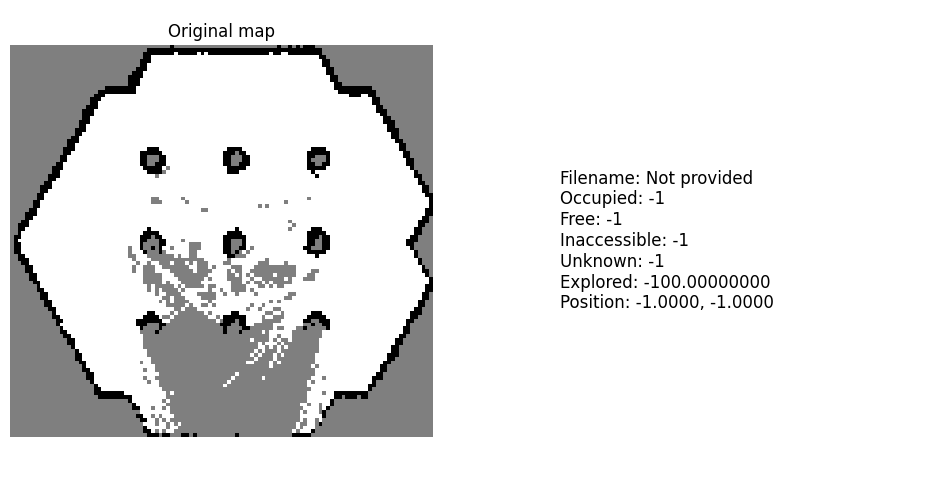

Marking position at world coordinates: (1.725450300381067, 0.7342692805413791)
Converted to pixel coordinates: (93, 66)
explored %f not explored %f 0.6203970961252515 0.3796029038747485


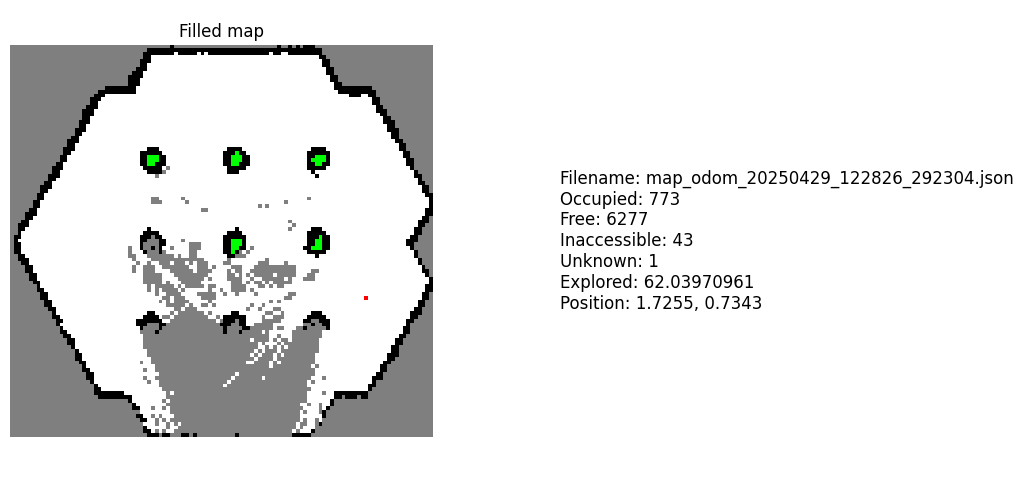

{'header': {'stamp': {'sec': 118, 'nanosec': 190000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 111, 'height': 103, 'origin': {'position': {'x': -2.969823197293329, 'y': -2.6001939281111426, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, 100, -1, 100, -1, 100, 100, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100

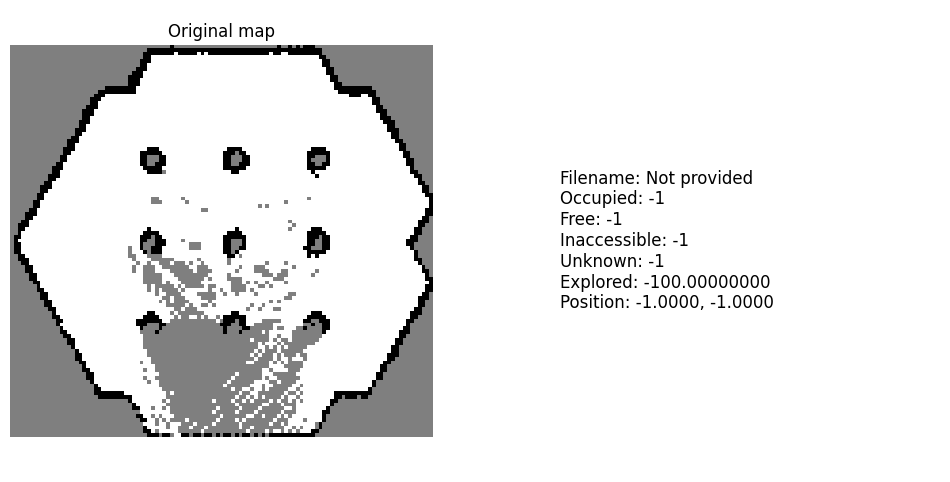

Marking position at world coordinates: (1.7749346503558636, 0.9567961842325614)
Converted to pixel coordinates: (94, 71)
explored %f not explored %f 0.6453249365870725 0.35467506341292754


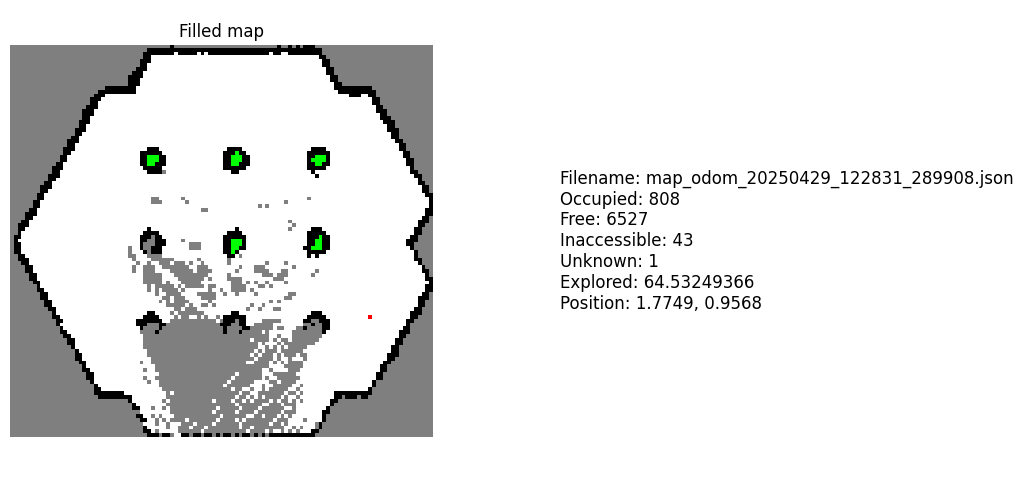

{'header': {'stamp': {'sec': 120, 'nanosec': 603000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 111, 'height': 103, 'origin': {'position': {'x': -2.969823197293329, 'y': -2.6001939281111426, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, 100, -1, 100, -1, 100, 100, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100

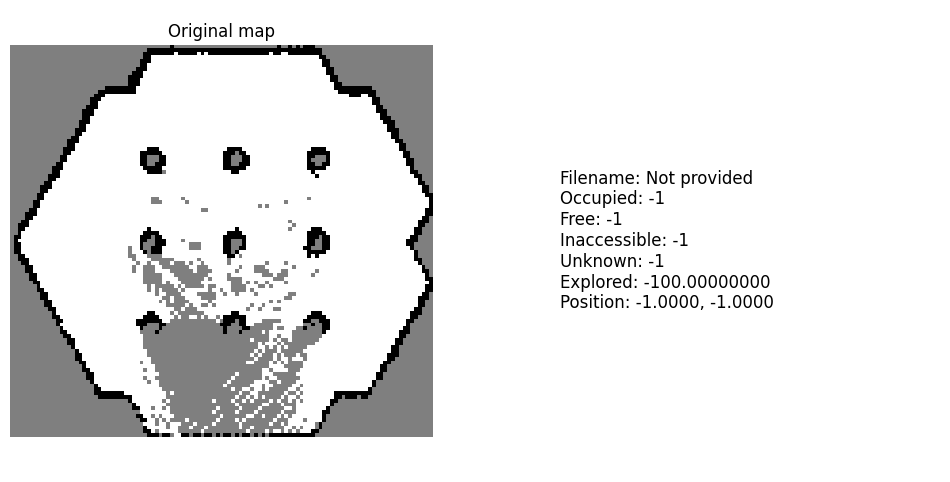

Marking position at world coordinates: (1.806439252485709, 1.0778626901534363)
Converted to pixel coordinates: (95, 73)
explored %f not explored %f 0.6453249365870725 0.35467506341292754


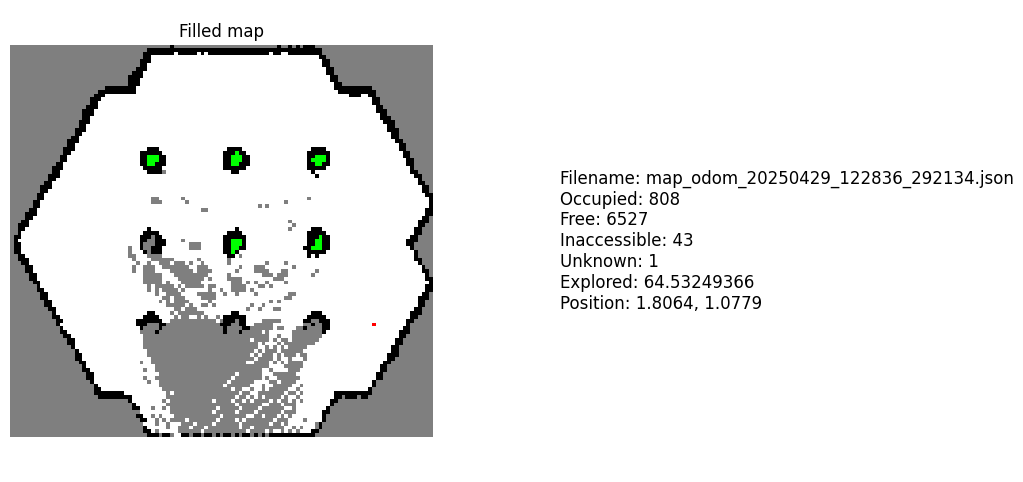

{'header': {'stamp': {'sec': 122, 'nanosec': 810000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 111, 'height': 103, 'origin': {'position': {'x': -2.969823197293329, 'y': -2.6001939281111426, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, 100, -1, 100, -1, 100, 100, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100

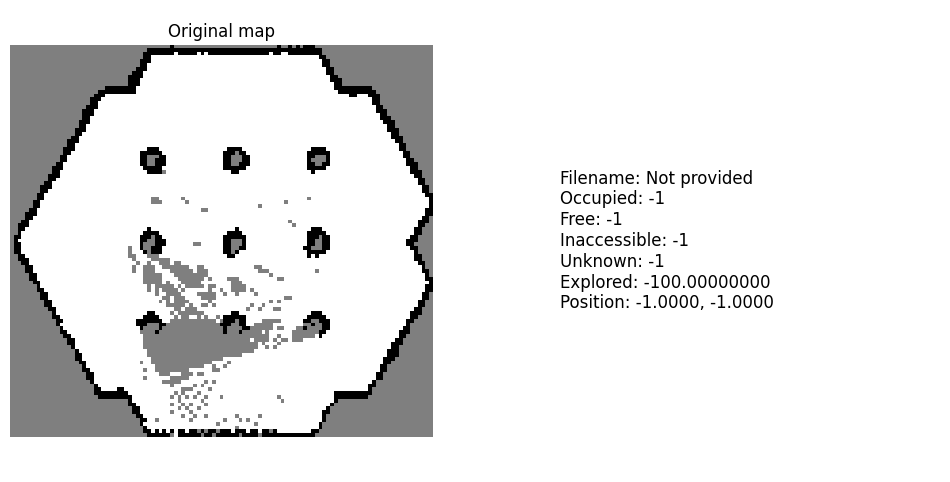

Marking position at world coordinates: (1.722406715684678, 1.0990083936467583)
Converted to pixel coordinates: (93, 73)
explored %f not explored %f 0.6964051430070848 0.3035948569929152


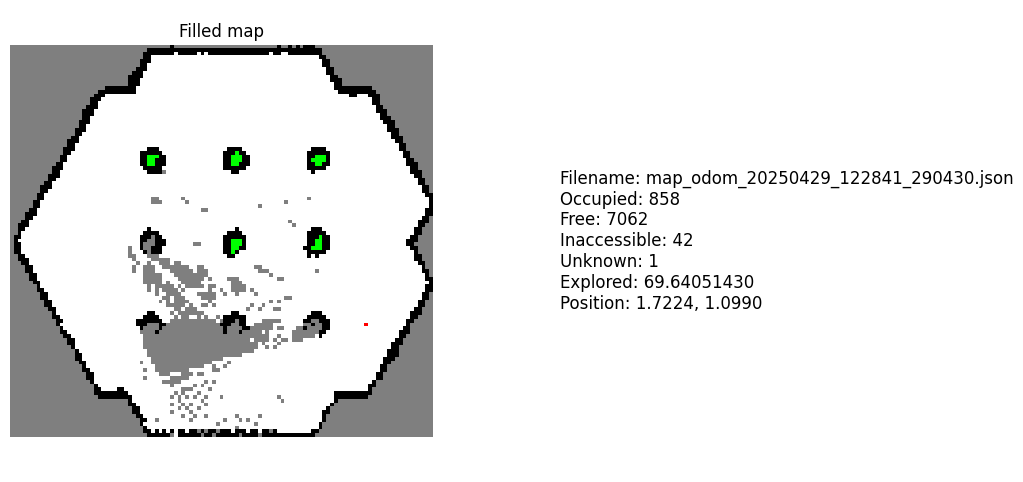

{'header': {'stamp': {'sec': 125, 'nanosec': 223000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 111, 'height': 103, 'origin': {'position': {'x': -2.969823197293329, 'y': -2.6001939281111426, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, 100, -1, 100, -1, 100, 100, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100

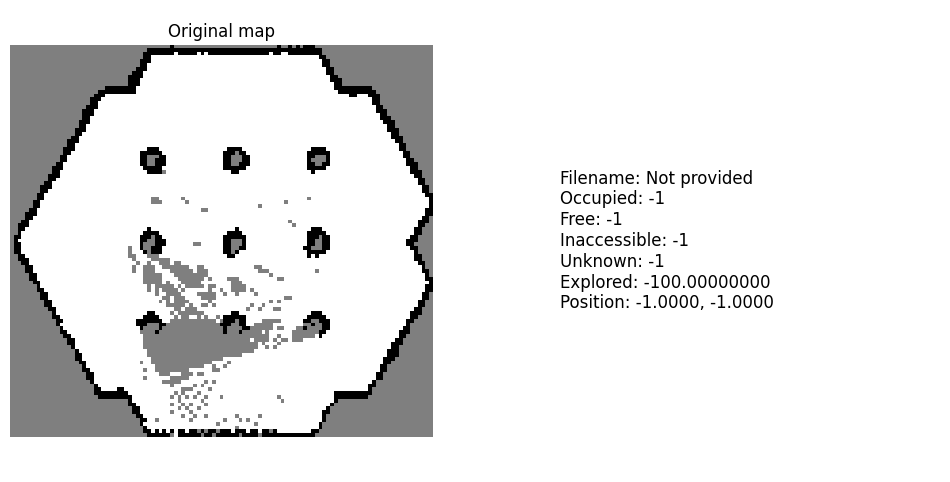

Marking position at world coordinates: (1.5006630300671204, 1.2104496848960262)
Converted to pixel coordinates: (89, 76)
explored %f not explored %f 0.6964051430070848 0.3035948569929152


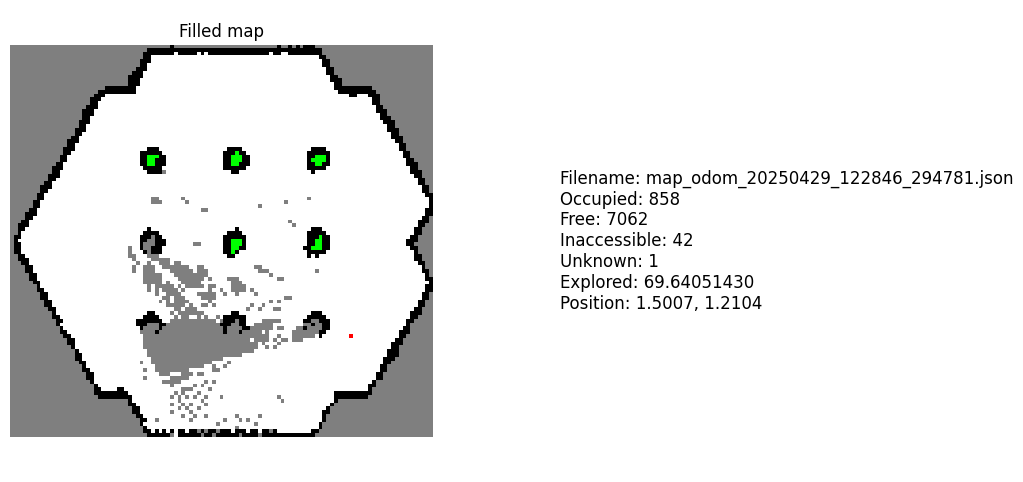

{'header': {'stamp': {'sec': 127, 'nanosec': 630000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 111, 'height': 103, 'origin': {'position': {'x': -2.969823197293329, 'y': -2.6001939281111426, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, 100, -1, 100, -1, 100, 100, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100

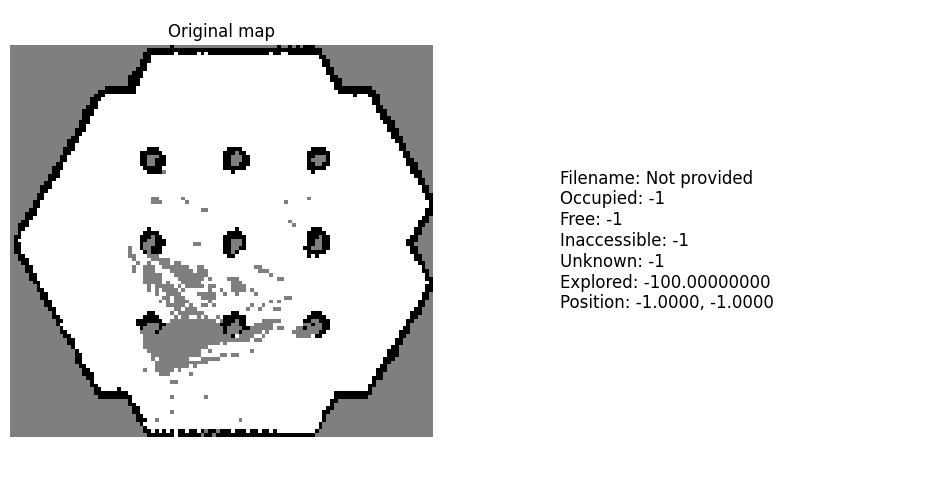

Marking position at world coordinates: (1.2936094066197157, 1.346323052154763)
Converted to pixel coordinates: (85, 78)
explored %f not explored %f 0.7091751946120878 0.2908248053879122


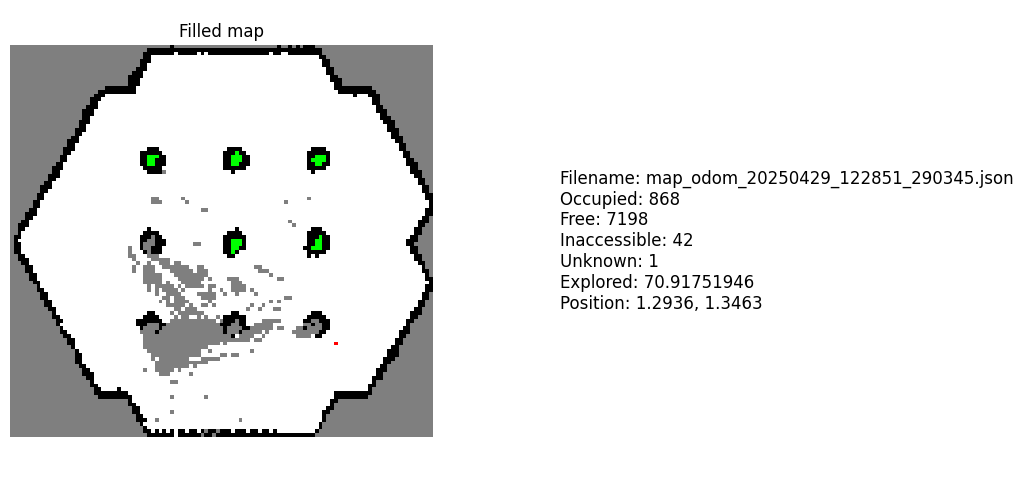

{'header': {'stamp': {'sec': 130, 'nanosec': 49000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 111, 'height': 103, 'origin': {'position': {'x': -2.969823197293329, 'y': -2.6001939281111426, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, 100, -1, 100, -1, 100, 100, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,

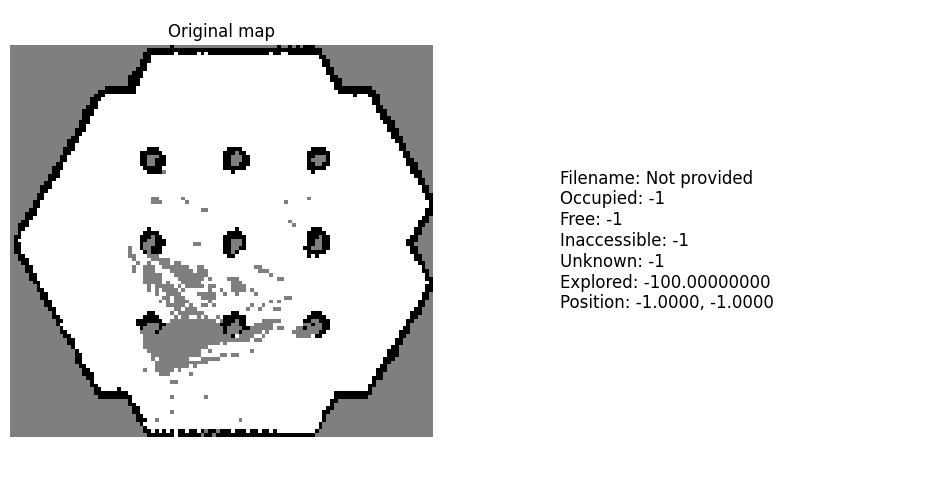

Marking position at world coordinates: (1.1379602301461123, 1.5080798439770353)
Converted to pixel coordinates: (82, 82)
explored %f not explored %f 0.7091751946120878 0.2908248053879122


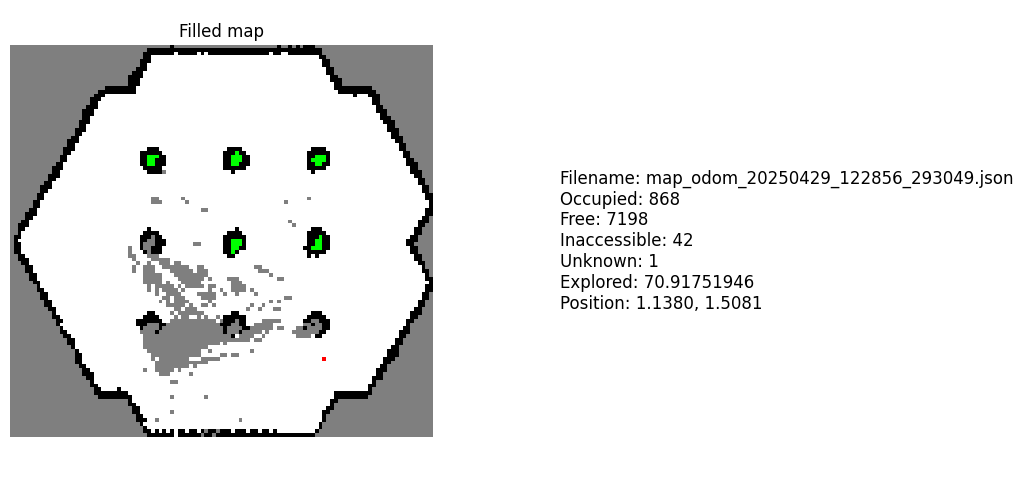

{'header': {'stamp': {'sec': 132, 'nanosec': 254000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 111, 'height': 103, 'origin': {'position': {'x': -2.969823197293329, 'y': -2.6001939281111426, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, 100, -1, 100, -1, 100, 100, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100

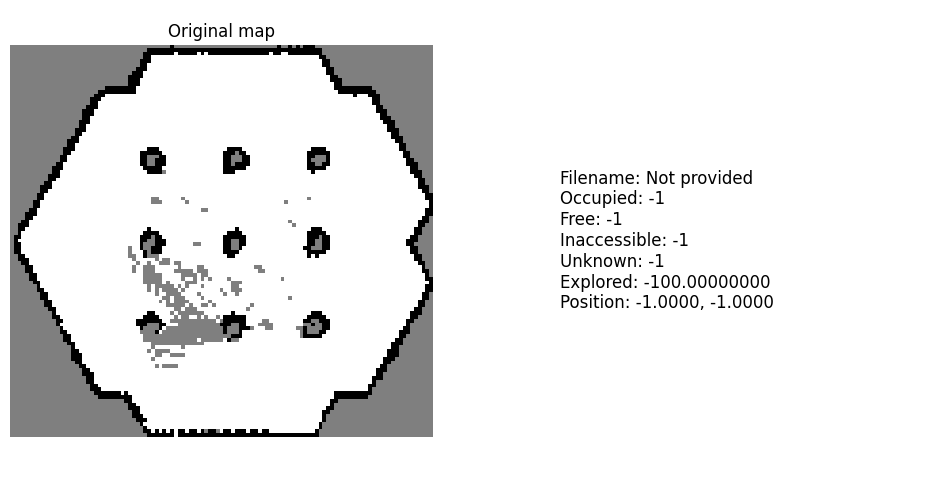

Marking position at world coordinates: (0.9711957481124636, 1.6518499308479457)
Converted to pixel coordinates: (78, 85)
explored %f not explored %f 0.7262310854543864 0.2737689145456136


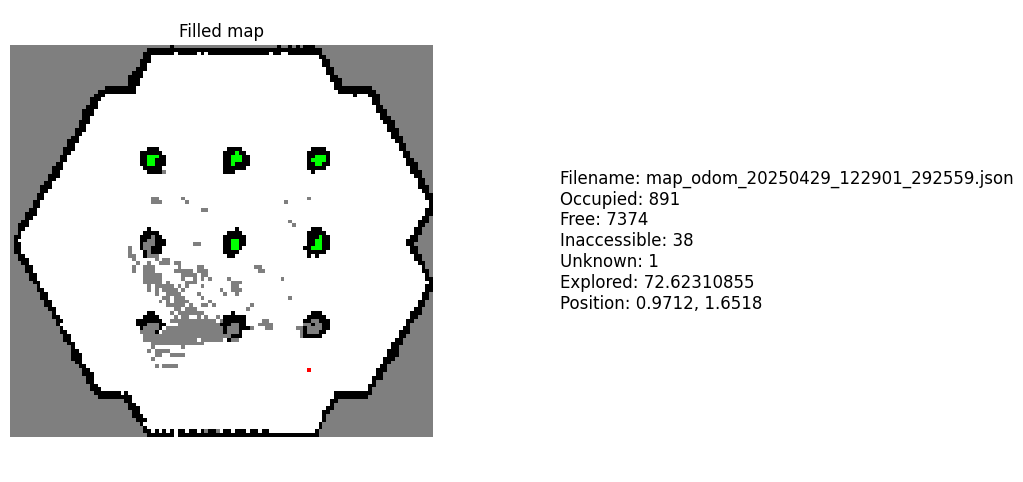

{'header': {'stamp': {'sec': 134, 'nanosec': 461000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 111, 'height': 103, 'origin': {'position': {'x': -2.969823197293329, 'y': -2.6001939281111426, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, 100, -1, 100, -1, 100, 100, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100

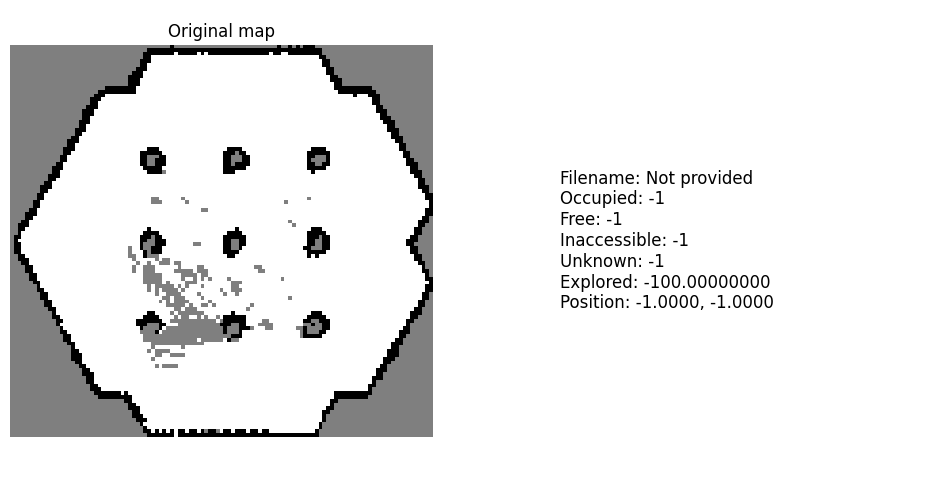

Marking position at world coordinates: (0.7564773917500736, 1.6764920483691343)
Converted to pixel coordinates: (74, 85)
explored %f not explored %f 0.7262310854543864 0.2737689145456136


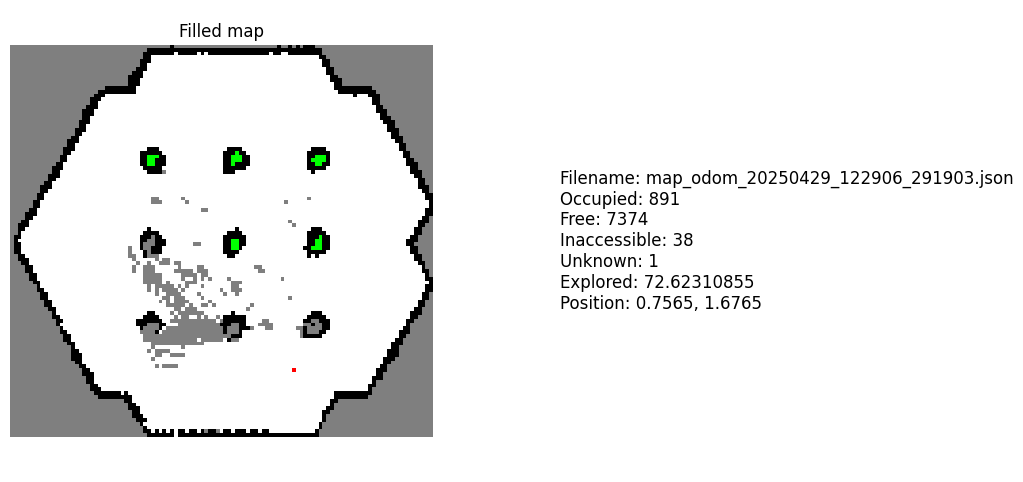

{'header': {'stamp': {'sec': 136, 'nanosec': 670000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 111, 'height': 103, 'origin': {'position': {'x': -2.969823197293329, 'y': -2.6001939281111426, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, 100, -1, 100, -1, 100, 100, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100

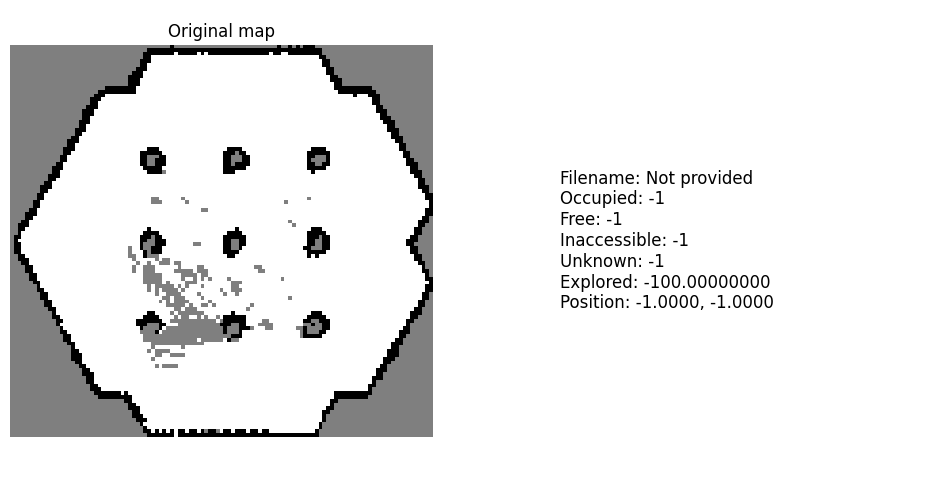

Marking position at world coordinates: (0.5457640540725595, 1.684068364078279)
Converted to pixel coordinates: (70, 85)
explored %f not explored %f 0.7262310854543864 0.2737689145456136


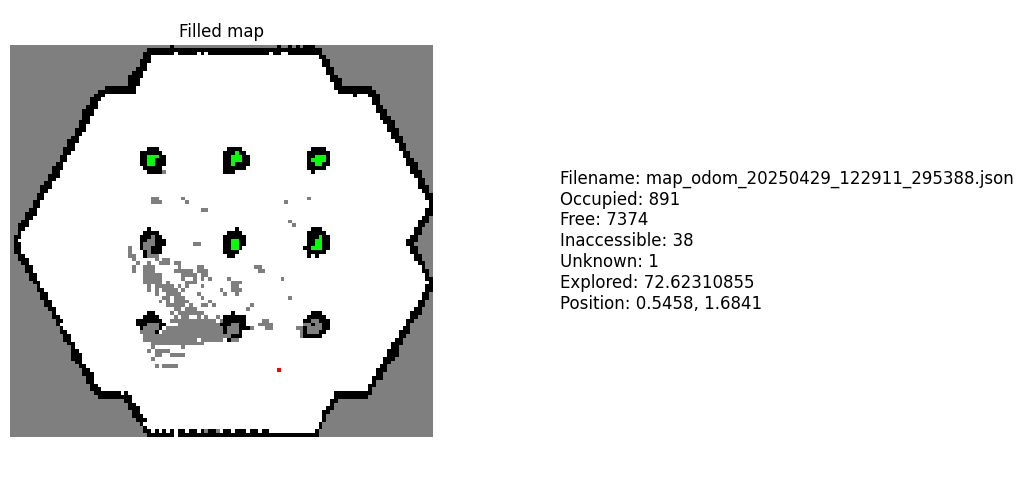

{'header': {'stamp': {'sec': 138, 'nanosec': 883000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 111, 'height': 103, 'origin': {'position': {'x': -2.969823197293329, 'y': -2.6001939281111426, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, 100, -1, 100, -1, 100, 100, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100

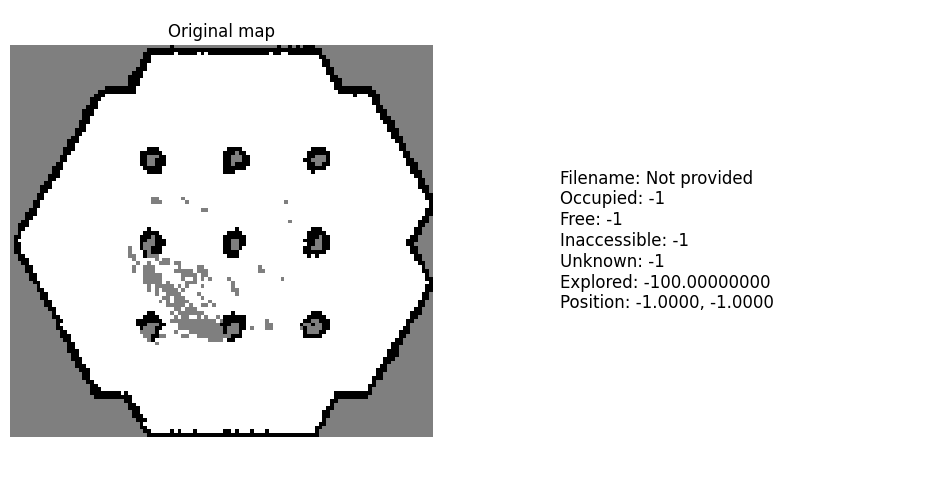

Marking position at world coordinates: (0.32476649525385315, 1.6893190689910929)
Converted to pixel coordinates: (65, 85)
explored %f not explored %f 0.9779585410653372 0.022041458934662805


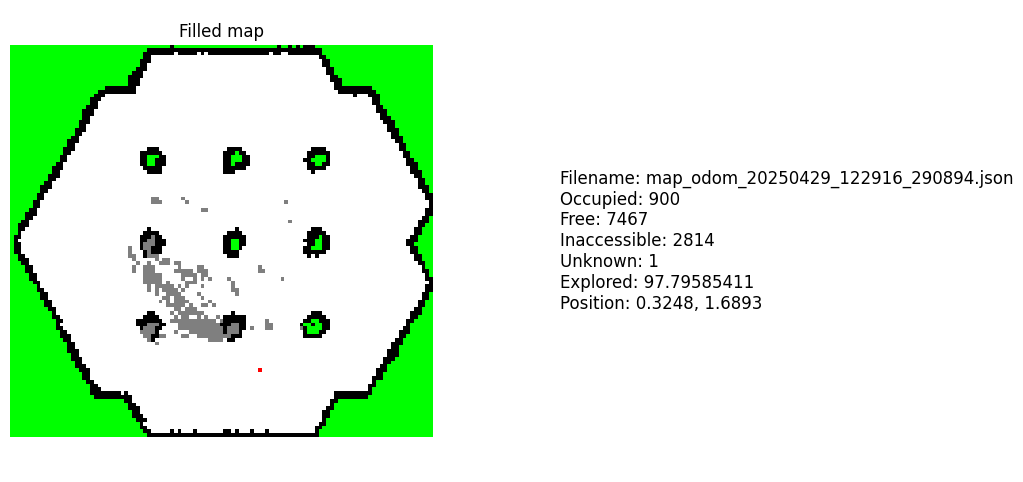

{'header': {'stamp': {'sec': 141, 'nanosec': 95000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 111, 'height': 103, 'origin': {'position': {'x': -2.969823197293329, 'y': -2.6001939281111426, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, 100, -1, 100, -1, 100, 100, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,

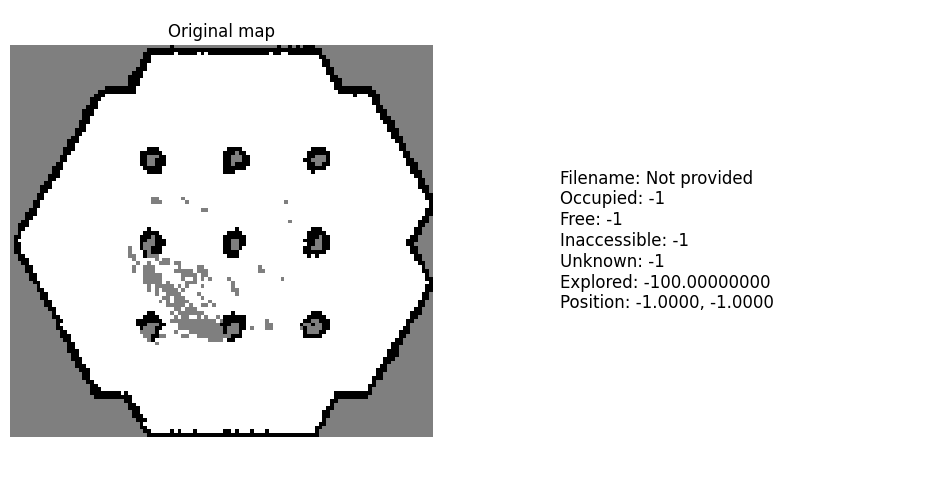

Marking position at world coordinates: (0.10372691765237053, 1.6927467930592626)
Converted to pixel coordinates: (61, 85)
explored %f not explored %f 0.9779585410653372 0.022041458934662805


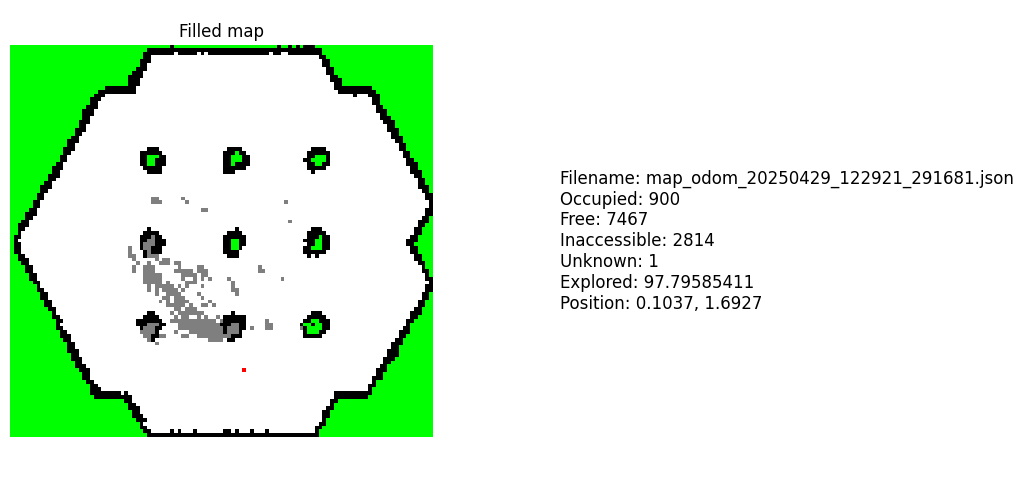

{'header': {'stamp': {'sec': 143, 'nanosec': 98000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 111, 'height': 103, 'origin': {'position': {'x': -2.969823197293329, 'y': -2.6001939281111426, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, 100, -1, 100, -1, 100, 100, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,

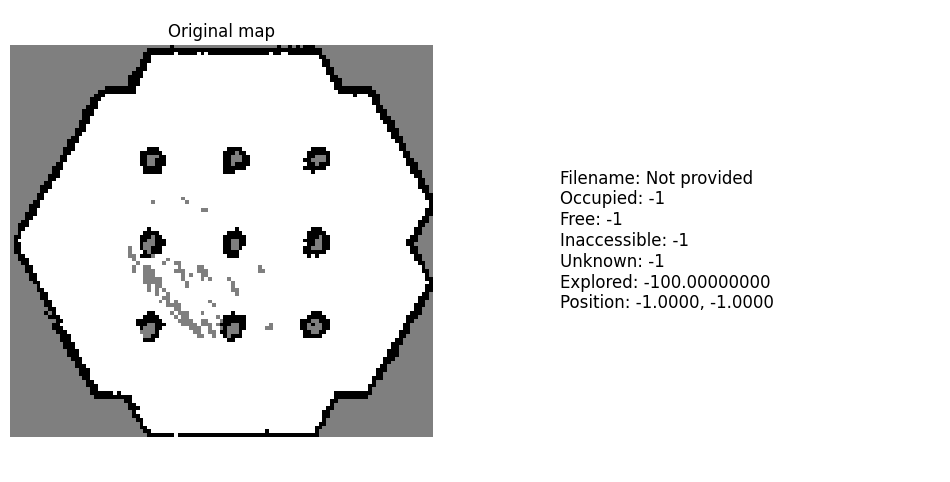

Marking position at world coordinates: (-0.10373199916258433, 1.6949252056819795)
Converted to pixel coordinates: (57, 85)
explored %f not explored %f 0.7476602816408642 0.2523397183591358


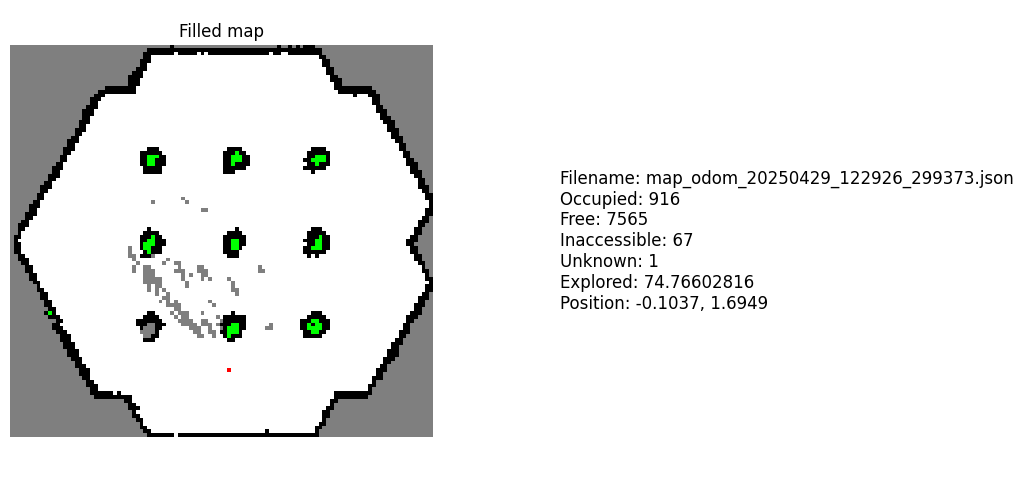

{'header': {'stamp': {'sec': 145, 'nanosec': 101000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 111, 'height': 103, 'origin': {'position': {'x': -2.969823197293329, 'y': -2.6001939281111426, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, 100, -1, 100, -1, 100, 100, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100

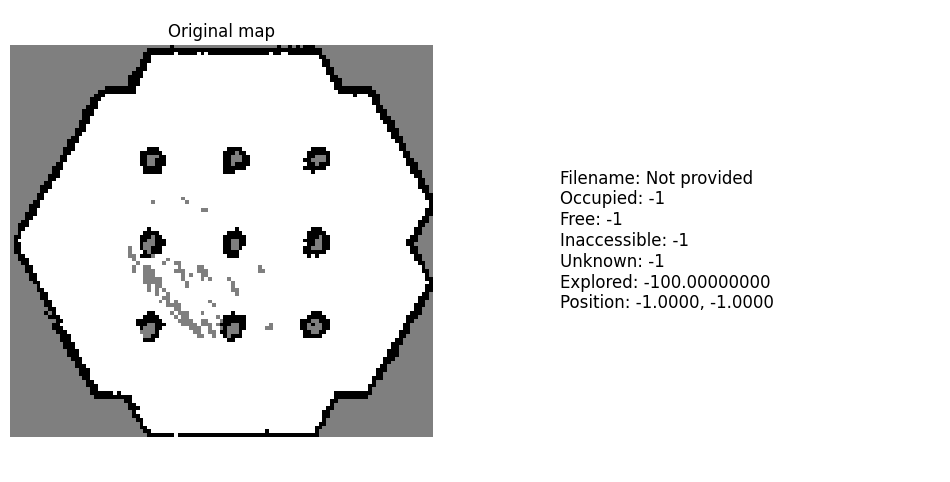

Marking position at world coordinates: (-0.30444301829809056, 1.6973356950410463)
Converted to pixel coordinates: (53, 85)
explored %f not explored %f 0.7476602816408642 0.2523397183591358


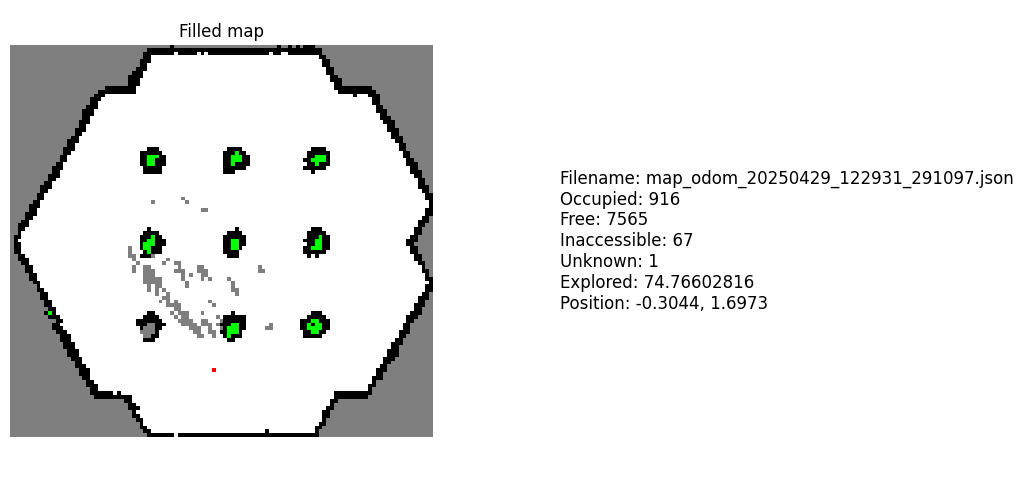

{'header': {'stamp': {'sec': 147, 'nanosec': 511000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 112, 'height': 103, 'origin': {'position': {'x': -2.981074370624633, 'y': -2.6001939281111426, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, -1, 100, 100, 100, 100, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,

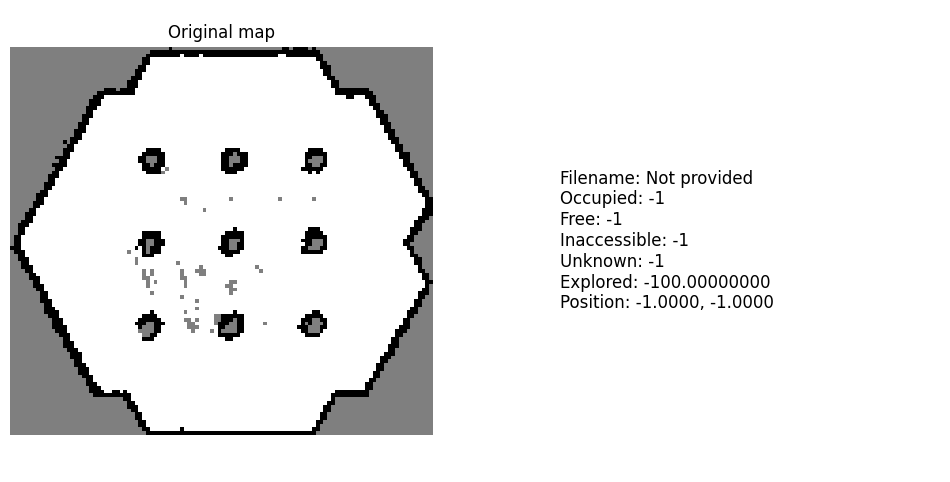

Marking position at world coordinates: (-0.5353231209119235, 1.7118041356081735)
Converted to pixel coordinates: (48, 86)
explored %f not explored %f 0.9934119278779473 0.006588072122052702


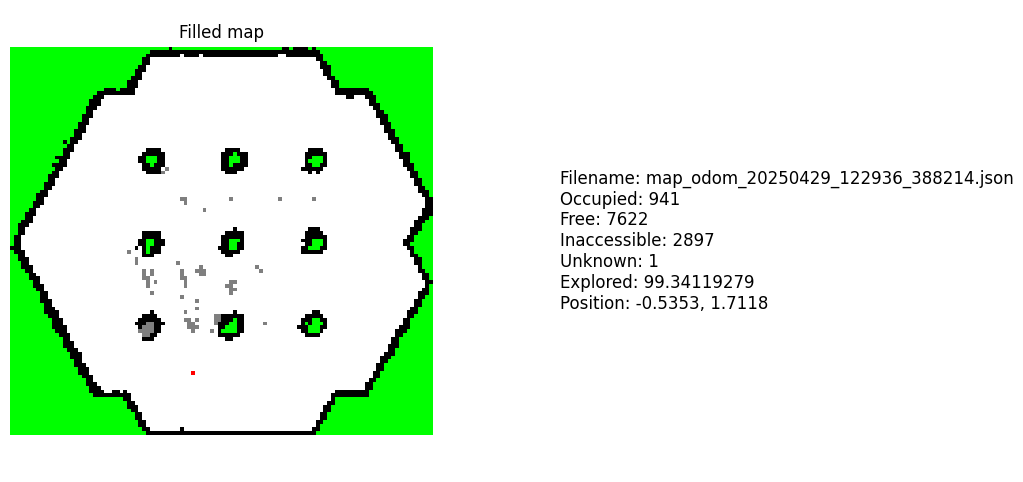

{'header': {'stamp': {'sec': 149, 'nanosec': 522000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 112, 'height': 103, 'origin': {'position': {'x': -2.981074370624633, 'y': -2.6001939281111426, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, -1, 100, 100, 100, 100, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,

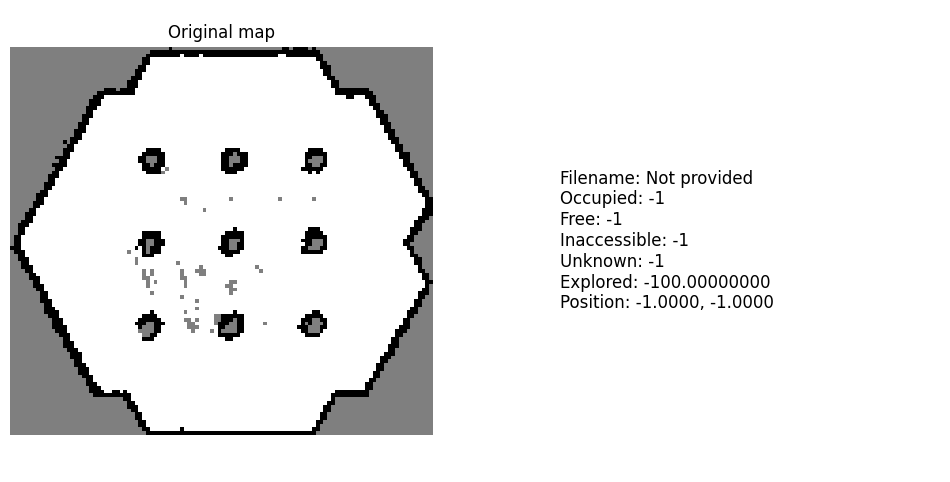

Marking position at world coordinates: (-0.654135390615758, 1.7203485506241405)
Converted to pixel coordinates: (46, 86)
explored %f not explored %f 0.9934119278779473 0.006588072122052702


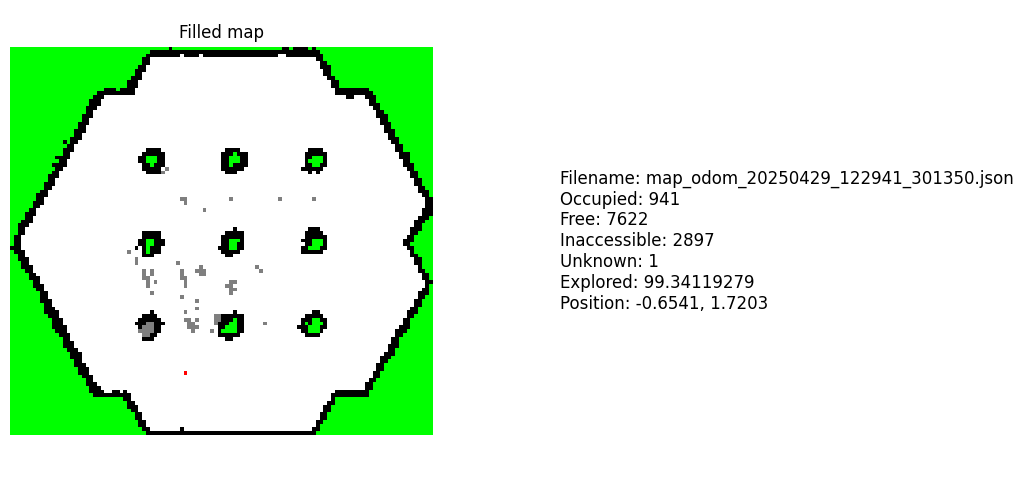

{'header': {'stamp': {'sec': 151, 'nanosec': 342000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 112, 'height': 103, 'origin': {'position': {'x': -2.981074370624633, 'y': -2.6001939281111426, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, -1, 100, 100, 100, 100, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,

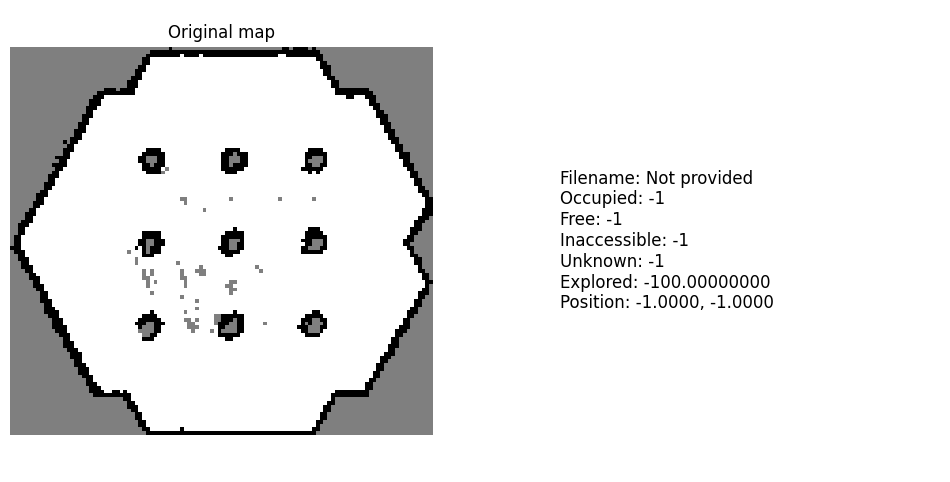

Marking position at world coordinates: (-0.6541987671006503, 1.7203534164703957)
Converted to pixel coordinates: (46, 86)
explored %f not explored %f 0.9934119278779473 0.006588072122052702


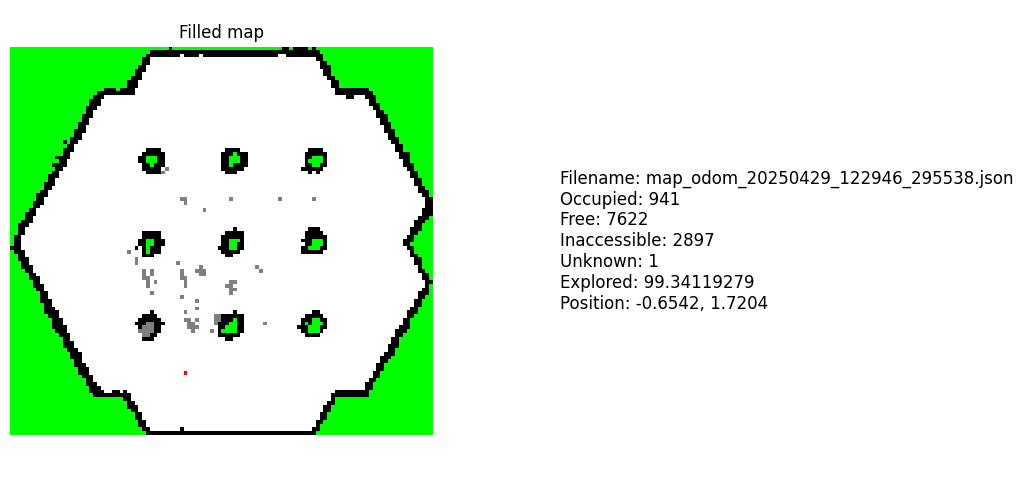

{'header': {'stamp': {'sec': 152, 'nanosec': 954000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 112, 'height': 103, 'origin': {'position': {'x': -2.981074370624633, 'y': -2.6001939281111426, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, -1, 100, 100, 100, 100, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,

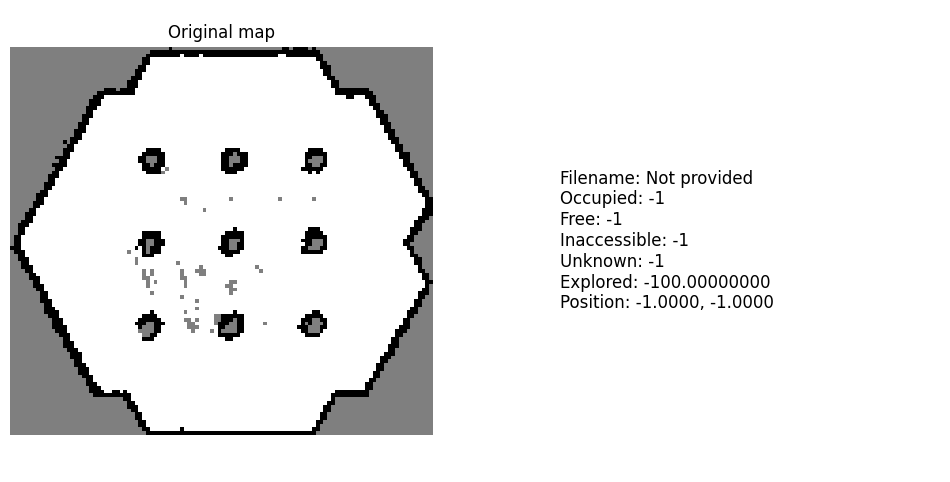

Marking position at world coordinates: (-0.6692150744842962, 1.7179965921879932)
Converted to pixel coordinates: (46, 86)
explored %f not explored %f 0.9934119278779473 0.006588072122052702


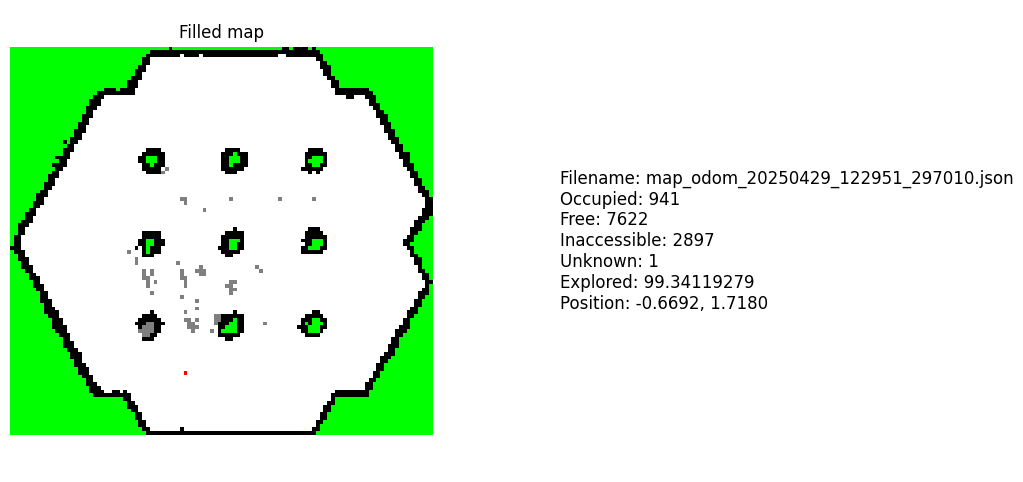

{'header': {'stamp': {'sec': 154, 'nanosec': 352000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 113, 'height': 103, 'origin': {'position': {'x': -3.0400363335472136, 'y': -2.6001939281111426, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, 100, 100, -1, 100, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, 100, 10

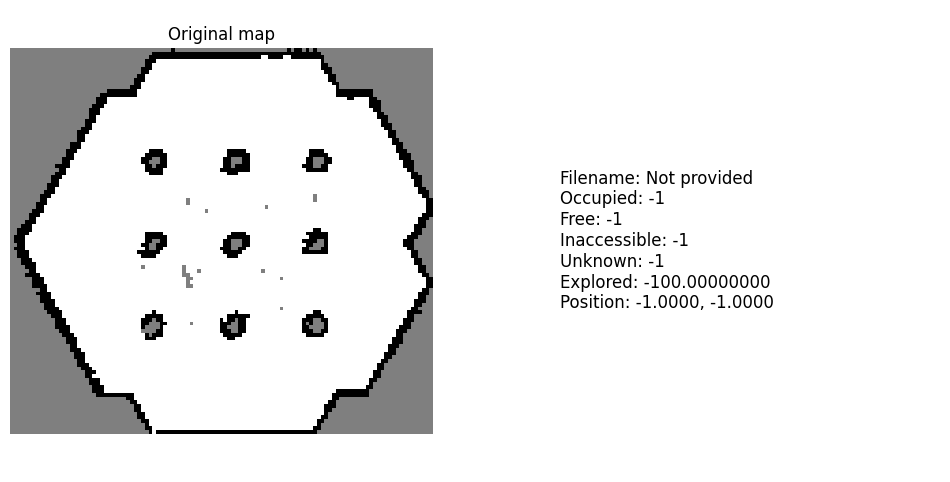

Marking position at world coordinates: (-0.6983793023960654, 1.685360787202033)
Converted to pixel coordinates: (46, 85)
explored %f not explored %f 0.7473150614313945 0.2526849385686055


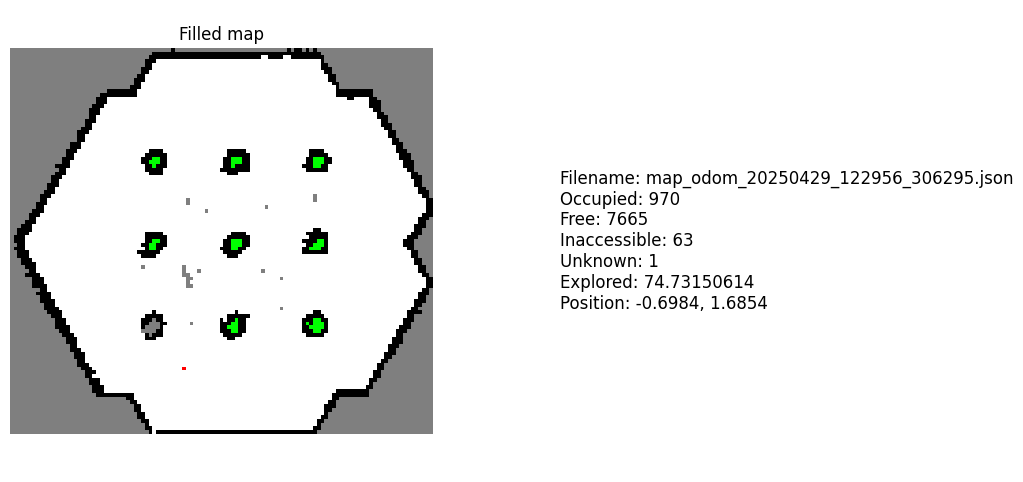

{'header': {'stamp': {'sec': 155, 'nanosec': 967000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 113, 'height': 103, 'origin': {'position': {'x': -3.051673910746274, 'y': -2.6001939281111426, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, 100, 100, 100, -1, 100, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, 100, 10

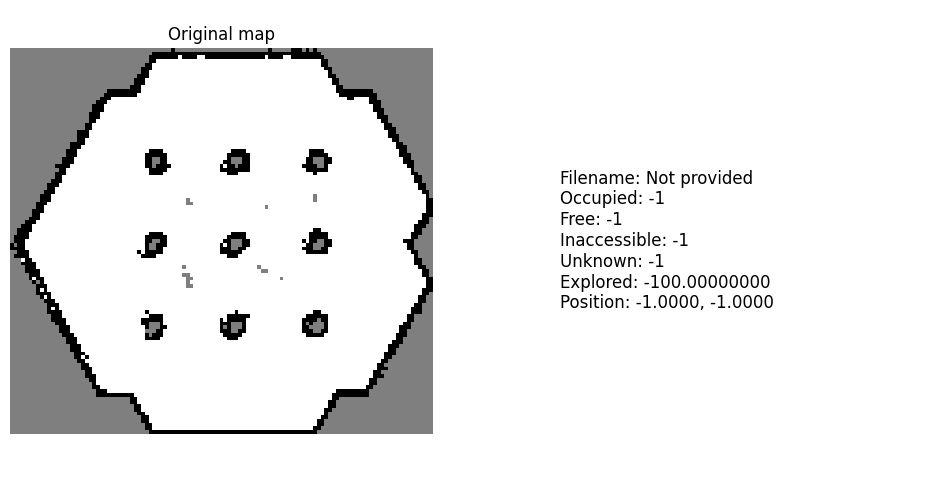

Marking position at world coordinates: (-0.7240958073466768, 1.5319836310592243)
Converted to pixel coordinates: (46, 82)
explored %f not explored %f 0.7485179139101298 0.2514820860898702


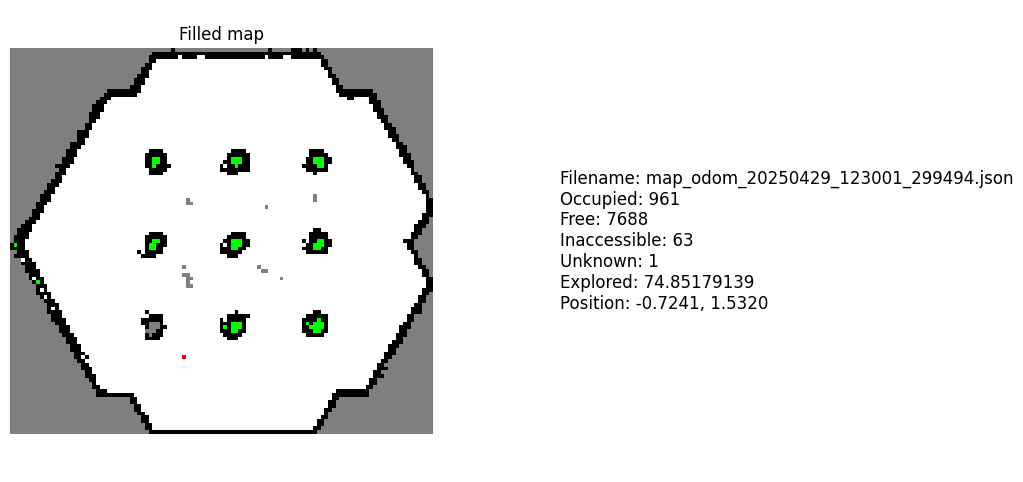

{'header': {'stamp': {'sec': 157, 'nanosec': 564000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 113, 'height': 103, 'origin': {'position': {'x': -3.051673910746274, 'y': -2.6001939281111426, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, 100, 100, 100, -1, 100, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, 100, 10

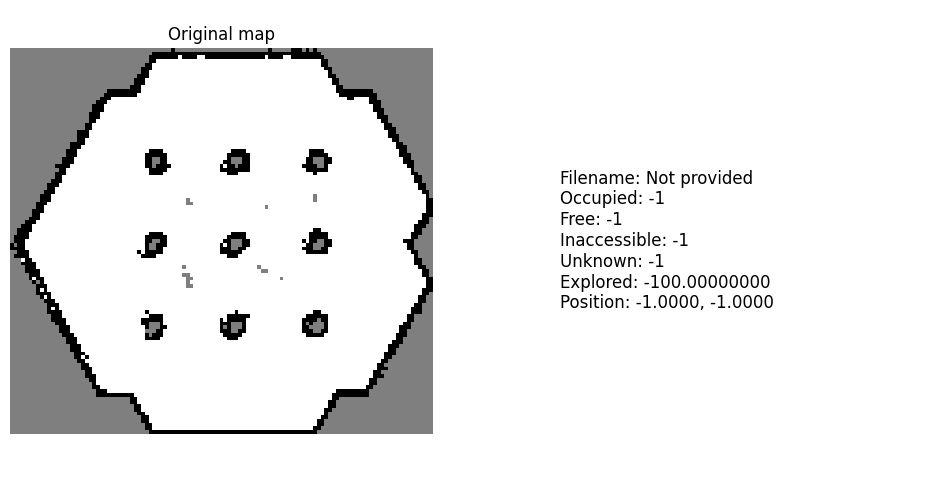

Marking position at world coordinates: (-0.6850448192620602, 1.380964966767603)
Converted to pixel coordinates: (47, 79)
explored %f not explored %f 0.7485179139101298 0.2514820860898702


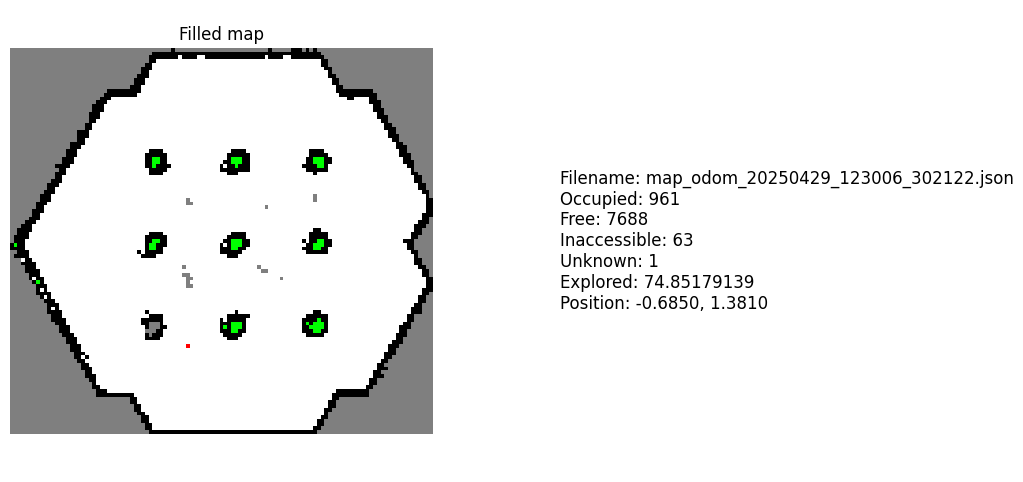

{'header': {'stamp': {'sec': 159, 'nanosec': 180000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 113, 'height': 103, 'origin': {'position': {'x': -3.051673910746274, 'y': -2.6001939281111426, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, 100, 100, 100, -1, 100, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, 100, 10

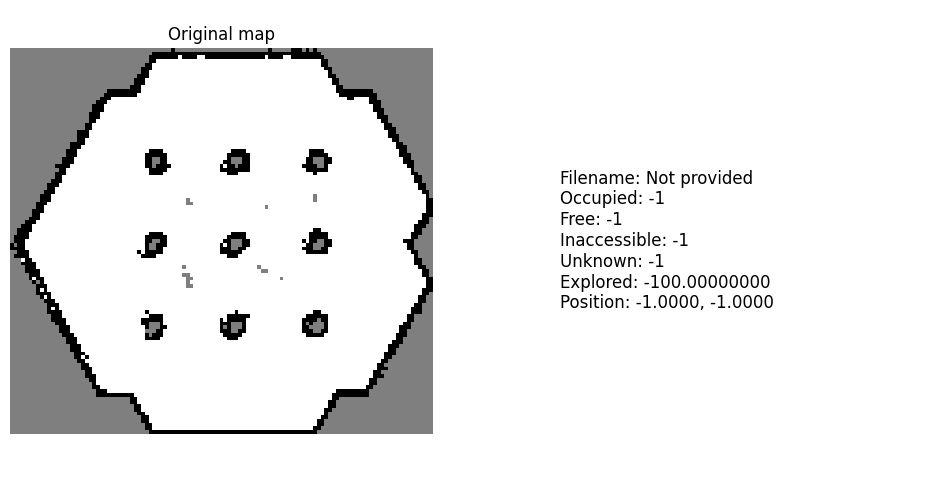

Marking position at world coordinates: (-0.6265153958241176, 1.217805798486578)
Converted to pixel coordinates: (48, 76)
explored %f not explored %f 0.7485179139101298 0.2514820860898702


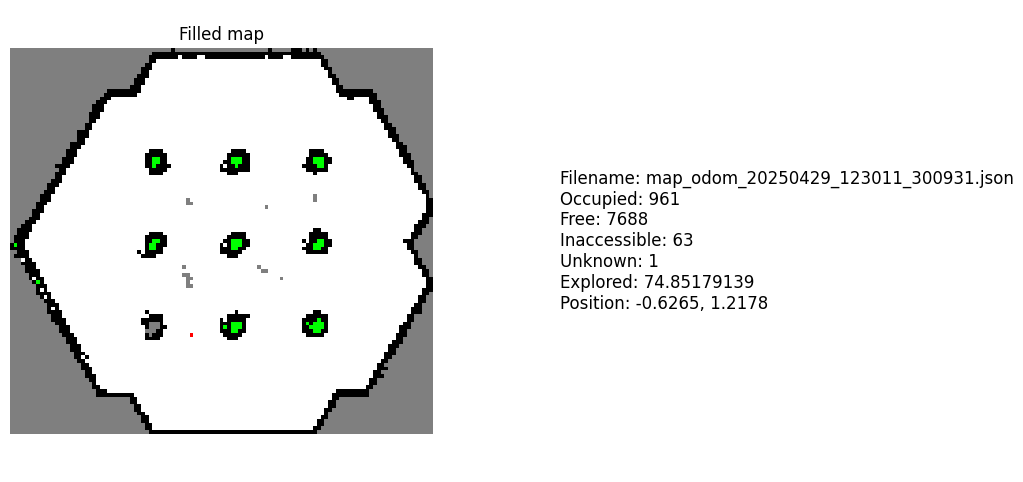

{'header': {'stamp': {'sec': 160, 'nanosec': 787000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 114, 'height': 103, 'origin': {'position': {'x': -3.0930613427857123, 'y': -2.6001939281111426, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, 100, -1, 100, 100, -1, 100, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100

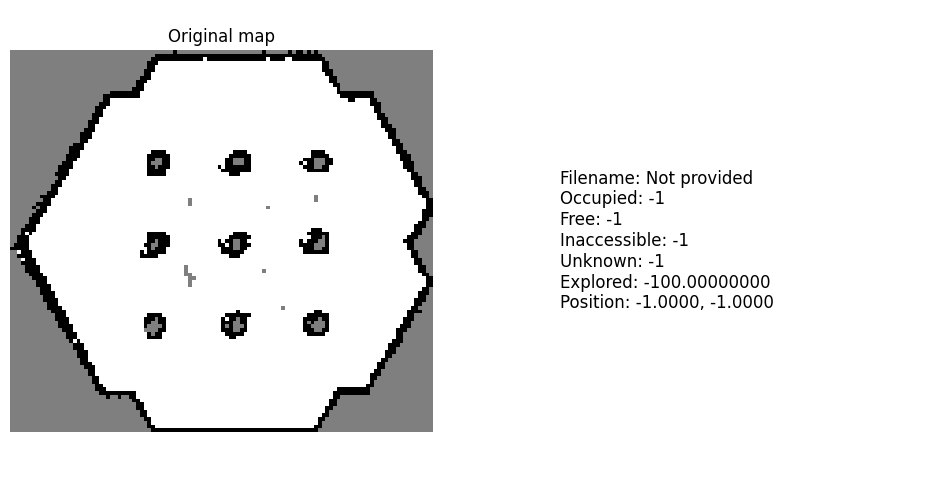

Marking position at world coordinates: (-0.5721570722238335, 1.0820803850117842)
Converted to pixel coordinates: (50, 73)
explored %f not explored %f 0.743655254641458 0.256344745358542


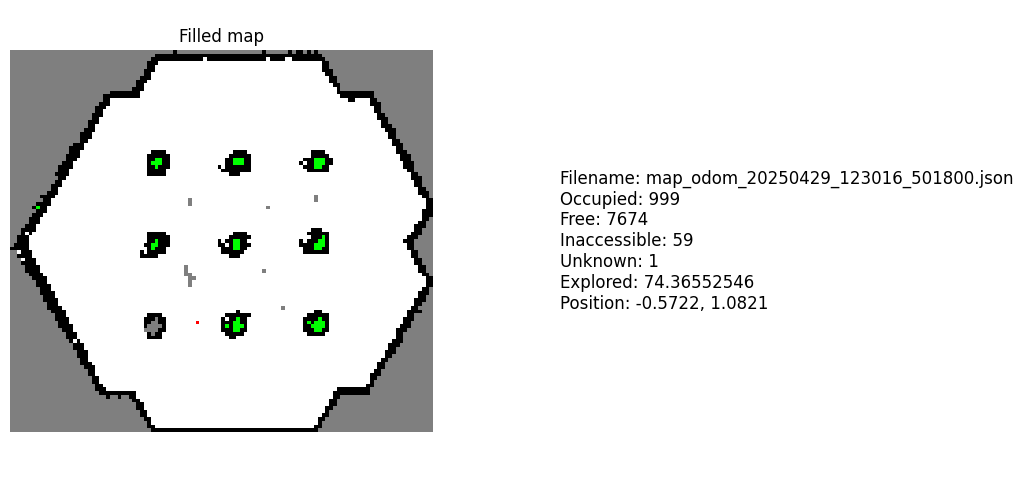

{'header': {'stamp': {'sec': 162, 'nanosec': 396000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 114, 'height': 103, 'origin': {'position': {'x': -3.0930613427857123, 'y': -2.6001939281111426, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, 100, -1, 100, 100, -1, 100, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100

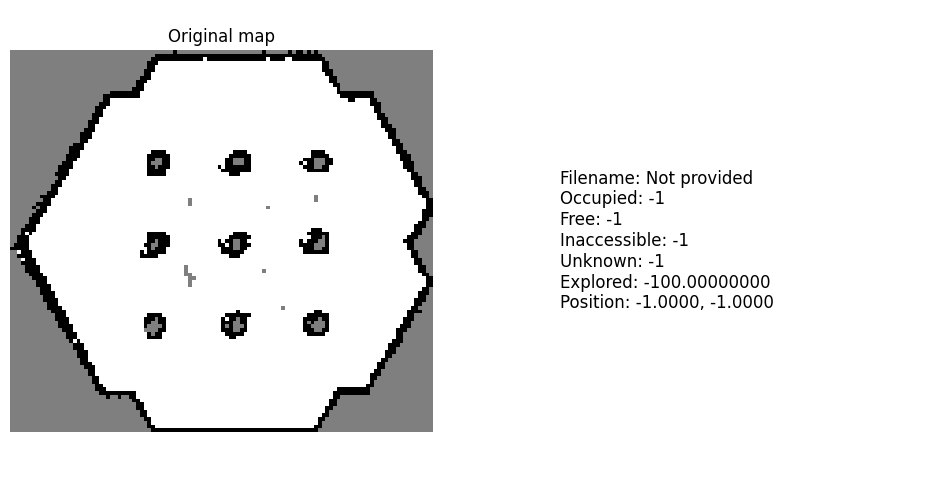

Marking position at world coordinates: (-0.49305523867868, 0.9249330862045311)
Converted to pixel coordinates: (52, 70)
explored %f not explored %f 0.743655254641458 0.256344745358542


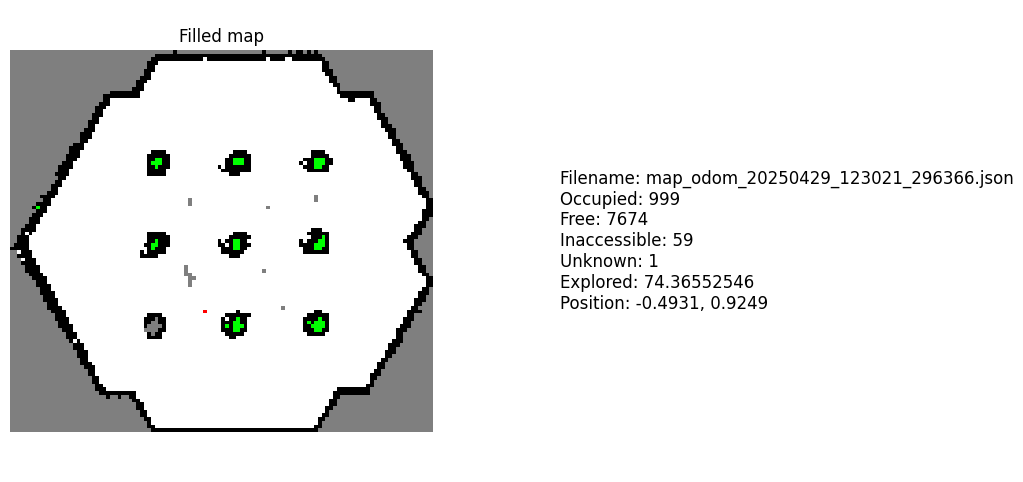

{'header': {'stamp': {'sec': 165, 'nanosec': 6000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 114, 'height': 103, 'origin': {'position': {'x': -3.0930613427857123, 'y': -2.6001939281111426, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, 100, -1, 100, 100, -1, 100, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, 

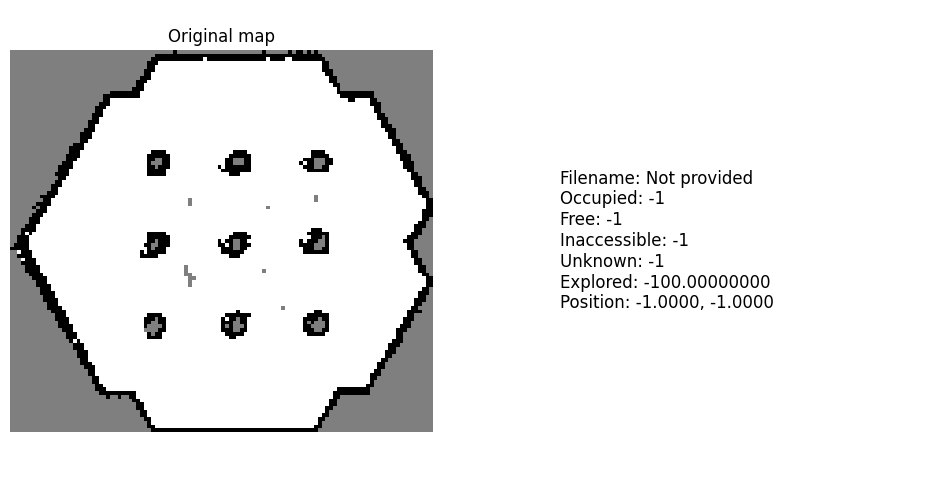

Marking position at world coordinates: (-0.32685198158693396, 0.7411696662415482)
Converted to pixel coordinates: (55, 66)
explored %f not explored %f 0.743655254641458 0.256344745358542


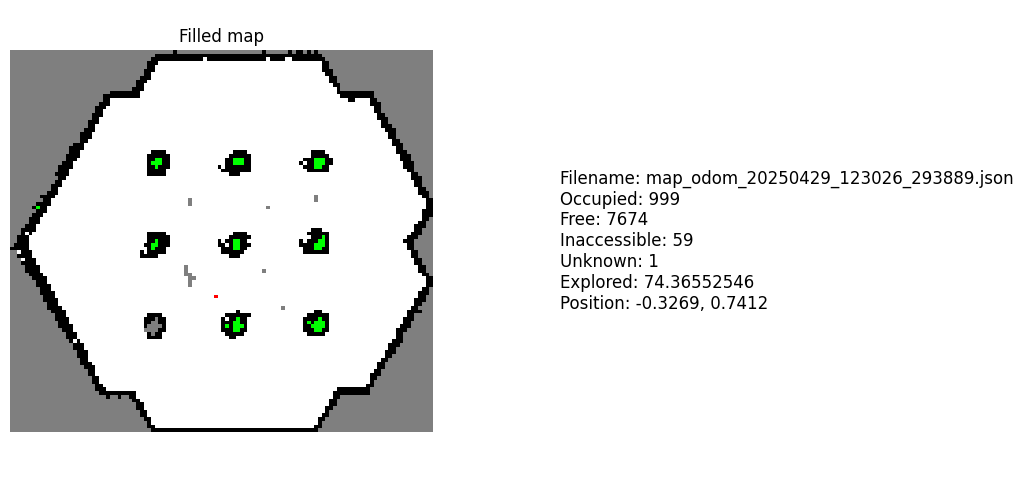

{'header': {'stamp': {'sec': 167, 'nanosec': 14000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 114, 'height': 103, 'origin': {'position': {'x': -3.0930613427857123, 'y': -2.6001939281111426, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, 100, -1, 100, 100, -1, 100, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100

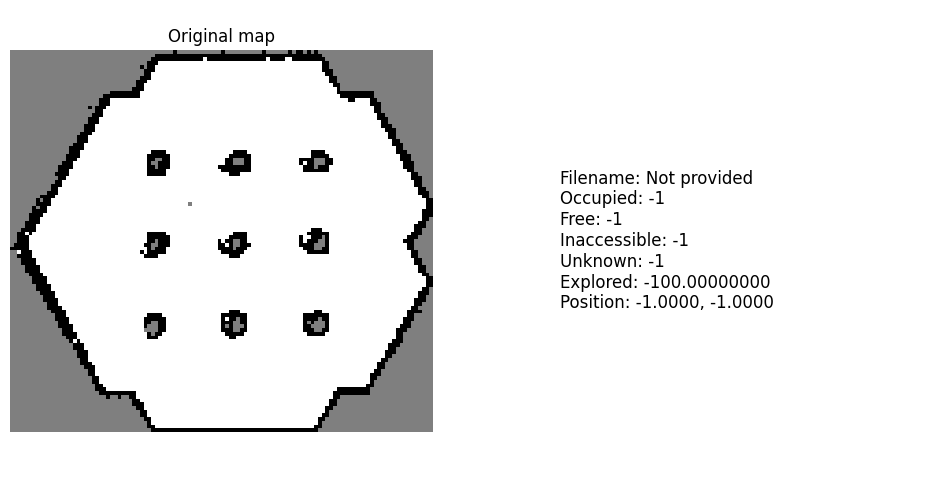

Marking position at world coordinates: (-0.180967163870454, 0.5889086785317639)
Converted to pixel coordinates: (58, 63)
explored %f not explored %f 0.7465508431272355 0.2534491568727645


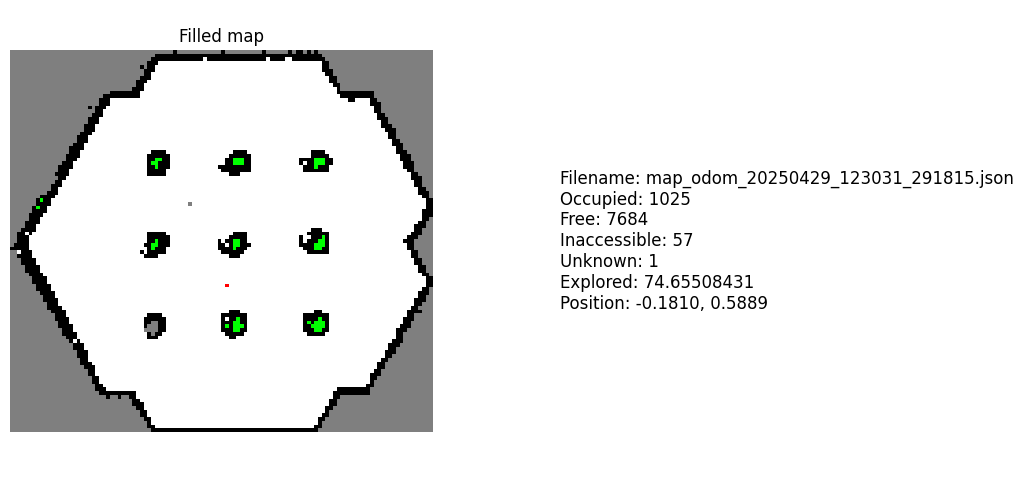

{'header': {'stamp': {'sec': 169, 'nanosec': 421000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 114, 'height': 103, 'origin': {'position': {'x': -3.0930613427857123, 'y': -2.6001939281111426, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, 100, -1, 100, 100, -1, 100, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, 100, 100

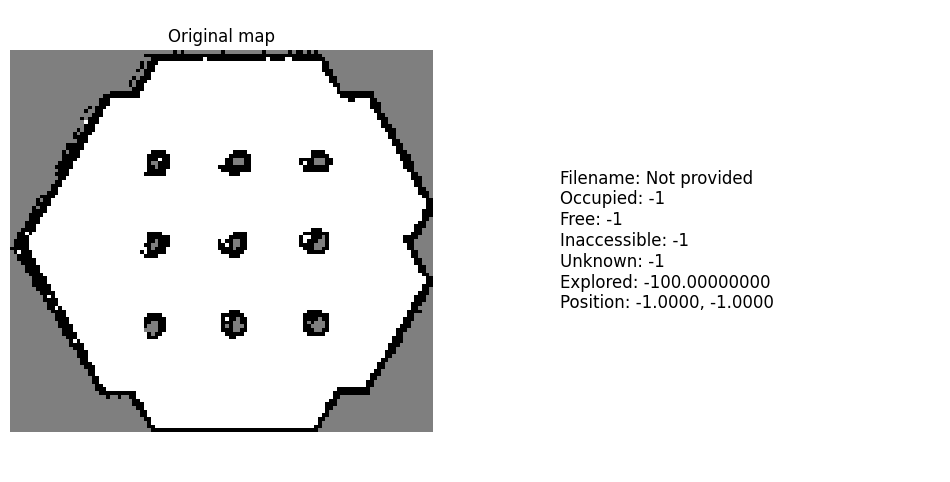

Marking position at world coordinates: (-0.012470272501623483, 0.47654134545519955)
Converted to pixel coordinates: (61, 61)
explored %f not explored %f 0.7493612672457843 0.25063873275421567


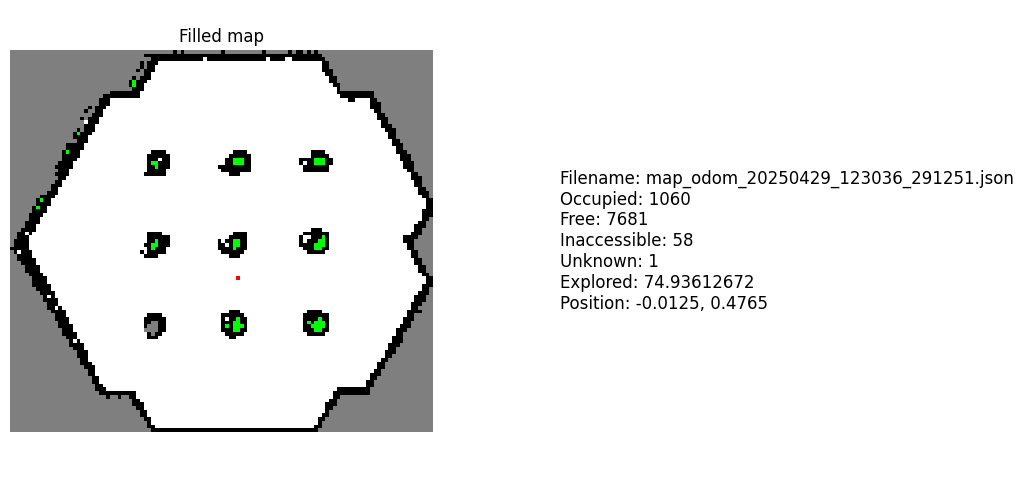

{'header': {'stamp': {'sec': 171, 'nanosec': 427000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 114, 'height': 103, 'origin': {'position': {'x': -3.0930613427857123, 'y': -2.6001939281111426, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, 100, -1, 100, 100, -1, 100, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, 100, 100

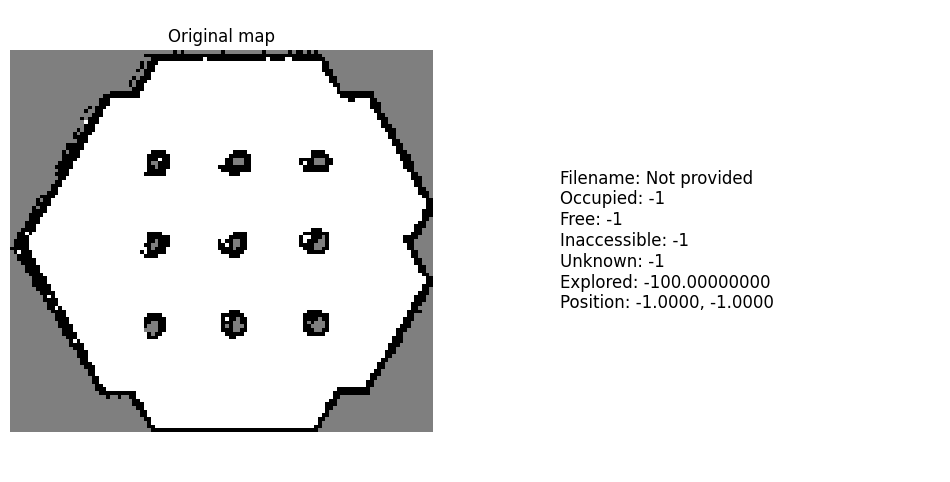

Marking position at world coordinates: (0.20059119777810136, 0.4681314794616638)
Converted to pixel coordinates: (65, 61)
explored %f not explored %f 0.7493612672457843 0.25063873275421567


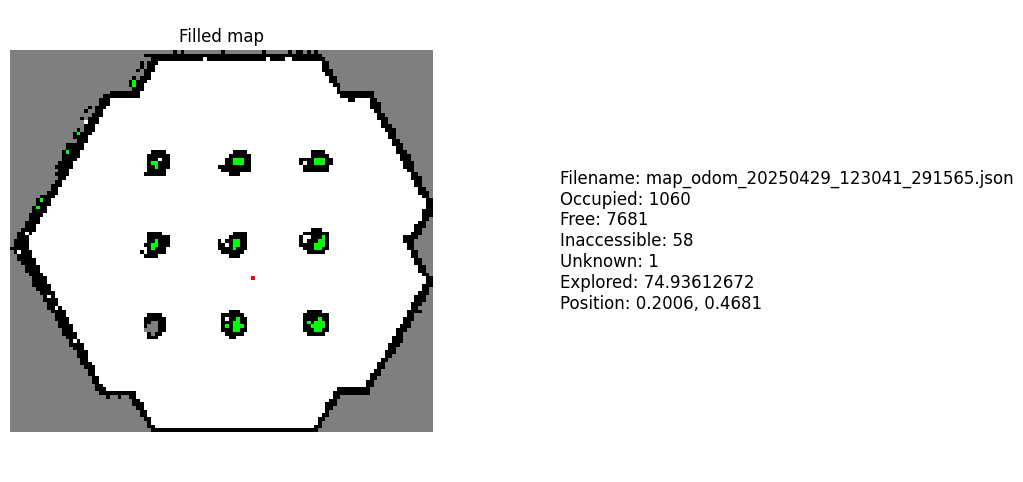

{'header': {'stamp': {'sec': 173, 'nanosec': 435000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 114, 'height': 103, 'origin': {'position': {'x': -3.0930613427857123, 'y': -2.6001939281111426, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, 100, -1, 100, 100, -1, 100, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, 100, 100

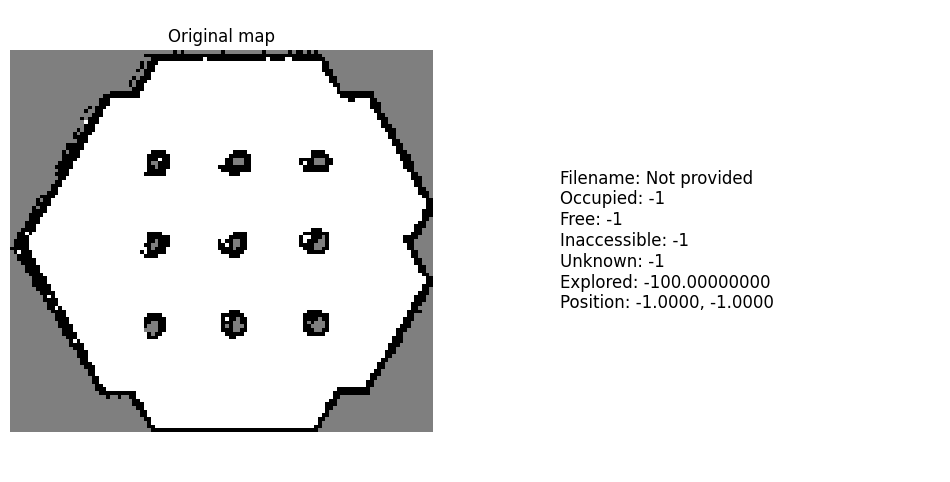

Marking position at world coordinates: (0.390433182878815, 0.48310411008356724)
Converted to pixel coordinates: (69, 61)
explored %f not explored %f 0.7493612672457843 0.25063873275421567


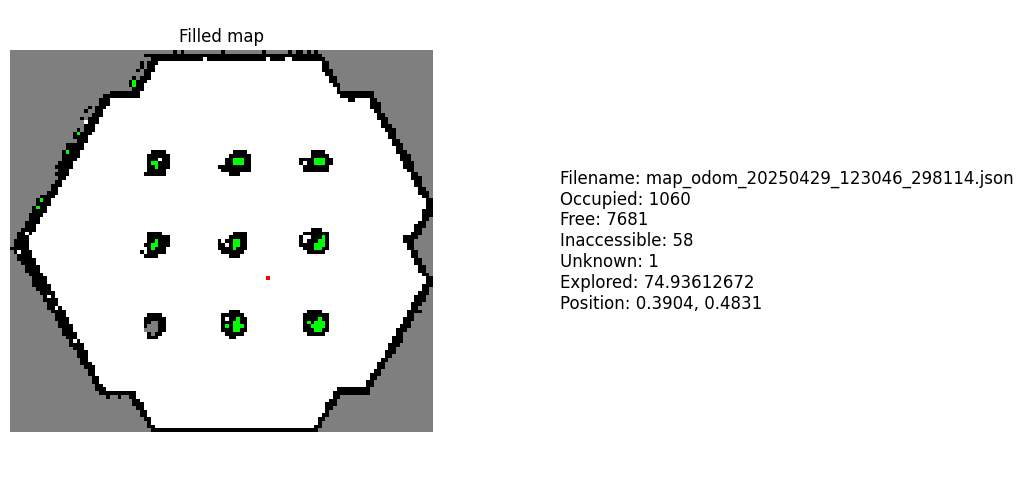

{'header': {'stamp': {'sec': 175, 'nanosec': 645000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 114, 'height': 103, 'origin': {'position': {'x': -3.0930613427857123, 'y': -2.6001939281111426, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, 100, -1, 100, 100, -1, 100, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, 100, 100

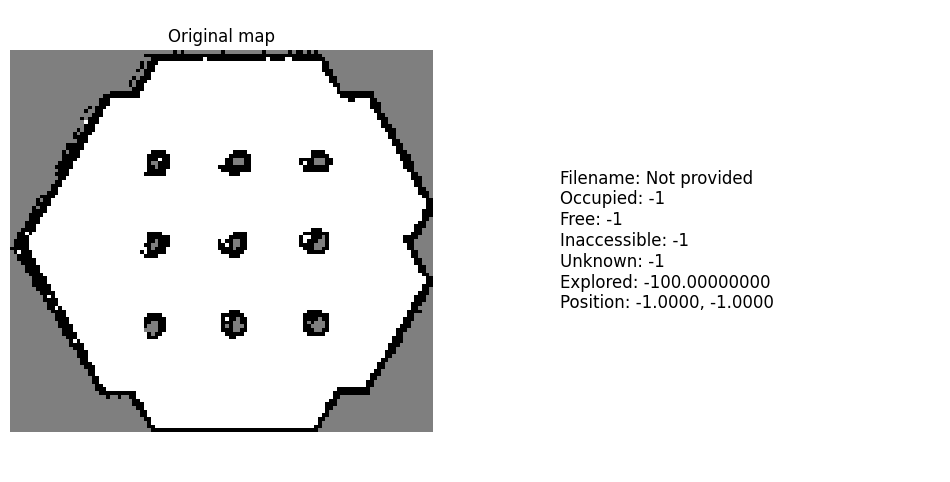

Marking position at world coordinates: (0.38618654563030386, 0.48320921181756277)
Converted to pixel coordinates: (69, 61)
explored %f not explored %f 0.7493612672457843 0.25063873275421567


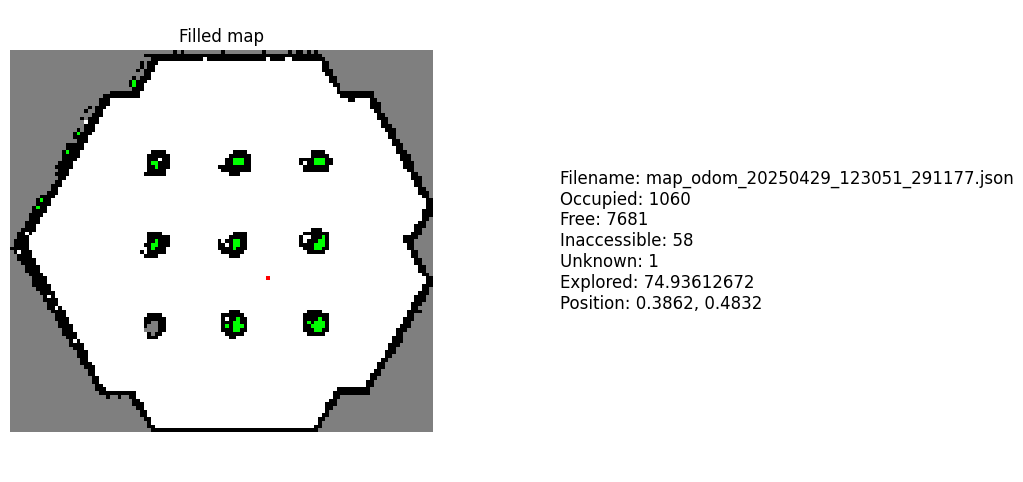

{'header': {'stamp': {'sec': 177, 'nanosec': 850000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 114, 'height': 103, 'origin': {'position': {'x': -3.0930613427857123, 'y': -2.6001939281111426, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, 100, -1, 100, 100, -1, 100, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, 100, 100

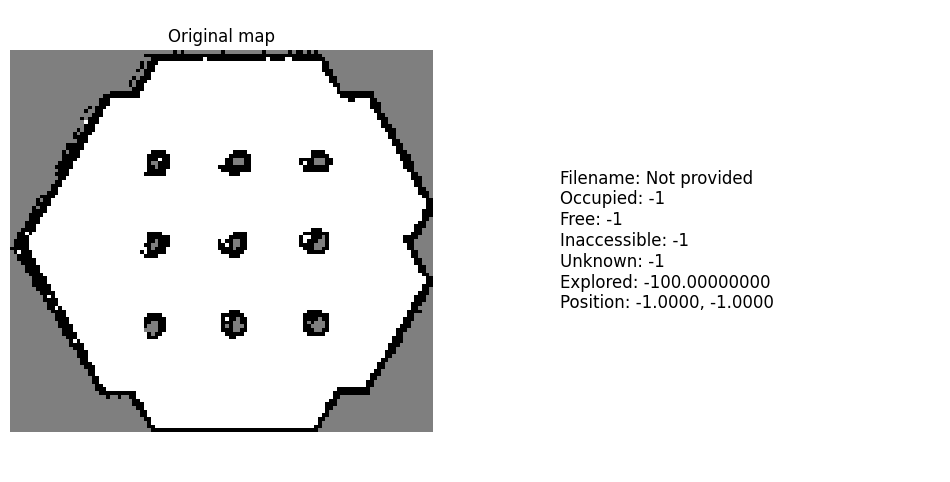

Marking position at world coordinates: (0.26757991471184084, 0.47472455238532396)
Converted to pixel coordinates: (67, 61)
explored %f not explored %f 0.7493612672457843 0.25063873275421567


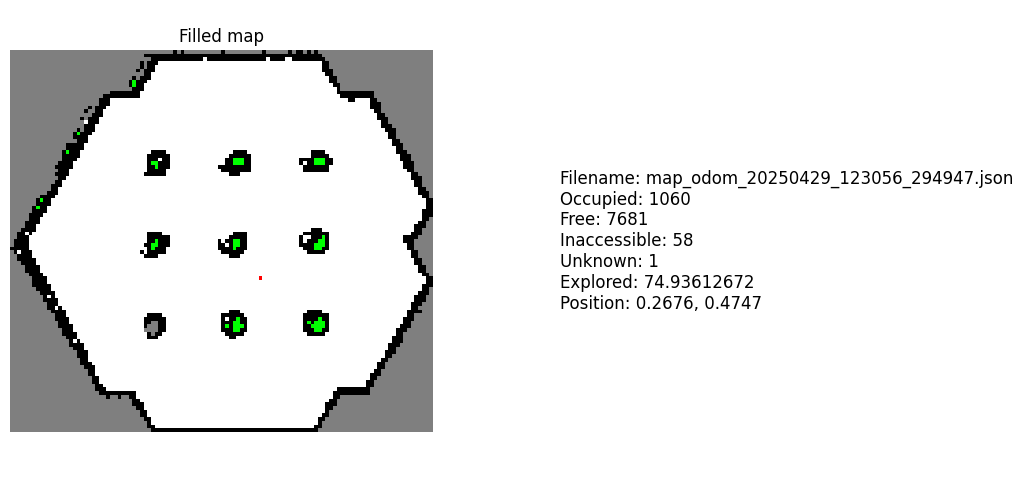

In [49]:
filenames = [_f.name for _f in os.scandir(DIRPATH) if _f.is_file()]
filenames.sort()

for _f in filenames:
    # print(_f)
    _grid, origin_x, origin_y = read_data_map(DIRPATH, _f)
    pos_x, pos_y = read_data_odom(DIRPATH, _f)
    print_plot_v2(_grid, title="Original map")
    
    filled_grid = fill_enclosed_unknowns_v2(_grid)
    fully_enclosed = is_fully_enclosed(filled_grid)
    # print(fully_enclosed, _f)
    if fully_enclosed: filled_grid = fill_outside_with_100(filled_grid)
    
    filled_grid = mark_position(filled_grid, pos_x, pos_y, origin_x, origin_y)
    
    occupied,\
    free,\
    inaccessible,\
    unknown,\
    explored_percent = calculate_remaining_space(filled_grid)
    print_plot_v2(
        filled_grid,
        title=f"Filled map",
        filename=_f,
        occupied=occupied,
        free=free,
        inaccessible=inaccessible,
        unknown=unknown,
        explored_percent=explored_percent,
        position_x=pos_x,
        position_y=pos_y
    )
    
    # break
    
    # TODO create fucntion to fill outer space / not calculate the remaining outer space